# Projet INSEE Partie (2) - SÉLECTION DES VARIABLES PAR APPRENTISSAGE AUTOMATIQUE - MOBILITÉ TRANSFRONTALIÈRE

---

## Introduction

Ce notebook constitue la **deuxième partie** du projet d'analyse des déterminants du travail transfrontalier dans la région Grand Est. Il s'inscrit dans une démarche méthodologique rigoureuse visant à préparer les données pour l'estimation des modèles économétriques.

| Étape         | Modèle                   | Objectif                                         | Statut         |
|---------------|--------------------------|--------------------------------------------------|----------------|
| **Partie 1**  | —                        | Préparation et validation de la base de données  | ✅ Terminé      |
| **Partie 2**  | Elastic Net              | Sélection des variables pertinentes              | 📍 Ce notebook |
| Partie 3      | Probit binaire simple    | Estimation des déterminants individuels          | À venir        |
| Partie 4      | Probit avec interactions | Hétérogénéité des effets selon le genre          | À venir        |
| Partie 5      | Probit bivarié           | Coordination des décisions au sein des couples   | À venir        |

---

## Objectif de cette partie

L'estimation d'un modèle probit économétrique requiert une **spécification parcimonieuse et interprétable**. Face à un grand nombre de variables potentiellement explicatives (106 dans la base initiale), une procédure de sélection rigoureuse est nécessaire pour :

1. **Éliminer les variables redondantes** — éviter la multicolinéarité qui dégrade les estimations
2. **Identifier les déterminants pertinents** — retenir uniquement les variables à fort pouvoir prédictif
3. **Garantir l'interprétabilité** — construire une spécification économiquement cohérente

Cette partie combine deux approches complémentaires :
- **Analyse de multicolinéarité** : diagnostics statistiques (Spearman, Cramér, VIF) et arbitrages économiques
- **Régularisation Elastic Net** : sélection automatique par pénalisation des coefficients

---

## Données utilisées

La base de données est issue de la fusion des fichiers INSEE **MOBPRO** et **INDCVI** pour la région Grand Est (Partie 1).

| Caractéristique                  | Valeur                |
|----------------------------------|-----------------------|
| Observations                     | 494 483               |
| Variables initiales              | 106                   |
| Variables après arbitrages       | 81 features           |
| Transfrontaliers (Y = 1)         | 44 264 (8,95 %)       |
| Non-transfrontaliers (Y = 0)     | 450 219 (91,05 %)     |

---

## Méthodologie en deux étapes

### Étape 1 : Analyse de multicolinéarité et arbitrages économiques

Avant toute modélisation, une analyse exhaustive des corrélations entre variables est réalisée pour identifier les **paniers de redondance** :

| Indicateur                        | Seuil          | Paires identifiées |
|-----------------------------------|----------------|--------------------|
| Corrélations Spearman (numériques)| \|r\| ≥ 0.70   | 17                 |
| Associations V de Cramér (catég.) | V ≥ 0.50       | 665                |
| VIF critique                      | VIF > 10       | 11 variables       |
| Paniers de redondance             | —              | 7 paniers          |

Pour chaque panier, un **arbitrage économique** est effectué selon les critères suivants :
- Pertinence théorique pour la mobilité transfrontalière
- Interprétabilité des coefficients
- Standard de la littérature économétrique
- Parcimonie de la spécification

### Étape 2 : Sélection par Elastic Net

Une fois les arbitrages effectués, une régression **Elastic Net** est appliquée pour :
- Confirmer la pertinence des variables retenues
- Quantifier leur importance relative
- Valider le pouvoir discriminant de la spécification

---

## Choix méthodologique : pourquoi l'Elastic Net ?

Trois méthodes de régularisation étaient envisageables :

| Méthode         | Pénalité       | Sélection | Gestion corrélations | Retenue ?  |
|-----------------|----------------|-----------|----------------------|------------|
| Ridge (L2)      | $\|\beta\|_2^2$| ❌ Non     | ✅ Oui               | ❌          |
| LASSO (L1)      | $\|\beta\|_1$  | ✅ Oui     | ❌ Instable          | ❌          |
| **Elastic Net** | L1 + L2        | ✅ Oui     | ✅ Oui               | ✅          |

**Justification du choix Elastic Net** :

1. **Corrélations résiduelles entre concepts** — Malgré les arbitrages, certaines variables restent corrélées (ex : DEPT et DNAI). Le LASSO pur sélectionne arbitrairement l'une d'entre elles, tandis que l'Elastic Net stabilise la sélection.

2. **Groupes de modalités** — Les variables catégorielles génèrent des dummies corrélées (ex : DEPT_57, DEPT_68). L'Elastic Net tend à sélectionner ou exclure le groupe entier, préservant la cohérence.

3. **Compromis biais-variance** — La composante Ridge réduit la variance des estimateurs sans sacrifier la sélection de variables.

---

## Formulation mathématique

### Fonction objectif de l'Elastic Net

L'Elastic Net minimise la log-vraisemblance pénalisée :

$$\hat{\beta} = \arg\min_{\beta} \left\{ -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{p}_i) + (1-y_i) \log(1-\hat{p}_i) \right] + \lambda \left[ \alpha \|\beta\|_1 + \frac{(1-\alpha)}{2} \|\beta\|_2^2 \right] \right\}$$

où :
- $\hat{p}_i = \frac{1}{1 + e^{-X_i'\beta}}$ est la probabilité prédite (lien logistique)
- $\lambda = \frac{1}{C}$ est la force de régularisation globale
- $\alpha$ (`l1_ratio`) contrôle le mélange L1/L2 :
  - $\alpha = 1$ : LASSO pur
  - $\alpha = 0$ : Ridge pur
  - $0 < \alpha < 1$ : Elastic Net

### Hyperparamètres optimisés

| Paramètre   | Grille de recherche | Valeur optimale |
|-------------|---------------------|-----------------|
| C           | {0.01, 0.1, 1}      | 1               |
| l1_ratio    | {0.7, 0.9, 1.0}     | 0.7             |

La valeur `l1_ratio = 0.7` confirme l'intérêt de la composante Ridge (30%) pour stabiliser la sélection.

---

## Plan du notebook

Ce notebook est organisé en **8 sections** :

| Section | Contenu                                                              |
|---------|----------------------------------------------------------------------|
| 1       | Chargement et vérification des données                               |
| 2       | Création des variables dérivées (TRANSFRONTALIER, WORK_IN_PAYS)      |
| 3       | Profiling de la base de données                                      |
| 4       | Analyse de multicolinéarité (Spearman, Cramér, VIF, clustering)      |
| 5       | Arbitrages économiques par paniers de variables                      |
| 6       | Préparation des données pour le Machine Learning                     |
| 7       | Estimation Elastic Net avec Grid Search et validation croisée        |
| 8       | Analyse des résultats et sélection finale des variables              |

---

## Variables candidates initiales

Les variables explicatives candidates sont regroupées par dimension conceptuelle :

| Catégorie           | Variables candidates                                    | Après arbitrage        |
|---------------------|---------------------------------------------------------|------------------------|
| **Démographie**     | AGED, AGER20, AGEREV, AGEREVQ, ANAI, SEXE               | AGEREV + AGEREV², SEXE |
| **Géographie**      | DEPT, DNAI, COMMUNE, IRIS                               | DEPT, DNAI             |
| **Capital humain**  | DIPL, ETUD                                              | DIPL, ETUD             |
| **Emploi**          | GS, STAT, STATR, EMPL, NA5, NA17, TP                    | GS, EMPL, NA5, TP      |
| **Famille**         | COUPLE, STAT_CONJ, NENFR, TAF, TYPFC, NE17FR...         | COUPLE, NENFR          |
| **Logement**        | STOCD, TYPL, SANI, VOIT, SURF, NBPI...                  | STOCD, TYPL, SANI, VOIT|
| **Origine**         | IMMI, INATC, NAIDT                                      | INATC                  |

---

## Résultats attendus

Cette analyse permettra de :

1. **Identifier les paniers de redondance** et effectuer des arbitrages économiques justifiés
2. **Valider la pertinence des variables** par leur contribution à l'AUC-ROC
3. **Quantifier l'importance relative** de chaque déterminant
4. **Produire une spécification finale** prête pour l'estimation Probit (Partie 3)

### Critères de succès

| Métrique                | Seuil acceptable | Objectif       |
|-------------------------|------------------|----------------|
| AUC-ROC (test)          | > 0.75           | > 0.80         |
| Variables sélectionnées | < 30 concepts    | 15-20 concepts |
| VIF maximal (post-sélection) | < 10        | < 5            |

---

## Avertissement méthodologique

L'Elastic Net est utilisé ici comme **outil de sélection de variables**, non comme modèle final d'inférence. Les coefficients estimés ne sont pas directement interprétables en termes d'effets marginaux — cette interprétation sera réalisée dans la Partie 3 avec le modèle Probit.

L'objectif est de construire un ensemble de variables :
- **Statistiquement pertinentes** (pouvoir prédictif validé)
- **Économiquement cohérentes** (arbitrages théoriques justifiés)
- **Techniquement exploitables** (absence de multicolinéarité sévère)

---

*Partie 2 — Projet INSEE Mobilité Transfrontalière Grand Est*  
*Master 2 Statistique, Économétrie & Data Science — Université de Strasbourg*

# Step 1 : Chargement et vérification des données

In [1]:
import pandas as pd
import numpy as np

# ============================================================
# ÉTAPE 1 — CHARGEMENT ROBUSTE DE LA BDD (ANTI-PIÈGES INSEE)
# ============================================================

INPUT_PATH = "/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/BDD_FINAL_CLEAN.csv"

print("\n[1] TEST DU FORMAT DU FICHIER")
with open(INPUT_PATH, "r", encoding="utf-8", errors="ignore") as f:
    head = f.readline()

print("Première ligne (extrait) :")
print(head[:300])
print("';' :", head.count(";"), " | ',' :", head.count(","), " | '\\t' :", head.count("\t"))

print("\n[2] LECTURE ROBUSTE DU CSV")
df = pd.read_csv(
    INPUT_PATH,
    sep=None,            # auto-détection
    engine="python",
    encoding="utf-8",
)

print("✔ Dimensions :", df.shape)
print("✔ Colonnes (20 premières) :", list(df.columns[:20]))

# ============================================================
# VERROUILLAGE DES VARIABLES CLÉS
# ============================================================

# Sécurité noms de colonnes
if "DCFLT" not in df.columns and "DCLT" in df.columns:
    df = df.rename(columns={"DCLT": "DCFLT"})

# Typage strict
df["ILT"] = pd.to_numeric(df["ILT"], errors="coerce").astype("Int64")
df["DCFLT"] = df["DCFLT"].astype("string")

print("\n[3] VÉRIFICATIONS CRITIQUES")
print("ILT présent :", "ILT" in df.columns)
print("DCFLT présent :", "DCFLT" in df.columns)
print("Distribution ILT :")
print(df["ILT"].value_counts(dropna=False).sort_index())



[1] TEST DU FORMAT DU FICHIER
Première ligne (extrait) :
COMMUNE;ARM;DCFLT;DCLT;AGEREVQ;GS;DEROU;DIPL;EMPL;ILT;ILTUU;IMMI;INATC;INEEM;INPOM;INPSM;IPONDI;LPRM;METRODOM;MOCO;NA5;NPERR;REGION;REGLT;SEXE;STAT;STOCD;TP;TRANS;TYPL;TYPMR;VOIT;DEPT;DEPCOM;CANTVILLE;KEY;NUMMI;ACHLR;AEMMR;AGED;AGER20;AGEREV;ANAI;ANEMR;APAF;ASCEN;BAIN;BATI;CATIRIS;CATL;CATPC;CHAU;CH
';' : 105  | ',' : 0  | '\t' : 0

[2] LECTURE ROBUSTE DU CSV
✔ Dimensions : (494483, 106)
✔ Colonnes (20 premières) : ['COMMUNE', 'ARM', 'DCFLT', 'DCLT', 'AGEREVQ', 'GS', 'DEROU', 'DIPL', 'EMPL', 'ILT', 'ILTUU', 'IMMI', 'INATC', 'INEEM', 'INPOM', 'INPSM', 'IPONDI', 'LPRM', 'METRODOM', 'MOCO']

[3] VÉRIFICATIONS CRITIQUES
ILT présent : True
DCFLT présent : True
Distribution ILT :
ILT
1    158593
2    253635
3     27098
4     10840
5        46
6         7
7     44264
Name: count, dtype: Int64


## STEP 2 : Création des variables cibles et enrichissement de la base

### Objectif

Cette section crée les **variables essentielles** pour l'analyse économétrique à partir de la base nettoyée. Ces variables constituent le socle de tous les modèles qui suivront.

### Variables créées

| Variable           | Type     | Description                                      | Usage 

| `ID_INDIVIDU`      | int      | Identifiant unique séquentiel (1 à n)            | Traçabilité des observations   |
| `TRANSFRONTALIER`  | binaire  | 1 si travaille hors de France, 0 sinon           | **Variable dépendante (Y)**    |
| `WORK_IN_PAYS`     | catég.   | Pays de travail (Luxembourg, Allemagne, etc.)    | Analyse descriptive            |
| `WORK_LUXEMBOURG`  | binaire  | 1 si travaille au Luxembourg                     | Analyses par destination       |
| `WORK_ALLEMAGNE`   | binaire  | 1 si travaille en Allemagne                      | Analyses par destination       |
| `WORK_SUISSE`      | binaire  | 1 si travaille en Suisse                         | Analyses par destination       |
| `WORK_BELGIQUE`    | binaire  | 1 si travaille en Belgique                       | Analyses par destination       |

### Logique de construction

La variable `TRANSFRONTALIER` est construite à partir du code INSEE `ILT` (Indicateur de Lieu de Travail) :

$$\text{TRANSFRONTALIER}_i = \mathbb{1}_{\{ILT_i = 7\}}$$

où `ILT = 7` correspond à *"Travaille à l'étranger"* dans la nomenclature INSEE.

Le pays de destination est déduit du code `DCFLT` (Département ou pays du lieu de travail) selon les préfixes :

| Préfixe DCFLT | Pays           |
|---------------|----------------|
| `99999`       | France         |
| `LU*`         | Luxembourg     |
| `AL*`         | Allemagne      |
| `SU*`         | Suisse         |
| `BE*`         | Belgique       |
| `MO*`         | Monaco         |
| Autre         | Autre étranger |

### Vérification de cohérence

Un contrôle est effectué pour détecter les incohérences potentielles : individus avec `ILT = 7` (transfrontalier) mais `DCFLT = 99999` (France). Ces cas, s'ils existent, indiquent une erreur de codage dans les données sources.

### Exports

| Fichier                      | Contenu                              | Format |
|------------------------------|--------------------------------------|--------|
| `BDD_FINAL_new.csv`          | Base complète enrichie (494 483 obs) | CSV ;  |
| `BDD_FINAL_new_sample10k.xlsx`| Échantillon 10 000 lignes           | Excel  |

L'échantillon Excel facilite l'inspection visuelle et le contrôle qualité.

In [1]:
"""
================================================================================
ENRICHISSEMENT DE LA BASE - CRÉATION DES VARIABLES CIBLES
================================================================================
Projet INSEE - Mobilité Transfrontalière Grand Est
Auteur : Mehdi FEHRI
Date   : Janvier 2026

Ce script :
  1. Crée l'identifiant unique ID_INDIVIDU
  2. Construit la variable cible TRANSFRONTALIER (Y)
  3. Identifie le pays de destination (WORK_IN_PAYS)
  4. Génère les indicatrices par pays
  5. Exporte la base enrichie + échantillon de contrôle
================================================================================
"""

import pandas as pd
import numpy as np
from pathlib import Path

# ==============================================================================
# CONFIGURATION
# ==============================================================================

CONFIG = {
    "input_path": Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/BDD_FINAL_CLEAN.csv"),
    "output_csv": Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/BDD_FINAL_new.csv"),
    "output_xlsx": Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/BDD_FINAL_new_sample10k.xlsx"),
    "sample_size": 10_000,
    "random_state": 42,
}

# Mapping des préfixes DCFLT vers pays
PAYS_MAPPING = {
    "LU": "Luxembourg",
    "AL": "Allemagne", 
    "SU": "Suisse",
    "BE": "Belgique",
    "MO": "Monaco",
}

# Colonnes prioritaires pour l'export Excel
COLS_PRIORITY = [
    "ID_INDIVIDU", "ILT", "DCFLT", "TRANSFRONTALIER", "WORK_IN_PAYS",
    "WORK_LUXEMBOURG", "WORK_ALLEMAGNE", "WORK_SUISSE", "WORK_BELGIQUE",
    "REGLT", "DEPT", "DEPCOM", "CANTVILLE"
]


# ==============================================================================
# FONCTIONS
# ==============================================================================

def print_header(title: str, char: str = "═", width: int = 70) -> None:
    """Affiche un en-tête formaté."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_step(step: int, description: str) -> None:
    """Affiche une étape numérotée."""
    print(f"\n[{step}] {description}")
    print("─" * 50)


def print_stat(label: str, value, indent: int = 4) -> None:
    """Affiche une statistique formatée."""
    space = " " * indent
    if isinstance(value, (int, np.integer)):
        print(f"{space}• {label:<30} : {value:>12,}")
    elif isinstance(value, float):
        print(f"{space}• {label:<30} : {value:>12.2%}")
    else:
        print(f"{space}• {label:<30} : {value}")


def identify_country(dcflt_series: pd.Series) -> np.ndarray:
    """
    Identifie le pays de travail à partir du code DCFLT.
    Vectorisé pour performance optimale.
    """
    n = len(dcflt_series)
    result = np.full(n, "Autre_etranger", dtype=object)
    
    # France (code 99999)
    result[dcflt_series == "99999"] = "France"
    
    # Pays frontaliers (par préfixe)
    for prefix, country in PAYS_MAPPING.items():
        mask = dcflt_series.str.startswith(prefix, na=False)
        result[mask] = country
    
    return result


def reorder_columns(df: pd.DataFrame, priority_cols: list) -> pd.DataFrame:
    """Réordonne les colonnes avec les prioritaires en premier."""
    existing_priority = [c for c in priority_cols if c in df.columns]
    other_cols = [c for c in df.columns if c not in existing_priority]
    return df[existing_priority + other_cols]


# ==============================================================================
# PIPELINE PRINCIPAL
# ==============================================================================

def main():
    print_header("ENRICHISSEMENT DE LA BASE DE DONNÉES")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 1 : Chargement
    # ──────────────────────────────────────────────────────────────────────────
    print_step(1, "CHARGEMENT DES DONNÉES")
    
    df = pd.read_csv(CONFIG["input_path"], sep=";", encoding="utf-8", low_memory=False)
    
    print_stat("Observations", len(df))
    print_stat("Variables", df.shape[1])
    
    # Sécurité : renommage si nécessaire
    if "DCFLT" not in df.columns and "DCLT" in df.columns:
        df = df.rename(columns={"DCLT": "DCFLT"})
        print("    ⚠ Colonne DCLT renommée en DCFLT")
    
    # Vérification colonnes critiques
    for col in ["ILT", "DCFLT"]:
        if col not in df.columns:
            raise ValueError(f"Colonne critique manquante : {col}")
    
    # Typage strict
    df["ILT"] = pd.to_numeric(df["ILT"], errors="coerce").astype("Int64")
    df["DCFLT"] = df["DCFLT"].astype("string").str.strip().str.upper()
    
    print("    ✓ Données chargées et typées")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 2 : Création des variables
    # ──────────────────────────────────────────────────────────────────────────
    print_step(2, "CRÉATION DES VARIABLES")
    
    # ID unique
    df["ID_INDIVIDU"] = np.arange(1, len(df) + 1, dtype=np.int32)
    print(f"    ✓ ID_INDIVIDU créé (1 → {len(df):,})")
    
    # Variable cible : TRANSFRONTALIER
    df["TRANSFRONTALIER"] = (df["ILT"] == 7).astype("int8")
    n_transf = df["TRANSFRONTALIER"].sum()
    pct_transf = n_transf / len(df)
    print(f"    ✓ TRANSFRONTALIER créé")
    print_stat("Transfrontaliers (Y=1)", n_transf)
    print_stat("Proportion", pct_transf)
    
    # Pays de travail
    df["WORK_IN_PAYS"] = identify_country(df["DCFLT"])
    df.loc[df["TRANSFRONTALIER"] == 0, "WORK_IN_PAYS"] = "France"  # Cohérence
    print(f"    ✓ WORK_IN_PAYS créé")
    
    # Indicatrices par pays
    for pays in ["Luxembourg", "Allemagne", "Suisse", "Belgique"]:
        col_name = f"WORK_{pays.upper()}"
        df[col_name] = (df["WORK_IN_PAYS"] == pays).astype("int8")
    print(f"    ✓ Indicatrices pays créées (4 variables)")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 3 : Vérifications de cohérence
    # ──────────────────────────────────────────────────────────────────────────
    print_step(3, "VÉRIFICATIONS DE COHÉRENCE")
    
    # Incohérences ILT=7 mais DCFLT=France
    n_incoh = ((df["TRANSFRONTALIER"] == 1) & (df["DCFLT"] == "99999")).sum()
    status = "✓" if n_incoh == 0 else "⚠"
    print(f"    {status} ILT=7 avec DCFLT=99999 : {n_incoh}")
    
    # Distribution des destinations
    print("\n    Répartition des transfrontaliers par pays :")
    distrib = df.loc[df["TRANSFRONTALIER"] == 1, "WORK_IN_PAYS"].value_counts()
    for pays, count in distrib.items():
        pct = count / n_transf
        print(f"        {pays:<25} : {count:>6,}  ({pct:>6.1%})")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 4 : Exports
    # ──────────────────────────────────────────────────────────────────────────
    print_step(4, "EXPORTS")
    
    # CSV complet
    df.to_csv(CONFIG["output_csv"], index=False, sep=";")
    print(f"    ✓ CSV exporté : {CONFIG['output_csv'].name}")
    print_stat("Taille", f"{CONFIG['output_csv'].stat().st_size / 1e6:.1f} Mo")
    
    # Échantillon Excel
    sample = (df
              .sample(n=CONFIG["sample_size"], random_state=CONFIG["random_state"])
              .pipe(reorder_columns, COLS_PRIORITY))
    
    sample.to_excel(CONFIG["output_xlsx"], index=False)
    print(f"    ✓ Excel exporté : {CONFIG['output_xlsx'].name}")
    print_stat("Lignes échantillon", len(sample))
    
    # ──────────────────────────────────────────────────────────────────────────
    # RÉSUMÉ FINAL
    # ──────────────────────────────────────────────────────────────────────────
    print_header("RÉSUMÉ", char="─")
    
    print(f"""
    Base enrichie : {len(df):,} observations × {df.shape[1]} variables
    
    Variables créées :
        • ID_INDIVIDU      : identifiant unique
        • TRANSFRONTALIER  : variable cible binaire (Y)
        • WORK_IN_PAYS     : pays de destination
        • WORK_LUXEMBOURG  : indicatrice Luxembourg
        • WORK_ALLEMAGNE   : indicatrice Allemagne
        • WORK_SUISSE      : indicatrice Suisse
        • WORK_BELGIQUE    : indicatrice Belgique
    
    ✓ Pipeline terminé avec succès
    """)
    
    return df


# ==============================================================================
# EXÉCUTION
# ==============================================================================

if __name__ == "__main__":
    df = main()


══════════════════════════════════════════════════════════════════════
  ENRICHISSEMENT DE LA BASE DE DONNÉES
══════════════════════════════════════════════════════════════════════

[1] CHARGEMENT DES DONNÉES
──────────────────────────────────────────────────
    • Observations                   :      494,483
    • Variables                      :          106
    ✓ Données chargées et typées

[2] CRÉATION DES VARIABLES
──────────────────────────────────────────────────
    ✓ ID_INDIVIDU créé (1 → 494,483)
    ✓ TRANSFRONTALIER créé
    • Transfrontaliers (Y=1)         :       44,264
    • Proportion                     :        8.95%
    ✓ WORK_IN_PAYS créé
    ✓ Indicatrices pays créées (4 variables)

[3] VÉRIFICATIONS DE COHÉRENCE
──────────────────────────────────────────────────
    ✓ ILT=7 avec DCFLT=99999 : 0

    Répartition des transfrontaliers par pays :
        Luxembourg                : 23,563  ( 53.2%)
        Allemagne                 : 10,135  ( 22.9%)
        Suisse 

## Stratégie d'estimation : Probit et sélection de variables assistée par Machine Learning

### Objectif

Ce premier volet vise à estimer un **modèle probit binaire** pour analyser les déterminants de la probabilité d'être **travailleur transfrontalier** dans la région Grand Est. La variable dépendante $Y_i$ prend la valeur 1 si l'individu exerce une activité professionnelle hors de France tout en résidant dans le Grand Est, et 0 sinon.

Le choix du probit s'inscrit dans le cadre économétrique standard pour les variables dichotomiques. Il permet une interprétation structurée des résultats via les **effets marginaux** et constitue une référence largement utilisée dans l'analyse des comportements de mobilité professionnelle.

### Pourquoi compléter le probit par une étape de Machine Learning ?

La base de données finale, issue de l'appariement des fichiers INSEE INDCVI et MOBPRO, comprend un nombre important de variables individuelles, professionnelles, géographiques et résidentielles. Dans ce contexte, la sélection des covariables du modèle probit pose plusieurs enjeux :

- **Limitation de l'arbitraire** dans le choix des variables explicatives
- **Gestion de la multicolinéarité** entre caractéristiques socio-démographiques et professionnelles
- **Identification des variables pertinentes** dans un espace de dimension élevée

L'introduction d'une étape de Machine Learning ne vise pas à remplacer l'approche économétrique, mais à **sécuriser la spécification du modèle probit** par une procédure de sélection systématique, reproductible et guidée par les données.

### Méthodes envisagées : régression pénalisée

Une régression binaire pénalisée sera utilisée comme outil de présélection des covariables. Deux approches sont envisageables :

| Méthode         | Pénalité                   | Propriétés                                          |
|-----------------|----------------------------|-----------------------------------------------------|
| **LASSO (L1)**  | $\lambda \|\beta\|_1$      | Sélection stricte, coefficients mis à zéro          |
| **Elastic Net** | $\lambda[\alpha\|\beta\|_1 + (1-\alpha)\|\beta\|_2^2]$ | Sélection + stabilité en présence de corrélations |

Ces méthodes permettent :

- une **sélection automatique** des variables les plus informatives pour la prédiction du statut de travailleur transfrontalier
- la **réduction de la dimension** du modèle en annulant les coefficients des variables peu contributives
- une meilleure **gestion des corrélations** entre variables issues de sources riches et détaillées
- un calibrage rigoureux via **validation croisée**, limitant les risques de sur-ajustement

Le choix définitif entre LASSO pur et Elastic Net sera effectué en fonction des résultats empiriques, notamment de l'analyse préalable de multicolinéarité. Si les variables candidates présentent des corrélations résiduelles importantes, l'Elastic Net sera privilégié pour sa capacité à stabiliser la sélection au sein de groupes de variables corrélées.

### Note sur le lien logit

À cette étape de sélection, l'utilisation d'un lien logit (plutôt que probit) est retenue pour des raisons de robustesse numérique et de disponibilité des algorithmes d'optimisation. Cette distinction est sans conséquence sur la sélection des variables : les deux fonctions de lien produisent des classements quasi-identiques, seule l'échelle des coefficients diffère. L'objectif n'étant pas l'interprétation des coefficients mais l'identification des covariables informatives, ce choix est méthodologiquement neutre.

### Enchaînement des étapes empiriques

La stratégie d'estimation repose sur une approche en deux temps :

| Étape | Méthode                      | Objectif                                              |
|-------|------------------------------|-------------------------------------------------------|
| 1     | Régression pénalisée (ML)    | Sélection d'un ensemble restreint de variables        |
| 2     | Probit standard (MLE)        | Estimation et interprétation des déterminants         |

**Étape 1 — Sélection assistée par Machine Learning (outil auxiliaire)**

- Analyse de multicolinéarité et arbitrages économiques préalables
- Estimation d'un modèle binaire pénalisé (LASSO ou Elastic Net) sur un échantillon de travail
- Optimisation des hyperparamètres par validation croisée
- Identification d'un ensemble restreint de variables candidates

**Étape 2 — Estimation économétrique (modèle principal)**

- Estimation d'un probit standard par maximum de vraisemblance sur la base finale
- Calcul des effets marginaux (AME et MEM)
- Analyse des coefficients pour caractériser les déterminants individuels, professionnels et géographiques de la mobilité transfrontalière

### Positionnement méthodologique

Cette approche permet de concilier :

- la **rigueur interprétative** du modèle probit, au cœur de l'analyse économique des choix discrets
- une **sélection de variables robuste et reproductible**, issue d'outils de Machine Learning

L'étape de Machine Learning est ainsi mobilisée comme **complément méthodologique à l'économétrie**, destiné à renforcer la solidité et la crédibilité de la spécification retenue pour l'analyse des travailleurs transfrontaliers dans la région Grand Est.

## Choix de la méthode de pénalisation pour la sélection des variables

Dans le cadre de l'estimation d'un modèle probit visant à analyser les déterminants du travail transfrontalier dans la région Grand Est, une étape préalable de sélection des covariables est nécessaire afin de construire une spécification parcimonieuse et interprétable.

Trois méthodes de pénalisation sont envisageables :

| Méthode         | Pénalité         | Sélection | Gestion des corrélations | Parcimonie |
|-----------------|------------------|-----------|--------------------------|------------|
| **Ridge (L2)**  | $\|\beta\|_2^2$  | ❌ Non    | ✅ Bonne                  | ❌ Faible  |
| **LASSO (L1)**  | $\|\beta\|_1$    | ✅ Oui    | ⚠️ Instable               | ✅ Forte   |
| **Elastic Net** | L1 + L2          | ✅ Oui    | ✅ Bonne                  | ⚠️ Modérée |

### Ridge (L2)

Cette méthode réduit la variance des estimateurs en pénalisant la norme des coefficients, mais **ne réalise pas de sélection explicite** des variables. L'ensemble des covariables demeure dans le modèle, ce qui ne répond pas à l'objectif de construction d'une spécification économétrique interprétable. Le Ridge est donc écarté.

### LASSO (L1)

Le LASSO permet une **sélection automatique et stricte** des variables en annulant les coefficients des covariables peu informatives. Il constitue un outil efficace de réduction de dimension. Toutefois, en présence de variables fortement corrélées, le LASSO tend à sélectionner arbitrairement l'une d'entre elles, ce qui peut conduire à des résultats instables.

### Elastic Net (L1 + L2)

L'Elastic Net combine les propriétés du LASSO et du Ridge. Il réalise une sélection de variables tout en stabilisant les estimations lorsque des corrélations existent entre covariables. Cette approche est particulièrement adaptée lorsque les variables explicatives sont corrélées par groupes (ce qui est fréquent avec les indicatrices issues de variables catégorielles).

### Critère de choix

Le choix entre **LASSO** et **Elastic Net** sera guidé par l'analyse préalable de multicolinéarité :

| Situation observée                                      | Méthode privilégiée |
|---------------------------------------------------------|---------------------|
| Corrélations résiduelles faibles après arbitrages       | LASSO               |
| Corrélations résiduelles modérées à fortes              | Elastic Net         |
| Groupes de variables catégorielles corrélées (dummies)  | Elastic Net         |

Dans tous les cas, les hyperparamètres ($\lambda$ pour la force de régularisation, $\alpha$ pour le ratio L1/L2 dans le cas Elastic Net) seront optimisés par **validation croisée** afin de maximiser le pouvoir prédictif du modèle sur des données non utilisées pour l'estimation.

L'objectif reste constant : **construire une spécification probit interprétable** en s'appuyant sur une procédure de sélection rigoureuse, reproductible et adaptée à la structure des données.

## STEP 3 : Profiling de la base de données

### Objectif

Avant toute modélisation, il est essentiel de **connaître précisément la structure des données**. Cette étape de profiling produit un diagnostic complet de chaque variable de la base, permettant d'identifier rapidement :

- les **valeurs manquantes** et leur localisation
- la **nature des variables** (numérique, catégorielle, booléenne)
- la **cardinalité** (nombre de modalités distinctes)
- les **distributions statistiques** pour les variables numériques
- les **modalités dominantes** pour les variables catégorielles

### Pourquoi cette étape est indispensable ?

| Problème potentiel                 | Détecté par                        | Action corrective              |
|------------------------------------|------------------------------------|--------------------------------|
| Variables quasi-constantes         | Cardinalité = 1 ou 2               | Exclusion du modèle            |
| Taux de manquants élevé            | `taux_manquants_%` > seuil         | Imputation ou exclusion        |
| Variables mal typées               | `dtype_pandas` incohérent          | Recodage                       |
| Outliers extrêmes                  | Écart p1/p99 vs min/max            | Winsorisation ou investigation |
| Modalités rares                    | `modalites_principales`            | Regroupement en "Autre"        |
| Variables redondantes              | Cardinalité = n (observations)     | Exclusion                      |

### Métriques calculées

Pour chaque variable de la base, le profiling génère :

| Métrique                           | Description                                           | Variables      |
|------------------------------------|-------------------------------------------------------|----------------|
| `dtype_pandas`                     | Type de données brut (int64, object, float64...)      | Toutes         |
| `type_simplifie`                   | Classification : numeric, categorical, bool, datetime | Toutes         |
| `nb_modalites_ou_valeurs_uniques`  | Nombre de valeurs distinctes                          | Toutes         |
| `taux_manquants_%`                 | Proportion de valeurs manquantes                      | Toutes         |
| `nb_manquants`                     | Nombre absolu de valeurs manquantes                   | Toutes         |
| `min`, `max`                       | Valeurs extrêmes                                      | Numériques     |
| `p1`, `p50`, `p99`                 | Percentiles (détection outliers + médiane)            | Numériques     |
| `modalites_principales`            | Top 20 modalités avec effectifs                       | Catégorielles  |

### Utilisation des résultats

Les informations produites alimentent les étapes suivantes :

1. **Analyse de multicolinéarité** — Identifier les variables à fort chevauchement
2. **Arbitrages économiques** — Choisir entre variables redondantes
3. **Préparation ML** — Encoder correctement (one-hot, ordinal, etc.)
4. **Diagnostic qualité** — Valider l'intégrité des données avant modélisation

### Exports générés

| Fichier                      | Contenu                                     | Usage                  |
|------------------------------|---------------------------------------------|------------------------|
| `PROFILE_BDD_FINAL_new.csv`  | Profil complet (toutes métriques)           | Traitement automatisé  |
| `PROFILE_BDD_FINAL_new.xlsx` | 2 onglets : profil complet + résumé         | Inspection visuelle    |

In [4]:
"""
================================================================================
PROFILING COMPLET DE LA BASE DE DONNÉES
================================================================================
Projet INSEE - Mobilité Transfrontalière Grand Est
Auteur : Mehdi FEHRI
Date   : Janvier 2026

Ce script analyse la structure de chaque variable :
  • Types de données et cardinalité
  • Valeurs manquantes
  • Statistiques descriptives (numériques)
  • Modalités principales (catégorielles)
================================================================================
"""

import os
import numpy as np
import pandas as pd
from pathlib import Path
from pandas.api.types import is_numeric_dtype, is_bool_dtype, is_datetime64_any_dtype

# ==============================================================================
# CONFIGURATION
# ==============================================================================

CONFIG = {
    "input_path": Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/BDD_FINAL_new.csv"),
    "output_xlsx": Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/PROFILE_BDD_FINAL_new.xlsx"),
    "output_csv": Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/PROFILE_BDD_FINAL_new.csv"),
    "top_k_modalites": 20,
    "sample_rows": None,  # None = tout, sinon int pour accélérer
}


# ==============================================================================
# FONCTIONS UTILITAIRES - AFFICHAGE
# ==============================================================================

def print_header(title: str, char: str = "═", width: int = 80) -> None:
    """Affiche un en-tête principal."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_section(title: str, char: str = "─", width: int = 80) -> None:
    """Affiche un séparateur de section."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_step(step: int, description: str) -> None:
    """Affiche une étape numérotée."""
    print(f"\n[{step}] {description}")
    print("─" * 50)


def print_stat(label: str, value, indent: int = 4) -> None:
    """Affiche une statistique formatée."""
    space = " " * indent
    if isinstance(value, (int, np.integer)):
        print(f"{space}• {label:<35} : {value:>10,}")
    elif isinstance(value, float):
        print(f"{space}• {label:<35} : {value:>10.2f}")
    else:
        print(f"{space}• {label:<35} : {value}")


def print_table(df: pd.DataFrame, title: str = None, max_rows: int = 15) -> None:
    """Affiche un DataFrame formaté."""
    if title:
        print(f"\n    {title}")
        print("    " + "─" * 60)
    
    # Formatage du DataFrame
    display_df = df.head(max_rows).copy()
    
    # Alignement des colonnes
    col_widths = {}
    for col in display_df.columns:
        max_len = max(len(str(col)), display_df[col].astype(str).str.len().max())
        col_widths[col] = min(max_len, 30)  # Cap à 30 caractères
    
    # Header
    header = "    "
    for col in display_df.columns:
        header += f"{str(col):<{col_widths[col]}}  "
    print(header)
    print("    " + "─" * (sum(col_widths.values()) + 2 * len(col_widths)))
    
    # Rows
    for _, row in display_df.iterrows():
        line = "    "
        for col in display_df.columns:
            val = str(row[col])[:col_widths[col]]  # Tronquer si nécessaire
            line += f"{val:<{col_widths[col]}}  "
        print(line)


def print_bar(value: float, max_value: float, width: int = 30, char: str = "█") -> str:
    """Génère une barre de progression ASCII."""
    if max_value == 0:
        return ""
    filled = int((value / max_value) * width)
    return char * filled + "░" * (width - filled)


# ==============================================================================
# FONCTIONS UTILITAIRES - CALCUL
# ==============================================================================

def safe_percentile(arr: np.ndarray, q: float) -> float:
    """Calcule un percentile de manière robuste."""
    arr = np.asarray(arr)
    if arr.size == 0:
        return np.nan
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return np.nan
    return float(np.nanpercentile(arr.astype(float), q))


def simplify_dtype(series: pd.Series) -> str:
    """Classifie le type d'une Series."""
    if is_bool_dtype(series):
        return "bool"
    if is_datetime64_any_dtype(series):
        return "datetime"
    if is_numeric_dtype(series):
        return "numeric"
    return "categorical"


def get_top_modalities(series: pd.Series, k: int = 20, sample_n: int = None) -> str:
    """Extrait les modalités principales d'une variable catégorielle."""
    s = series
    
    if sample_n and len(s) > sample_n:
        s = s.sample(sample_n, random_state=42)
    
    if s.dtype == "object" or str(s.dtype).startswith("string"):
        s = s.astype("string").str.strip()
    
    vc = s.value_counts(dropna=False).head(k)
    
    parts = []
    for val, count in vc.items():
        label = "NA" if pd.isna(val) else str(val)
        parts.append(f"{label} ({count:,})")
    
    return ", ".join(parts)


def compute_numeric_stats(series: pd.Series) -> dict:
    """Calcule les statistiques pour une variable numérique."""
    if is_bool_dtype(series):
        s_num = series.astype("Int64").astype(float)
    else:
        s_num = pd.to_numeric(series, errors="coerce").astype(float)
    
    arr = s_num.values
    arr_clean = arr[np.isfinite(arr)]
    
    if arr_clean.size == 0:
        return {"min": np.nan, "p1": np.nan, "p50": np.nan, "p99": np.nan, "max": np.nan}
    
    return {
        "min": float(np.nanmin(arr_clean)),
        "p1": safe_percentile(arr_clean, 1),
        "p50": safe_percentile(arr_clean, 50),
        "p99": safe_percentile(arr_clean, 99),
        "max": float(np.nanmax(arr_clean)),
    }


def profile_variable(series: pd.Series, n_total: int, config: dict) -> dict:
    """Génère le profil complet d'une variable."""
    col_name = series.name
    dtype = str(series.dtype)
    type_simple = simplify_dtype(series)
    
    # Manquants
    na_count = int(series.isna().sum())
    na_pct = (na_count / n_total) * 100 if n_total > 0 else 0
    
    # Cardinalité
    n_unique = int(series.nunique(dropna=True))
    
    # Stats numériques
    stats = {"min": "", "p1": "", "p50": "", "p99": "", "max": ""}
    if type_simple in ("numeric", "bool"):
        stats = compute_numeric_stats(series)
    
    # Modalités (catégorielles uniquement)
    modalities = ""
    if type_simple == "categorical":
        modalities = get_top_modalities(series, config["top_k_modalites"], config["sample_rows"])
    
    return {
        "variable": col_name,
        "dtype_pandas": dtype,
        "type_simplifie": type_simple,
        "nb_uniques": n_unique,
        "taux_manquants_%": round(na_pct, 4),
        "nb_manquants": na_count,
        "modalites_principales": modalities,
        **stats
    }


# ==============================================================================
# PIPELINE PRINCIPAL
# ==============================================================================

def main():
    print_header("PROFILING DE LA BASE DE DONNÉES")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 1 : Chargement
    # ──────────────────────────────────────────────────────────────────────────
    print_step(1, "CHARGEMENT DES DONNÉES")
    
    if not CONFIG["input_path"].exists():
        raise FileNotFoundError(f"Fichier introuvable : {CONFIG['input_path']}")
    
    df = pd.read_csv(CONFIG["input_path"], sep=";", encoding="utf-8", low_memory=False)
    
    n_rows, n_cols = df.shape
    print_stat("Observations", n_rows)
    print_stat("Variables", n_cols)
    print(f"    ✓ Données chargées")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 2 : Profiling variable par variable
    # ──────────────────────────────────────────────────────────────────────────
    print_step(2, "ANALYSE DES VARIABLES")
    
    profiles = []
    
    # Progress indicator
    print(f"\n    Progression : ", end="", flush=True)
    milestone = max(1, n_cols // 10)
    
    for i, col in enumerate(df.columns):
        if (i + 1) % milestone == 0:
            print(f"{((i + 1) / n_cols * 100):.0f}%...", end="", flush=True)
        
        profile = profile_variable(df[col], n_rows, CONFIG)
        profiles.append(profile)
    
    print(" ✓")
    
    # Construction du DataFrame de profil
    profile_df = pd.DataFrame(profiles)
    profile_df = profile_df.sort_values(
        by=["taux_manquants_%", "nb_uniques"],
        ascending=[False, False]
    ).reset_index(drop=True)
    
    print_stat("Variables profilées", len(profile_df))
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 3 : Synthèse des résultats
    # ──────────────────────────────────────────────────────────────────────────
    print_step(3, "SYNTHÈSE DES RÉSULTATS")
    
    # --- 3.1 Répartition par type ---
    print("\n    📊 Répartition par type de variable")
    print("    " + "─" * 45)
    
    type_counts = profile_df["type_simplifie"].value_counts()
    max_count = type_counts.max()
    
    for type_name, count in type_counts.items():
        pct = count / n_cols * 100
        bar = print_bar(count, max_count, width=25)
        print(f"    {type_name:<15} {bar}  {count:>3} ({pct:>5.1f}%)")
    
    # --- 3.2 Variables avec manquants ---
    vars_with_na = profile_df[profile_df["nb_manquants"] > 0]
    n_vars_na = len(vars_with_na)
    
    print(f"\n    📊 Valeurs manquantes")
    print("    " + "─" * 45)
    print_stat("Variables avec manquants", n_vars_na, indent=4)
    print_stat("Variables complètes", n_cols - n_vars_na, indent=4)
    
    if n_vars_na > 0:
        print(f"\n    Top 10 variables par taux de manquants :")
        print("    " + "─" * 60)
        
        top_na = vars_with_na.nlargest(10, "taux_manquants_%")
        for _, row in top_na.iterrows():
            pct = row["taux_manquants_%"]
            bar = print_bar(pct, 100, width=20)
            print(f"    {row['variable']:<25} {bar}  {pct:>6.2f}%")
    
    # --- 3.3 Cardinalité ---
    print(f"\n    📊 Cardinalité (valeurs uniques)")
    print("    " + "─" * 45)
    
    # Variables à cardinalité = 1 (constantes)
    n_constants = (profile_df["nb_uniques"] == 1).sum()
    if n_constants > 0:
        print(f"    ⚠️  Variables constantes : {n_constants}")
    
    # Variables à très haute cardinalité (potentiels identifiants)
    high_card = profile_df[profile_df["nb_uniques"] > n_rows * 0.5]
    if len(high_card) > 0:
        print(f"    ⚠️  Variables haute cardinalité (>50% uniques) : {len(high_card)}")
        for _, row in high_card.iterrows():
            print(f"        • {row['variable']} ({row['nb_uniques']:,} uniques)")
    
    # Top 10 par cardinalité
    print(f"\n    Top 10 variables par cardinalité :")
    print("    " + "─" * 60)
    
    top_card = profile_df.nlargest(10, "nb_uniques")
    max_unique = top_card["nb_uniques"].max()
    
    for _, row in top_card.iterrows():
        bar = print_bar(row["nb_uniques"], max_unique, width=20)
        print(f"    {row['variable']:<25} {bar}  {row['nb_uniques']:>8,}")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 4 : Export
    # ──────────────────────────────────────────────────────────────────────────
    print_step(4, "EXPORT DES RÉSULTATS")
    
    # CSV
    profile_df.to_csv(CONFIG["output_csv"], index=False, sep=";")
    print(f"    ✓ CSV : {CONFIG['output_csv'].name}")
    
    # Excel avec 2 onglets
    cols_resume = [
        "variable", "type_simplifie", "nb_uniques", 
        "taux_manquants_%", "min", "p50", "max"
    ]
    cols_resume = [c for c in cols_resume if c in profile_df.columns]
    
    with pd.ExcelWriter(CONFIG["output_xlsx"], engine="openpyxl") as writer:
        profile_df.to_excel(writer, sheet_name="profil_complet", index=False)
        profile_df[cols_resume].to_excel(writer, sheet_name="resume", index=False)
    
    print(f"    ✓ Excel : {CONFIG['output_xlsx'].name}")
    print(f"        • Onglet 1 : profil_complet ({len(profile_df.columns)} colonnes)")
    print(f"        • Onglet 2 : resume ({len(cols_resume)} colonnes)")
    
    # ──────────────────────────────────────────────────────────────────────────
    # RÉSUMÉ FINAL
    # ──────────────────────────────────────────────────────────────────────────
    print_header("RÉSUMÉ DU PROFILING", char="─")
    
    # Comptages par type
    n_num = (profile_df["type_simplifie"] == "numeric").sum()
    n_cat = (profile_df["type_simplifie"] == "categorical").sum()
    n_bool = (profile_df["type_simplifie"] == "bool").sum()
    
    print(f"""
    Base analysée : {n_rows:,} observations × {n_cols} variables

    Répartition des types :
        • Numériques     : {n_num:>3}
        • Catégorielles  : {n_cat:>3}
        • Booléennes     : {n_bool:>3}

    Qualité des données :
        • Variables complètes    : {n_cols - n_vars_na:>3}
        • Variables avec NA      : {n_vars_na:>3}
        • Variables constantes   : {n_constants:>3}

    ✓ Profiling terminé avec succès
    """)
    
    return profile_df


# ==============================================================================
# EXÉCUTION
# ==============================================================================

if __name__ == "__main__":
    profile_df = main()


════════════════════════════════════════════════════════════════════════════════
  PROFILING DE LA BASE DE DONNÉES
════════════════════════════════════════════════════════════════════════════════

[1] CHARGEMENT DES DONNÉES
──────────────────────────────────────────────────
    • Observations                        :    494,483
    • Variables                           :        113
    ✓ Données chargées

[2] ANALYSE DES VARIABLES
──────────────────────────────────────────────────

    Progression : 10%...19%...29%...39%...49%...58%...68%...78%...88%...97%... ✓
    • Variables profilées                 :        113

[3] SYNTHÈSE DES RÉSULTATS
──────────────────────────────────────────────────

    📊 Répartition par type de variable
    ─────────────────────────────────────────────
    categorical     █████████████████████████   64 ( 56.6%)
    numeric         ███████████████████░░░░░░   49 ( 43.4%)

    📊 Valeurs manquantes
    ─────────────────────────────────────────────
    • Varia

## Stratégie de sélection des variables par apprentissage automatique

---

### Objectif et positionnement méthodologique

L'objectif de cette étape est la **réduction rigoureuse de la dimension** de l'espace des covariables en vue de l'estimation d'un modèle probit interprétable. Il ne s'agit pas de construire un modèle prédictif, mais d'identifier de manière systématique les variables candidates pour l'analyse économétrique.

L'apprentissage automatique est mobilisé ici **exclusivement comme outil de présélection**, et non comme modèle structurel ou causal. Le modèle final reste un **probit binaire classique**, estimé sur un sous-ensemble de variables sélectionnées de manière reproductible.

Cette approche s'inscrit dans la littérature récente combinant méthodes économétriques traditionnelles et techniques de régularisation, tout en respectant les exigences d'interprétabilité propres à l'analyse microéconométrique.

---

### Population d'étude et variable dépendante

La population étudiée est constituée des **actifs occupés résidant dans la région Grand Est**, issue de l'appariement des bases INDCVI et MOBPRO. Le périmètre géographique étant fixé ex ante, la variable REGION est constante et exclue des covariables.

La variable dépendante est un indicateur binaire du statut de travailleur transfrontalier :

$$Y_i = \mathbb{1}\{\text{l'individu } i \text{ exerce son activité professionnelle hors de France}\}$$

Ce statut est construit à partir des variables de lieu de travail (ILT, DCFLT, REGLT).

---

### Exclusion des variables non admissibles

Avant toute sélection automatique, un **filtrage strict** est opéré afin d'éviter les fuites d'information (data leakage) et les identifications artificielles.

**Variables définissant directement Y :**
- ILT, ILTUU (indicateur de lieu de travail)
- DCFLT, DCLT, REGLT (localisation du lieu de travail)

**Identifiants et quasi-identifiants :**
- ID_INDIVIDU, NUMMI
- COMMUNE, DEPCOM, CANTVILLE, IRIS, TRIRIS

**Variables dégénérées :**
- ARM (100% manquante)
- DEROU (quasi intégralement manquante)
- METRODOM, REGION (constantes sur le Grand Est)

**Variables postérieures au choix transfrontalier :**
- TRANS (mode de transport domicile-travail)
- Variables de localisation précise du lieu de travail

Ce filtrage garantit que l'ensemble des covariables candidates est **prédéterminé** par rapport au statut transfrontalier.

---

### Structuration des covariables admissibles

Les variables retenues sont organisées en **blocs analytiques** cohérents pour guider la sélection et faciliter l'interprétation :

**Démographie individuelle**
- Âge, sexe, nationalité, statut migratoire, lieu de naissance

**Capital humain**
- Niveau de diplôme, catégorie socioprofessionnelle

**Situation familiale**
- Vie en couple, structure familiale, nombre d'enfants

**Caractéristiques du logement**
- Type de logement, statut d'occupation, équipements, motorisation

**Caractéristiques de l'emploi**
- Condition d'emploi, temps de travail, secteur d'activité

**Contexte géographique**
- Département de résidence, lieu de naissance agrégé

Cette structuration limite les risques de sélection erratique et permet des analyses de robustesse par blocs.

---

### Prétraitement des données (CODE 1) et (CODE 2)

Avant l'estimation des modèles pénalisés, plusieurs traitements sont appliqués :

**Gestion des modalités rares**
- Regroupement des modalités à faibles effectifs pour éviter la fragmentation de l'espace des covariables
- Traitement explicite des codes *Z* et *ZZ* comme modalités structurelles

**Encodage**
- Variables catégorielles : indicatrices (one-hot encoding) avec exclusion d'une modalité de référence
- Variables numériques : standardisation (centrage-réduction) pour assurer la comparabilité des coefficients pénalisés

**Transformations fonctionnelles**
- Ajout d'un terme quadratique pour l'âge (effet cycle de vie en U inversé)

Ces étapes sont intégrées dans un pipeline reproductible.

---

### Méthode de sélection par régression pénalisée

La sélection est réalisée par **régression logistique pénalisée**, choisie pour sa stabilité numérique et sa compatibilité avec la validation croisée.

Le modèle estimé est :

$$\Pr(Y_i = 1 \mid X_i) = \Lambda(X_i'\beta)$$

où $\Lambda(\cdot)$ désigne la fonction logistique. Le vecteur $\beta$ est estimé en minimisant la log-vraisemblance pénalisée :

$$\hat{\beta} = \arg\min_{\beta} \left\{ -\mathcal{L}(\beta) + \lambda \left[ \alpha \|\beta\|_1 + \frac{(1-\alpha)}{2} \|\beta\|_2^2 \right] \right\}$$

**Deux approches sont envisagées :**

- **Elastic Net** ($0 < \alpha < 1$) : approche principale, adaptée aux covariables corrélées
- **LASSO** ($\alpha = 1$) : test de robustesse, sélection plus stricte

Les hyperparamètres ($\lambda$, $\alpha$) sont optimisés par **validation croisée stratifiée** (5 plis) en maximisant l'AUC-ROC.

Le choix définitif entre les deux méthodes dépend des résultats de l'analyse de multicolinéarité. En présence de corrélations résiduelles importantes entre covariables, l'Elastic Net est privilégié pour sa capacité à stabiliser la sélection au sein de groupes de variables corrélées.

---

### Critères de sélection des variables

Une variable est retenue dans la spécification finale si elle satisfait les critères suivants :

**Critère statistique**
- Coefficient non nul après régularisation (sélectionnée par le modèle pénalisé)

**Critère de stabilité**
- Sélection robuste à travers les plis de validation croisée

**Critère économique**
- Cohérence du signe avec la théorie économique
- Interprétabilité dans le contexte de la mobilité transfrontalière

Les variables sélectionnées uniquement par le critère statistique mais économiquement incohérentes font l'objet d'une investigation complémentaire.

---

### Estimation du modèle probit final

Le sous-ensemble de variables sélectionnées est utilisé pour estimer un **probit binaire standard** par maximum de vraisemblance :

$$\Pr(Y_i = 1 \mid X_i) = \Phi(X_i'\gamma)$$

où $\Phi(\cdot)$ désigne la fonction de répartition de la loi normale centrée réduite.

**Quantités d'intérêt :**

- **Effets marginaux moyens (AME)** : variation de probabilité pour un changement unitaire de la covariable, moyennée sur l'échantillon
- **Effets marginaux à la moyenne (MEM)** : évalués au point moyen des covariables
- **Odds ratios** : pour comparaison avec la littérature existante

Les écarts-types sont estimés de manière robuste (Huber-White). L'interprétation privilégie les ordres de grandeur et la cohérence économique plutôt que la significativité statistique post-sélection.

---

### Analyses de robustesse

La robustesse des résultats est évaluée selon plusieurs dimensions :

**Robustesse à la méthode de sélection**
- Comparaison des spécifications Elastic Net et LASSO
- Sensibilité au paramètre de régularisation

**Robustesse à la spécification**
- Ré-estimation avec et sans certains blocs de variables (logement, famille)
- Test de variables potentiellement endogènes (motorisation, propriété)

**Robustesse à l'échantillon**
- Estimations sur sous-populations (hommes/femmes, tranches d'âge)
- Validation croisée hors échantillon

**Robustesse fonctionnelle**
- Comparaison probit/logit (stabilité des effets marginaux)

Ces tests permettent de s'assurer que les conclusions ne dépendent pas d'un choix arbitraire de spécification.

---

### Limites et positionnement interprétatif

Cette démarche ne vise pas à établir une **relation causale stricte**. Plusieurs limites doivent être gardées à l'esprit :

- **Endogénéité potentielle** : certaines variables (motorisation, type de logement) peuvent être des conséquences plutôt que des causes du travail transfrontalier
- **Variables omises** : la distance précise à la frontière, les compétences linguistiques et le différentiel salarial ne sont pas observés
- **Coupe transversale** : l'analyse porte sur une seule année et ne permet pas d'étudier les dynamiques d'entrée/sortie

L'objectif est de fournir une **analyse économétrique interprétable et robuste** des facteurs associés au statut de travailleur transfrontalier, en combinant rigueur économétrique et outils modernes de sélection de variables. Les résultats doivent être interprétés comme des **associations conditionnelles**, et non comme des effets causaux.

## STEP 5 : Diagnostic pré-modélisation : détection des anomalies et du data leakage

### Objectif

Avant toute procédure de sélection de variables, un **diagnostic systématique** de la base est indispensable. Cette étape vise à identifier les variables problématiques qui pourraient compromettre la validité du modèle :

- **Variables inutilisables** : taux de manquants excessif, constantes, quasi-constantes
- **Variables à risque de leakage** : identifiants, variables définissant directement la cible
- **Anomalies techniques** : valeurs infinies, chaînes vides, cardinalité excessive

Ce diagnostic garantit que seules des variables **admissibles et exploitables** seront soumises à la procédure de sélection.

---

### Pourquoi cette étape est critique ?

**Prévention du data leakage**

Le data leakage survient lorsqu'une variable explicative contient, directement ou indirectement, l'information sur la variable cible. Dans notre contexte, les variables de lieu de travail (DCFLT, REGLT, ILT) *définissent* le statut transfrontalier — les inclure comme prédicteurs produirait un modèle artificiellement performant mais scientifiquement invalide.

**Détection des variables dégénérées**

Certaines variables ne contiennent aucune information exploitable :
- Variables constantes (variance nulle)
- Variables quasi-constantes (une modalité représente >99.9% des observations)
- Variables avec >95% de valeurs manquantes

**Identification des quasi-identifiants**

Les variables à très haute cardinalité (IRIS, COMMUNE, NUMMI) agissent comme des quasi-identifiants. Leur inclusion provoquerait un sur-ajustement massif sans apport informatif réel.

---

### Contrôles effectués

**Sur la variable cible (TRANSFRONTALIER)**

- Présence dans la base
- Type binaire strict (valeurs dans {0, 1})
- Absence de valeurs manquantes
- Proportion de la classe positive (déséquilibre)

**Sur chaque variable explicative**

- Taux de valeurs manquantes
- Nombre de modalités distinctes (cardinalité)
- Part de la modalité dominante (détection quasi-constantes)
- Présence de valeurs infinies (variables numériques)
- Part de chaînes vides (variables textuelles)
- Correspondance avec des patterns suspects (leakage potentiel)

---

### Patterns suspects recherchés

Les noms de variables sont analysés pour détecter les risques de leakage :

- **Lieu de travail** : `work`, `pays`, `dcflt`, `dclt`, `reglt`
- **Pays frontaliers** : `lux`, `suisse`, `allem`, `belg`, `etrang`
- **Géographie fine** : `iris`, `triris`, `depc`, `commune`, `cantville`
- **Identifiants** : `id`, `nummi`, `ident`

Une variable dont le nom correspond à l'un de ces patterns est automatiquement signalée pour vérification manuelle.

---

### Seuils de détection

| Anomalie                  | Seuil                | Action recommandée           |
|---------------------------|----------------------|------------------------------|
| Manquants excessifs       | ≥ 95%                | Exclusion                    |
| Variable constante        | 1 seule valeur       | Exclusion                    |
| Quasi-constante           | Modalité dom. ≥ 99.9%| Exclusion                    |
| Haute cardinalité         | ≥ 5 000 ou ≥ 5% de n | Vérification / Exclusion     |
| Chaînes vides             | ≥ 5%                 | Vérification                 |
| Valeurs infinies          | > 0                  | Correction ou exclusion      |
| Pattern suspect           | Match regex          | Vérification manuelle        |

---

### Fichiers générés

| Fichier                          | Contenu                                              |
|----------------------------------|------------------------------------------------------|
| `DIAG_stepA_summary.csv`         | Profil complet de chaque variable (métriques)        |
| `DIAG_stepA_flags.csv`           | Liste des variables signalées avec motifs            |
| `DIAG_stepA_dataset_checks.txt`  | Vérifications globales (cible, doublons, dimensions) |

---

### Utilisation des résultats

Les variables signalées dans `flags.csv` sont classées en trois catégories d'action :

**Exclusion automatique**
- Variables définissant la cible (ILT, DCFLT, REGLT)
- Identifiants (ID_INDIVIDU, NUMMI)
- Variables dégénérées (ARM, DEROU)

**Vérification manuelle**
- Variables géographiques fines (IRIS, COMMUNE)
- Variables à pattern suspect mais potentiellement pertinentes

**Conservation sous réserve**
- Variables à haute cardinalité mais informatives (DEPT, DIPL)
- Variables avec manquants modérés (<5%)

Ce diagnostic constitue le **premier filtre** avant l'analyse de multicolinéarité et la sélection par régularisation.

In [5]:
"""
================================================================================
DIAGNOSTIC PRÉ-MODÉLISATION : DÉTECTION DES ANOMALIES ET DU DATA LEAKAGE
================================================================================
Projet INSEE - Mobilité Transfrontalière Grand Est
Auteur : Mehdi FEHRI
Date   : Janvier 2026

Ce script effectue un diagnostic systématique de la base avant modélisation :
  • Validation de la variable cible
  • Détection des variables problématiques (manquants, constantes, etc.)
  • Identification des risques de data leakage
  • Export des résultats pour revue manuelle
================================================================================
"""

import os
import re
import numpy as np
import pandas as pd
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Set

# ==============================================================================
# CONFIGURATION
# ==============================================================================

@dataclass
class DiagnosticConfig:
    """Configuration du diagnostic."""
    input_path: Path
    output_dir: Path
    target: str
    separator: str = ";"
    
    # Seuils de détection
    th_missing_high: float = 0.95
    th_quasi_constant: float = 0.999
    th_high_card_abs: int = 5000
    th_high_card_rel: float = 0.05
    th_empty_string: float = 0.05
    
    # Patterns suspects (leakage / identifiants / géo fine)
    suspect_patterns: Tuple[str, ...] = (
        r"\bwork\b", r"pays", r"dcflt", r"dclt", r"reglt",
        r"lux", r"suisse", r"allem", r"belg", r"etrang",
        r"iris", r"triris", r"depc", r"commune", r"cantville",
        r"\bid\b", r"nummi", r"ident"
    )


CONFIG = DiagnosticConfig(
    input_path=Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/BDD_FINAL_new.csv"),
    output_dir=Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/DIAGNOSTICS_ML"),
    target="TRANSFRONTALIER"
)


# ==============================================================================
# FONCTIONS D'AFFICHAGE
# ==============================================================================

class Colors:
    """Codes ANSI pour la coloration (optionnel)."""
    HEADER = "\033[95m"
    BLUE = "\033[94m"
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"


def print_header(title: str, char: str = "═", width: int = 80) -> None:
    """Affiche un en-tête principal."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_step(step: int, description: str) -> None:
    """Affiche une étape numérotée."""
    print(f"\n{'─' * 70}")
    print(f"  [{step}] {description}")
    print(f"{'─' * 70}")


def print_stat(label: str, value, status: str = "info", indent: int = 4) -> None:
    """Affiche une statistique avec indicateur de statut."""
    space = " " * indent
    
    # Icônes de statut
    icons = {"ok": "✓", "warning": "⚠", "error": "✗", "info": "•"}
    icon = icons.get(status, "•")
    
    # Formatage de la valeur
    if isinstance(value, (int, np.integer)):
        val_str = f"{value:,}"
    elif isinstance(value, float):
        val_str = f"{value:.2%}" if value <= 1 else f"{value:,.2f}"
    else:
        val_str = str(value)
    
    print(f"{space}{icon} {label:<40} : {val_str}")


def print_bar(value: float, width: int = 30, thresholds: Tuple[float, float] = (0.05, 0.50)) -> str:
    """Génère une barre de progression avec couleur contextuelle."""
    filled = int(value * width)
    bar = "█" * filled + "░" * (width - filled)
    return bar


def print_flag_summary(flags_df: pd.DataFrame) -> None:
    """Affiche un résumé des flags par catégorie."""
    if flags_df.empty:
        print("    ✓ Aucune variable signalée")
        return
    
    # Comptage par type de flag
    all_reasons = ";".join(flags_df["reasons"].tolist()).split(";")
    reason_counts = pd.Series(all_reasons).value_counts()
    
    print(f"\n    Répartition des anomalies détectées :")
    print("    " + "─" * 50)
    
    for reason, count in reason_counts.items():
        print(f"    • {reason:<35} : {count:>3}")


# ==============================================================================
# FONCTIONS DE DIAGNOSTIC
# ==============================================================================

def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Nettoie les noms de colonnes (BOM, espaces)."""
    df.columns = (
        pd.Index(df.columns)
        .astype(str)
        .str.replace("\ufeff", "", regex=False)
        .str.strip()
    )
    return df


def check_target_variable(df: pd.DataFrame, target: str) -> Tuple[List[str], Set]:
    """Vérifie la validité de la variable cible."""
    checks = []
    
    if target not in df.columns:
        raise ValueError(f"Variable cible '{target}' absente de la base")
    
    y = df[target]
    y_num = pd.to_numeric(y, errors="coerce")
    
    checks.append(f"Variable cible : {target}")
    checks.append(f"Type : {y.dtype}")
    
    # Manquants
    n_miss = y.isna().sum()
    miss_rate = y.isna().mean()
    checks.append(f"Manquants : {n_miss} ({miss_rate:.4%})")
    
    # Valeurs uniques
    unique_vals = set(y_num.dropna().unique().tolist())
    checks.append(f"Valeurs uniques : {sorted(list(unique_vals))}")
    
    # Vérification binaire
    if unique_vals.issubset({0, 1}):
        prop_1 = float(y_num.mean())
        checks.append(f"Proportion Y=1 : {prop_1:.4%}")
        checks.append("✓ Variable binaire valide {0, 1}")
    else:
        checks.append("⚠ ATTENTION : Variable non binaire")
    
    return checks, unique_vals


def is_suspect_name(col_name: str, patterns: Tuple[str, ...]) -> bool:
    """Vérifie si un nom de variable correspond à un pattern suspect."""
    col_lower = col_name.lower()
    return any(re.search(pat, col_lower) for pat in patterns)


def profile_variable(series: pd.Series, n_total: int, config: DiagnosticConfig) -> dict:
    """Calcule le profil d'une variable."""
    col = series.name
    dtype = str(series.dtype)
    
    # Manquants
    n_missing = int(series.isna().sum())
    miss_rate = n_missing / n_total
    
    # Cardinalité
    nunique = int(series.nunique(dropna=False))
    
    # Modalité dominante
    vc = series.value_counts(dropna=False)
    dom_count = int(vc.iloc[0]) if len(vc) else 0
    dom_share = dom_count / n_total
    dom_value = str(vc.index[0])[:100] if len(vc) else ""
    
    # Chaînes vides (pour variables textuelles)
    empty_share = np.nan
    if series.dtype == "object":
        empty_share = float((series.fillna("").astype(str).str.len() == 0).mean())
    
    # Valeurs infinies (pour variables numériques)
    inf_count = 0
    if pd.api.types.is_numeric_dtype(series):
        inf_count = int(np.isinf(series.to_numpy()).sum())
    
    # Pattern suspect
    suspect = is_suspect_name(col, config.suspect_patterns)
    
    return {
        "variable": col,
        "dtype": dtype,
        "nunique": nunique,
        "missing_rate": round(miss_rate, 6),
        "n_missing": n_missing,
        "dominant_share": round(dom_share, 6),
        "dominant_value": dom_value,
        "empty_string_share": round(empty_share, 6) if not np.isnan(empty_share) else np.nan,
        "inf_count": inf_count,
        "suspect_pattern": int(suspect),
        "is_target": int(col == config.target)
    }


def detect_flags(profile: dict, config: DiagnosticConfig, n_total: int, target_valid: bool) -> List[str]:
    """Détecte les anomalies pour une variable."""
    reasons = []
    col = profile["variable"]
    
    # Seuil de haute cardinalité
    high_card_threshold = max(
        int(np.ceil(config.th_high_card_rel * n_total)),
        config.th_high_card_abs
    )
    
    if col == config.target:
        if profile["missing_rate"] > 0:
            reasons.append("TARGET_HAS_MISSING")
        if not target_valid:
            reasons.append("TARGET_NOT_BINARY")
    else:
        if profile["missing_rate"] >= config.th_missing_high:
            reasons.append(f"HIGH_MISSING_≥{config.th_missing_high:.0%}")
        
        if profile["nunique"] <= 1:
            reasons.append("CONSTANT")
        elif profile["dominant_share"] >= config.th_quasi_constant:
            reasons.append(f"QUASI_CONSTANT_≥{config.th_quasi_constant:.1%}")
        
        if profile["nunique"] >= high_card_threshold:
            reasons.append(f"HIGH_CARDINALITY_≥{high_card_threshold}")
        
        if not np.isnan(profile["empty_string_share"]) and profile["empty_string_share"] >= config.th_empty_string:
            reasons.append(f"EMPTY_STRINGS_≥{config.th_empty_string:.0%}")
        
        if profile["inf_count"] > 0:
            reasons.append("HAS_INF_VALUES")
        
        if profile["suspect_pattern"]:
            reasons.append("SUSPECT_PATTERN")
    
    return reasons


# ==============================================================================
# PIPELINE PRINCIPAL
# ==============================================================================

def main():
    print_header("DIAGNOSTIC PRÉ-MODÉLISATION")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 1 : Chargement et validation
    # ──────────────────────────────────────────────────────────────────────────
    print_step(1, "CHARGEMENT ET VALIDATION")
    
    if not CONFIG.input_path.exists():
        raise FileNotFoundError(f"Fichier introuvable : {CONFIG.input_path}")
    
    CONFIG.output_dir.mkdir(parents=True, exist_ok=True)
    
    df = pd.read_csv(CONFIG.input_path, sep=CONFIG.separator, low_memory=False)
    df = clean_column_names(df)
    
    n_rows, n_cols = df.shape
    
    print_stat("Observations", n_rows, "ok")
    print_stat("Variables", n_cols, "ok")
    
    if n_cols == 1:
        raise ValueError("Une seule colonne détectée — vérifier le séparateur")
    
    # Doublons
    n_duplicates = int(df.duplicated().sum())
    status = "ok" if n_duplicates == 0 else "warning"
    print_stat("Lignes dupliquées", n_duplicates, status)
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 2 : Validation de la variable cible
    # ──────────────────────────────────────────────────────────────────────────
    print_step(2, "VALIDATION DE LA VARIABLE CIBLE")
    
    target_checks, target_values = check_target_variable(df, CONFIG.target)
    target_valid = target_values.issubset({0, 1})
    
    for check in target_checks:
        print(f"    {check}")
    
    # Déséquilibre des classes
    y = pd.to_numeric(df[CONFIG.target], errors="coerce")
    prop_1 = y.mean()
    prop_0 = 1 - prop_1
    
    print(f"\n    Distribution des classes :")
    print(f"    Y=0 (non-transfrontalier) : {print_bar(prop_0, 25)} {prop_0:>6.2%}")
    print(f"    Y=1 (transfrontalier)     : {print_bar(prop_1, 25)} {prop_1:>6.2%}")
    
    if prop_1 < 0.10:
        print(f"\n    ⚠ Classe minoritaire < 10% — prévoir stratification")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 3 : Profiling des variables
    # ──────────────────────────────────────────────────────────────────────────
    print_step(3, "ANALYSE DES VARIABLES")
    
    profiles = []
    flags = []
    
    print(f"\n    Analyse en cours : ", end="", flush=True)
    milestone = max(1, n_cols // 10)
    
    for i, col in enumerate(df.columns):
        if (i + 1) % milestone == 0:
            print(f"{(i + 1) / n_cols * 100:.0f}%...", end="", flush=True)
        
        profile = profile_variable(df[col], n_rows, CONFIG)
        profiles.append(profile)
        
        col_flags = detect_flags(profile, CONFIG, n_rows, target_valid)
        if col_flags:
            flags.append({"variable": col, "reasons": ";".join(col_flags)})
    
    print(" ✓")
    
    # Construction des DataFrames
    summary_df = pd.DataFrame(profiles).sort_values(
        ["missing_rate", "nunique"], ascending=[False, False]
    ).reset_index(drop=True)
    
    flags_df = pd.DataFrame(flags).sort_values("variable").reset_index(drop=True)
    
    print_stat("Variables analysées", len(summary_df), "ok")
    print_stat("Variables signalées", len(flags_df), "warning" if len(flags_df) > 0 else "ok")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 4 : Synthèse des anomalies
    # ──────────────────────────────────────────────────────────────────────────
    print_step(4, "SYNTHÈSE DES ANOMALIES DÉTECTÉES")
    
    print_flag_summary(flags_df)
    
    # Top variables par taux de manquants
    vars_with_missing = summary_df[summary_df["missing_rate"] > 0]
    if len(vars_with_missing) > 0:
        print(f"\n    Variables avec valeurs manquantes ({len(vars_with_missing)}) :")
        print("    " + "─" * 55)
        
        for _, row in vars_with_missing.head(10).iterrows():
            pct = row["missing_rate"]
            bar = print_bar(pct, 20)
            print(f"    {row['variable']:<30} {bar} {pct:>7.2%}")
    
    # Variables suspectes (leakage potentiel)
    suspect_vars = summary_df[summary_df["suspect_pattern"] == 1]
    if len(suspect_vars) > 0:
        print(f"\n    ⚠ Variables à pattern suspect ({len(suspect_vars)}) :")
        print("    " + "─" * 55)
        for _, row in suspect_vars.iterrows():
            print(f"    • {row['variable']}")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 5 : Export des résultats
    # ──────────────────────────────────────────────────────────────────────────
    print_step(5, "EXPORT DES RÉSULTATS")
    
    # Chemins de sortie
    summary_path = CONFIG.output_dir / "DIAG_summary.csv"
    flags_path = CONFIG.output_dir / "DIAG_flags.csv"
    checks_path = CONFIG.output_dir / "DIAG_checks.txt"
    
    # Export CSV
    summary_df.to_csv(summary_path, index=False, sep=";")
    print_stat("Summary", summary_path.name, "ok")
    
    flags_df.to_csv(flags_path, index=False, sep=";")
    print_stat("Flags", flags_path.name, "ok")
    
    # Export checks texte
    all_checks = [
        f"Source : {CONFIG.input_path}",
        f"Dimensions : {n_rows:,} × {n_cols}",
        f"Séparateur : {CONFIG.separator}",
        f"Doublons : {n_duplicates}",
        "",
        "=== Variable cible ===",
        *target_checks,
        "",
        "=== Seuils appliqués ===",
        f"Missing high : {CONFIG.th_missing_high:.0%}",
        f"Quasi-constant : {CONFIG.th_quasi_constant:.2%}",
        f"High cardinality : {CONFIG.th_high_card_abs} ou {CONFIG.th_high_card_rel:.0%} de n",
    ]
    
    with open(checks_path, "w", encoding="utf-8") as f:
        f.write("\n".join(all_checks))
    
    print_stat("Checks", checks_path.name, "ok")
    
    # ──────────────────────────────────────────────────────────────────────────
    # RÉSUMÉ FINAL
    # ──────────────────────────────────────────────────────────────────────────
    print_header("RÉSUMÉ DU DIAGNOSTIC", char="─")
    
    n_ok = n_cols - len(flags_df)
    n_flagged = len(flags_df)
    n_suspect = len(suspect_vars)
    n_high_missing = (summary_df["missing_rate"] >= CONFIG.th_missing_high).sum()
    n_constant = (summary_df["nunique"] <= 1).sum()
    
    print(f"""
    Base analysée : {n_rows:,} observations × {n_cols} variables

    Résultats du diagnostic :
        • Variables sans anomalie     : {n_ok:>3}
        • Variables signalées         : {n_flagged:>3}
        
    Détail des anomalies :
        • Patterns suspects (leakage) : {n_suspect:>3}
        • Manquants ≥ 95%             : {n_high_missing:>3}
        • Constantes                  : {n_constant:>3}

    Fichiers exportés dans : {CONFIG.output_dir}

    ✓ Diagnostic terminé — consulter DIAG_flags.csv pour la liste des exclusions
    """)
    
    return summary_df, flags_df


# ==============================================================================
# EXÉCUTION
# ==============================================================================

if __name__ == "__main__":
    summary_df, flags_df = main()


════════════════════════════════════════════════════════════════════════════════
  DIAGNOSTIC PRÉ-MODÉLISATION
════════════════════════════════════════════════════════════════════════════════

──────────────────────────────────────────────────────────────────────
  [1] CHARGEMENT ET VALIDATION
──────────────────────────────────────────────────────────────────────
    ✓ Observations                             : 494,483
    ✓ Variables                                : 113
    ✓ Lignes dupliquées                        : 0

──────────────────────────────────────────────────────────────────────
  [2] VALIDATION DE LA VARIABLE CIBLE
──────────────────────────────────────────────────────────────────────
    Variable cible : TRANSFRONTALIER
    Type : int64
    Manquants : 0 (0.0000%)
    Valeurs uniques : [0, 1]
    Proportion Y=1 : 8.9516%
    ✓ Variable binaire valide {0, 1}

    Distribution des classes :
    Y=0 (non-transfrontalier) : ██████████████████████░░░ 91.05%
    Y=1 (transfro

## Conclusion du diagnostic préalable (Code 1) et implications pour la préparation ML

Le Code 1 a permis de réaliser un diagnostic exhaustif de la base de données utilisée pour l’analyse des déterminants du travail transfrontalier. Cette étape est indispensable afin de garantir la qualité statistique, la cohérence économétrique et la validité méthodologique des modèles estimés ultérieurement.

### 1. Validation globale de la base de données

La base finale comprend **494 483 observations et 113 variables**, ce qui constitue un échantillon de grande taille, adapté à des méthodes de sélection de variables par apprentissage automatique et à l’estimation de modèles non linéaires (probit).

La variable cible **`TRANSFRONTALIER`** :
- est bien présente dans la base,
- ne présente pas de valeurs manquantes,
- est strictement binaire (0/1),
- présente une distribution compatible avec une modélisation probabiliste.

Aucune incohérence majeure (duplicats massifs, erreurs de lecture, corruption de colonnes) n’a été détectée au niveau global du jeu de données.

---

### 2. Identification des variables non exploitables en l’état

Le diagnostic met en évidence plusieurs catégories de variables problématiques pour une utilisation directe dans un cadre ML / économétrique.

#### 2.1 Variables à taux de valeurs manquantes extrême ou constantes

Certaines variables présentent :
- un taux de valeurs manquantes supérieur à 95 %,
- ou une variance nulle (variables constantes).

Exemples :
- `ARM`
- `DEROU`
- `METRODOM`
- `RECH`
- `REGION`
- `TACT`
- `is_unique_key`

Ces variables **n’apportent aucune information exploitable** et seront **exclues définitivement** de la base ML.

---

#### 2.2 Variables à très forte cardinalité (identifiants techniques)

Certaines variables présentent une cardinalité quasi unique, les rendant impropres à toute modélisation explicative ou prédictive standard :

- `ID_INDIVIDU`
- `NUMMI`

Ces variables sont assimilables à des **identifiants techniques** et seront **exclues** de la base ML afin d’éviter toute sur-adaptation ou fuite d’information.

---

### 3. Variables géographiques fines et variables potentiellement fuyantes

Le diagnostic a identifié plusieurs variables marquées comme *suspectes* au sens méthodologique, car elles décrivent soit :
- des localisations géographiques très fines,
- soit des informations directement liées au lieu de travail à l’étranger.

Cela concerne notamment :
- `COMMUNE`, `DEPCOM`, `CANTVILLE`, `IRIS`, `TRIRIS`, `CATIRIS`
- `DCLT`, `DCFLT`, `REGLT`
- les variables `WORK_*` (`WORK_ALLEMAGNE`, `WORK_SUISSE`, `WORK_LUXEMBOURG`, `WORK_BELGIQUE`, `WORK_IN_PAYS`)

Ces variables ne sont **pas erronées**, mais leur utilisation nécessite un **choix économétrique explicite**, car elles sont fortement corrélées à la variable cible.

---

### 4. Positionnement méthodologique retenu pour la suite

Conformément à l’objectif de l’étude, une distinction claire est opérée entre :

- **Étape de sélection des variables (ML)**  
- **Étape d’estimation du modèle final (probit)**

#### 4.1 Pour la sélection ML (Code 2)

Le ML est utilisé **uniquement comme outil de sélection de variables pertinentes**, et non comme modèle final.

À ce stade :
- les variables constantes, quasi constantes ou à très forte cardinalité sont exclues,
- les identifiants techniques sont exclus,
- les variables explicitement post-déterminées par le statut transfrontalier (notamment `WORK_*`) sont **exclues du processus de sélection ML**, afin d’éviter toute domination mécanique de la sélection et toute fuite d’information.

Le ML opère donc sur un ensemble de variables **ex ante**, décrivant les caractéristiques individuelles, familiales, professionnelles et résidentielles des individus.

---

#### 4.2 Pour le modèle probit final

Le modèle probit a un objectif **prédictif**, mais également **analytique**. À ce titre :

- les variables sélectionnées par le ML constituent le socle du modèle principal,
- les variables `WORK_*`, qui capturent des effets structurels liés au pays de travail (attractivité économique, fiscale, institutionnelle), pourront être **réintroduites de manière contrôlée** dans le modèle probit ou mobilisées dans des extensions (analyses conditionnelles, modèles par pays, modèles multinomiaux).

Ce choix permet de préserver :
- la cohérence économétrique,
- l’interprétabilité des coefficients,
- et la robustesse des résultats.

---

### 5. Implications pour le Code 2 – Préparation de la base ML

Le Code 2 consistera donc à :

1. Construire une base ML nettoyée :
   - exclusion des variables non informatives,
   - exclusion des identifiants et variables constantes,
   - séparation explicite des variables réservées aux extensions.

2. Encoder correctement les variables catégorielles retenues.

3. Préparer une matrice de données strictement adaptée à la sélection de variables par méthodes pénalisées (LASSO / Elastic Net).

Cette préparation repose directement sur les résultats du diagnostic du Code 1 et garantit la solidité méthodologique de l’ensemble de l’analyse.


## STEP 6 : Préparation de la base de données pour l'apprentissage automatique

### Objectif

Cette étape transforme la base de données brute en **matrices exploitables** pour les analyses statistiques et la modélisation. Deux sorties distinctes sont produites pour répondre à des besoins différents :

- **Base colinéarité** : variables brutes (non encodées) pour l'analyse des corrélations et les arbitrages économiques
- **Base ML** : variables encodées (one-hot) pour la régression pénalisée (Elastic Net / LASSO)

Cette séparation garantit que chaque analyse dispose du format de données approprié.

---

### Principes méthodologiques

La préparation suit quatre principes stricts :

**Aucun choix économique à ce stade**

Les arbitrages entre variables corrélées (ex : AGEREV vs AGED, NA5 vs NA17) seront effectués *après* l'analyse de colinéarité. Cette étape se limite aux exclusions **mécaniques et indiscutables**.

**Exclusion systématique du leakage**

Les variables qui définissent ou révèlent directement la cible sont exclues pour éviter toute contamination du modèle.

**Traçabilité complète**

Chaque variable exclue est documentée avec sa raison d'exclusion. Les métadonnées (types, modalités, statistiques) sont exportées pour garantir la reproductibilité.

**Séparation des usages**

La base brute (colinéarité) et la base encodée (ML) répondent à des objectifs distincts et ne doivent pas être confondues.

---

### Variables exclues

**Variables non informatives**

- ARM : 100% de valeurs manquantes
- DEROU : 99.4% de valeurs manquantes
- METRODOM, REGION, RECH, TACT : constantes sur le Grand Est

**Identifiants techniques**

- ID_INDIVIDU : identifiant unique individu
- NUMMI : identifiant ménage

**Géographie fine (cardinalité excessive)**

- COMMUNE, DEPCOM : 4 646 modalités
- IRIS, TRIRIS, CANTVILLE, CATIRIS : découpage infra-communal

**Variables de leakage**

- ILT : définit directement TRANSFRONTALIER (Y = 1 si ILT = 7)
- DCLT, DCFLT, REGLT : localisation du lieu de travail
- WORK_IN_PAYS, WORK_LUXEMBOURG, etc. : indicatrices pays de travail

**Variables potentiellement endogènes**

- TRANS : mode de transport, déterminé par le lieu de travail

---

### Traitements appliqués

**Variables catégorielles**

- Remplacement des valeurs manquantes par `__MISSING__` (modalité explicite)
- Regroupement des modalités rares en `__OTHER__` (seuil : top 50 ou effectif ≥ 200)
- One-hot encoding pour la base ML

**Variables numériques**

- Conversion en type numérique (coercition des erreurs)
- Imputation des valeurs manquantes par la médiane

Ces traitements garantissent l'absence de valeurs manquantes dans les matrices finales, condition nécessaire pour les algorithmes de régularisation.

---

### Fichiers générés

**Matrices de données**

| Fichier                  | Contenu                                | Usage                        |
|--------------------------|----------------------------------------|------------------------------|
| `X_raw_colinearity.csv`  | Features brutes (catégorielles texte)  | Analyse de colinéarité       |
| `X_ml_ready.csv`         | Features encodées (one-hot)            | Elastic Net / LASSO          |
| `y.csv`                  | Variable cible (TRANSFRONTALIER)       | Modélisation                 |
| `weights.csv`            | Poids d'enquête (IPONDI)               | Pondération optionnelle      |

**Métadonnées et traçabilité**

| Fichier                  | Contenu                                              |
|--------------------------|------------------------------------------------------|
| `dropped_columns.csv`    | Variables exclues avec raisons                       |
| `kept_raw_features.csv`  | Liste des features conservées                        |
| `variable_types.json`    | Classification numériques / catégorielles            |
| `categorical_info.json`  | Détail des modalités par variable catégorielle       |
| `numeric_info.json`      | Statistiques descriptives des variables numériques   |
| `column_mapping.json`    | Correspondance variables brutes → dummies            |
| `colinearity_stats.json` | Statistiques pour l'analyse de colinéarité           |

---

### Utilisation des sorties

**Pour l'analyse de colinéarité (étape suivante)**

Utiliser `X_raw_colinearity.csv` avec `variable_types.json` pour :
- Calculer les corrélations de Spearman (numériques)
- Calculer le V de Cramér (catégorielles)
- Identifier les paniers de variables redondantes

**Pour la sélection de variables**

Utiliser `X_ml_ready.csv` avec `y.csv` pour :
- Estimer la régression pénalisée (Elastic Net ou LASSO)
- Optimiser les hyperparamètres par validation croisée
- Identifier les variables à coefficient non nul

Le fichier `column_mapping.json` permet de faire le lien entre les dummies sélectionnées et les variables conceptuelles d'origine.

In [6]:
"""
================================================================================
PRÉPARATION DE LA BASE DE DONNÉES POUR L'APPRENTISSAGE AUTOMATIQUE
================================================================================
Projet INSEE - Mobilité Transfrontalière Grand Est
Auteur : Mehdi FEHRI
Date   : Janvier 2026

Ce script prépare deux matrices distinctes :
  • X_raw_colinearity.csv : variables brutes pour analyse de colinéarité
  • X_ml_ready.csv        : variables encodées pour Elastic Net / LASSO

Principes :
  1. Exclusions mécaniques uniquement (pas d'arbitrage économique)
  2. Prévention stricte du data leakage
  3. Traçabilité complète des transformations
================================================================================
"""

import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from dataclasses import dataclass, field
from typing import List, Dict, Any, Tuple

# ==============================================================================
# CONFIGURATION
# ==============================================================================

@dataclass
class PrepConfig:
    """Configuration de la préparation des données."""
    input_path: Path
    output_dir: Path
    target: str = "TRANSFRONTALIER"
    weight: str = "IPONDI"
    separator: str = ";"
    
    # Paramètres de collapse des modalités
    top_k_levels: int = 50
    min_freq: int = 200
    
    # Listes d'exclusion par catégorie
    drop_non_informative: List[str] = field(default_factory=lambda: [
        "ARM",          # 100% manquant
        "DEROU",        # 99.4% manquant
        "METRODOM",     # Constante
        "RECH",         # Constante
        "REGION",       # Constante (Grand Est = 44)
        "TACT",         # Constante
        "is_unique_key" # Variable technique
    ])
    
    drop_identifiers: List[str] = field(default_factory=lambda: [
        "ID_INDIVIDU",
        "NUMMI"
    ])
    
    drop_geo_fine: List[str] = field(default_factory=lambda: [
        "COMMUNE",
        "DEPCOM",
        "IRIS",
        "TRIRIS",
        "CANTVILLE",
        "CATIRIS",
        "NIVEAU_APPARIEMENT"
    ])
    
    drop_leakage: List[str] = field(default_factory=lambda: [
        "ILT",               # Définit directement la cible
        "DCLT",              # Lieu de travail
        "DCFLT",             # Lieu de travail
        "REGLT",             # Région du lieu de travail
        "WORK_IN_PAYS",      # Pays de travail
        "WORK_LUXEMBOURG",
        "WORK_ALLEMAGNE",
        "WORK_SUISSE",
        "WORK_BELGIQUE"
    ])
    
    drop_endogenous: List[str] = field(default_factory=lambda: [
        "TRANS"              # Mode de transport
    ])


CONFIG = PrepConfig(
    input_path=Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/BDD_FINAL_new.csv"),
    output_dir=Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/ML_READY")
)


# ==============================================================================
# FONCTIONS D'AFFICHAGE
# ==============================================================================

def print_header(title: str, char: str = "═", width: int = 75) -> None:
    """Affiche un en-tête principal."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_section(title: str, char: str = "─", width: int = 75) -> None:
    """Affiche un séparateur de section."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_subsection(title: str) -> None:
    """Affiche un sous-titre."""
    print(f"\n    ┌{'─' * 50}┐")
    print(f"    │ {title:<48} │")
    print(f"    └{'─' * 50}┘")


def print_stat(label: str, value: Any, indent: int = 4, status: str = "info") -> None:
    """Affiche une statistique formatée."""
    icons = {"ok": "✓", "warning": "⚠", "error": "✗", "info": "•"}
    icon = icons.get(status, "•")
    space = " " * indent
    
    if isinstance(value, (int, np.integer)):
        val_str = f"{value:,}"
    elif isinstance(value, float):
        val_str = f"{value:.2%}" if value <= 1 else f"{value:,.2f}"
    else:
        val_str = str(value)
    
    print(f"{space}{icon} {label:<40} : {val_str}")


def print_exclusion_list(title: str, variables: List[str], df_columns: pd.Index) -> None:
    """Affiche une liste de variables à exclure avec leur statut."""
    present = [v for v in variables if v in df_columns]
    absent = [v for v in variables if v not in df_columns]
    
    print(f"\n    {title} ({len(present)}/{len(variables)})")
    print(f"    {'─' * 55}")
    
    for v in present:
        print(f"        ✓ {v}")
    
    if absent:
        for v in absent:
            print(f"        ○ {v} (absente)")


def print_variable_list(title: str, variables: List[str], df: pd.DataFrame, var_type: str) -> None:
    """Affiche une liste de variables avec leurs caractéristiques."""
    print(f"\n    {title} ({len(variables)})")
    print(f"    {'─' * 60}")
    
    for i, col in enumerate(sorted(variables), 1):
        miss_pct = df[col].isna().mean() * 100
        
        if var_type == "numeric":
            print(f"        {i:2d}. {col:<30} (NA: {miss_pct:>5.2f}%)")
        else:
            n_mod = df[col].nunique()
            print(f"        {i:2d}. {col:<30} ({n_mod:>3} mod., NA: {miss_pct:>5.2f}%)")


def print_box(lines: List[str], title: str = None, width: int = 65) -> None:
    """Affiche un encadré avec du texte."""
    print()
    print(f"    ╔{'═' * width}╗")
    if title:
        print(f"    ║ {title:<{width-1}}║")
        print(f"    ╟{'─' * width}╢")
    for line in lines:
        print(f"    ║ {line:<{width-1}}║")
    print(f"    ╚{'═' * width}╝")


def print_progress(current: int, total: int, prefix: str = "Progression") -> None:
    """Affiche une barre de progression."""
    pct = current / total
    width = 30
    filled = int(width * pct)
    bar = "█" * filled + "░" * (width - filled)
    print(f"\r    {prefix} : [{bar}] {pct:>6.1%}", end="", flush=True)


# ==============================================================================
# FONCTIONS DE TRAITEMENT
# ==============================================================================

def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Nettoie les noms de colonnes."""
    df.columns = (
        df.columns.astype(str)
        .str.replace("\ufeff", "", regex=False)
        .str.strip()
    )
    return df


def get_all_exclusions(config: PrepConfig, df_columns: pd.Index) -> Tuple[set, Dict[str, str]]:
    """Construit l'ensemble des exclusions avec leurs raisons."""
    exclusions = {}
    
    for v in config.drop_non_informative:
        if v in df_columns:
            exclusions[v] = "NON_INFORMATIVE"
    
    for v in config.drop_identifiers:
        if v in df_columns:
            exclusions[v] = "IDENTIFIANT"
    
    for v in config.drop_geo_fine:
        if v in df_columns:
            exclusions[v] = "GEO_FINE"
    
    for v in config.drop_leakage:
        if v in df_columns:
            exclusions[v] = "LEAKAGE"
    
    for v in config.drop_endogenous:
        if v in df_columns:
            exclusions[v] = "ENDOGENE"
    
    if config.weight in df_columns:
        exclusions[config.weight] = "POIDS_ENQUETE"
    
    return set(exclusions.keys()), exclusions


def identify_variable_types(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """Identifie les variables numériques et catégorielles."""
    cat_cols = [c for c in df.columns if df[c].dtype == "object"]
    num_cols = [c for c in df.columns if c not in cat_cols]
    return num_cols, cat_cols


def collapse_rare_levels(series: pd.Series, top_k: int, min_freq: int) -> pd.Series:
    """Regroupe les modalités rares en __OTHER__."""
    s = series.astype("object").where(~series.isna(), "__MISSING__")
    vc = s.value_counts()
    keep = set(vc.head(top_k).index) | set(vc[vc >= min_freq].index)
    return s.where(s.isin(keep), "__OTHER__")


def prepare_colinearity_base(df: pd.DataFrame, num_cols: List[str], cat_cols: List[str]) -> Tuple[pd.DataFrame, Dict]:
    """Prépare la base pour l'analyse de colinéarité (sans encoding)."""
    X = df.copy()
    num_medians = {}
    
    # Catégorielles : NaN → __MISSING__
    for c in cat_cols:
        X[c] = X[c].astype("object").where(~X[c].isna(), "__MISSING__")
    
    # Numériques : imputation médiane
    for c in num_cols:
        s = pd.to_numeric(X[c], errors="coerce")
        med = float(s.median()) if not s.isna().all() else 0.0
        num_medians[c] = med
        X[c] = s.fillna(med)
    
    return X, num_medians


def prepare_ml_base(df: pd.DataFrame, num_cols: List[str], cat_cols: List[str], 
                    config: PrepConfig) -> Tuple[pd.DataFrame, List[Dict], List[Dict]]:
    """Prépare la base pour le ML (avec encoding)."""
    
    # Traitement des catégorielles
    X_cat = pd.DataFrame(index=df.index)
    cat_info = []
    
    for c in cat_cols:
        n_before = df[c].nunique()
        s = collapse_rare_levels(df[c], config.top_k_levels, config.min_freq)
        n_after = s.nunique()
        X_cat[c] = s
        
        cat_info.append({
            "variable": c,
            "n_modalites_avant": int(n_before),
            "n_modalites_apres": int(n_after),
            "collapsed": n_after < n_before,
            "modalites": sorted([str(m) for m in s.unique()])
        })
    
    # Traitement des numériques
    X_num = pd.DataFrame(index=df.index)
    num_info = []
    
    for c in num_cols:
        s = pd.to_numeric(df[c], errors="coerce")
        n_miss = int(s.isna().sum())
        med = float(s.median()) if not s.isna().all() else 0.0
        X_num[c] = s.fillna(med)
        
        num_info.append({
            "variable": c,
            "n_missing": n_miss,
            "pct_missing": round(n_miss / len(s) * 100, 4),
            "median_imputed": med,
            "min": float(X_num[c].min()),
            "max": float(X_num[c].max()),
            "mean": float(X_num[c].mean()),
            "std": float(X_num[c].std())
        })
    
    # One-hot encoding
    X_cat_dum = pd.get_dummies(X_cat, drop_first=False)
    X_ml = pd.concat([X_num, X_cat_dum], axis=1)
    
    return X_ml, cat_info, num_info, X_cat_dum.columns.tolist()


# ==============================================================================
# PIPELINE PRINCIPAL
# ==============================================================================

def main():
    print_header("PRÉPARATION DE LA BASE ML")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 1 : Chargement
    # ──────────────────────────────────────────────────────────────────────────
    print_section("ÉTAPE 1 : CHARGEMENT DES DONNÉES")
    
    CONFIG.output_dir.mkdir(parents=True, exist_ok=True)
    
    df = pd.read_csv(CONFIG.input_path, sep=CONFIG.separator, low_memory=False)
    df = clean_column_names(df)
    
    n_rows, n_cols = df.shape
    
    print_stat("Observations", n_rows, status="ok")
    print_stat("Variables", n_cols, status="ok")
    
    if CONFIG.target not in df.columns:
        raise ValueError(f"Variable cible '{CONFIG.target}' absente")
    
    # Distribution de la cible
    y = df[CONFIG.target]
    n_0 = (y == 0).sum()
    n_1 = (y == 1).sum()
    
    print(f"\n    Distribution de la cible '{CONFIG.target}' :")
    print(f"        Y=0 (non-transfrontalier) : {n_0:>10,} ({n_0/len(y):>6.2%})")
    print(f"        Y=1 (transfrontalier)     : {n_1:>10,} ({n_1/len(y):>6.2%})")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 2 : Définition des exclusions
    # ──────────────────────────────────────────────────────────────────────────
    print_section("ÉTAPE 2 : DÉFINITION DES EXCLUSIONS")
    
    print_exclusion_list(
        "Variables non informatives / constantes",
        CONFIG.drop_non_informative, df.columns
    )
    print_exclusion_list(
        "Identifiants techniques",
        CONFIG.drop_identifiers, df.columns
    )
    print_exclusion_list(
        "Géographie fine (cardinalité excessive)",
        CONFIG.drop_geo_fine, df.columns
    )
    print_exclusion_list(
        "Leakage (lieu de travail)",
        CONFIG.drop_leakage, df.columns
    )
    print_exclusion_list(
        "Variables endogènes",
        CONFIG.drop_endogenous, df.columns
    )
    
    # Construction de l'ensemble des exclusions
    drop_set, drop_reasons = get_all_exclusions(CONFIG, df.columns)
    
    print(f"\n    {'─' * 55}")
    print_stat("Total variables à exclure", len(drop_set), status="info")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 3 : Construction de la matrice de features
    # ──────────────────────────────────────────────────────────────────────────
    print_section("ÉTAPE 3 : CONSTRUCTION DE LA MATRICE DE FEATURES")
    
    # Séparation
    y = df[CONFIG.target].copy()
    X_raw = df.drop(columns=list(drop_set) + [CONFIG.target], errors="ignore")
    
    print_stat("Features conservées", X_raw.shape[1], status="ok")
    print_stat("Variables exclues", len(drop_set), status="info")
    
    # Identification des types
    num_cols, cat_cols = identify_variable_types(X_raw)
    
    print_variable_list("Variables numériques", num_cols, X_raw, "numeric")
    print_variable_list("Variables catégorielles", cat_cols, X_raw, "categorical")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 4 : Préparation base colinéarité
    # ──────────────────────────────────────────────────────────────────────────
    print_section("ÉTAPE 4 : PRÉPARATION BASE COLINÉARITÉ")
    
    X_colinearity, num_medians = prepare_colinearity_base(X_raw, num_cols, cat_cols)
    
    n_nan = X_colinearity.isna().sum().sum()
    status = "ok" if n_nan == 0 else "error"
    
    print_stat("Dimensions", f"{X_colinearity.shape[0]:,} × {X_colinearity.shape[1]}", status="ok")
    print_stat("Variables numériques", len(num_cols), status="info")
    print_stat("Variables catégorielles", len(cat_cols), status="info")
    print_stat("Valeurs manquantes", n_nan, status=status)
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 5 : Préparation base ML
    # ──────────────────────────────────────────────────────────────────────────
    print_section("ÉTAPE 5 : PRÉPARATION BASE ML (ONE-HOT ENCODING)")
    
    print(f"\n    Paramètres de collapse :")
    print(f"        • Top K modalités : {CONFIG.top_k_levels}")
    print(f"        • Fréquence min   : {CONFIG.min_freq}")
    
    X_ml, cat_info, num_info, dummy_cols = prepare_ml_base(
        X_raw, num_cols, cat_cols, CONFIG
    )
    
    n_collapsed = sum(1 for c in cat_info if c["collapsed"])
    
    print(f"\n    Résultat de l'encoding :")
    print_stat("Variables catégorielles", len(cat_cols), status="info")
    print_stat("Colonnes dummy générées", len(dummy_cols), status="info")
    print_stat("Variables avec collapse", n_collapsed, status="info")
    
    print(f"\n    Matrice finale :")
    print_stat("Colonnes numériques", len(num_cols), status="info")
    print_stat("Colonnes dummy", len(dummy_cols), status="info")
    print_stat("Total colonnes", X_ml.shape[1], status="ok")
    
    n_nan_ml = X_ml.isna().sum().sum()
    status = "ok" if n_nan_ml == 0 else "error"
    print_stat("Valeurs manquantes", n_nan_ml, status=status)
    
    if n_nan_ml > 0:
        raise ValueError(f"Il reste {n_nan_ml} NaN dans la matrice ML")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 6 : Résumé
    # ──────────────────────────────────────────────────────────────────────────
    print_section("RÉSUMÉ")
    
    print_box([
        f"BASE COLINÉARITÉ : X_raw_colinearity.csv",
        f"  • Dimensions : {X_colinearity.shape[0]:,} × {X_colinearity.shape[1]}",
        f"  • Format : variables brutes (catégorielles non encodées)",
        f"  • Usage : analyse V de Cramér, Spearman, arbitrages"
    ], title="SORTIE 1")
    
    print_box([
        f"BASE ML : X_ml_ready.csv",
        f"  • Dimensions : {X_ml.shape[0]:,} × {X_ml.shape[1]}",
        f"  • Format : one-hot encoded",
        f"  • Usage : Elastic Net, LASSO, validation croisée"
    ], title="SORTIE 2")
    
    print_box([
        f"VARIABLE CIBLE : y.csv",
        f"  • Y=0 : {n_0:,} ({n_0/len(y):.2%})",
        f"  • Y=1 : {n_1:,} ({n_1/len(y):.2%})"
    ], title="SORTIE 3")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 7 : Exports
    # ──────────────────────────────────────────────────────────────────────────
    print_section("ÉTAPE 7 : EXPORTS")
    
    exports = []
    
    # Matrices de données
    X_colinearity.to_csv(CONFIG.output_dir / "X_raw_colinearity.csv", index=False)
    exports.append(("X_raw_colinearity.csv", f"{X_colinearity.shape[1]} colonnes brutes"))
    
    X_ml.to_csv(CONFIG.output_dir / "X_ml_ready.csv", index=False)
    exports.append(("X_ml_ready.csv", f"{X_ml.shape[1]} colonnes encodées"))
    
    y.to_csv(CONFIG.output_dir / "y.csv", index=False)
    exports.append(("y.csv", "variable cible"))
    
    # Poids
    if CONFIG.weight in df.columns:
        df[[CONFIG.weight]].to_csv(CONFIG.output_dir / "weights.csv", index=False)
        exports.append(("weights.csv", "poids d'enquête"))
    
    # Traçabilité des exclusions
    dropped_df = pd.DataFrame([
        {"variable": v, "raison": r} for v, r in drop_reasons.items()
    ]).sort_values("variable")
    dropped_df.to_csv(CONFIG.output_dir / "dropped_columns.csv", index=False)
    exports.append(("dropped_columns.csv", f"{len(drop_reasons)} variables exclues"))
    
    # Variables conservées
    pd.DataFrame({"variable": list(X_raw.columns)}).to_csv(
        CONFIG.output_dir / "kept_raw_features.csv", index=False
    )
    exports.append(("kept_raw_features.csv", f"{X_raw.shape[1]} features"))
    
    # Types de variables
    variable_types = {
        "numeric": sorted(num_cols),
        "categorical": sorted(cat_cols),
        "n_numeric": len(num_cols),
        "n_categorical": len(cat_cols),
        "total_raw": len(num_cols) + len(cat_cols),
        "total_encoded": X_ml.shape[1]
    }
    with open(CONFIG.output_dir / "variable_types.json", "w") as f:
        json.dump(variable_types, f, indent=2, ensure_ascii=False)
    exports.append(("variable_types.json", "classification des variables"))
    
    # Infos catégorielles
    with open(CONFIG.output_dir / "categorical_info.json", "w") as f:
        json.dump(cat_info, f, indent=2, ensure_ascii=False)
    exports.append(("categorical_info.json", f"{len(cat_cols)} variables"))
    
    # Infos numériques
    with open(CONFIG.output_dir / "numeric_info.json", "w") as f:
        json.dump(num_info, f, indent=2, ensure_ascii=False)
    exports.append(("numeric_info.json", f"{len(num_cols)} variables"))
    
    # Mapping colonnes
    col_mapping = {
        "num_cols": num_cols,
        "cat_cols": cat_cols,
        "dummy_cols": dummy_cols,
        "final_cols": list(X_ml.columns),
        "cat_to_dummies": {
            c: [col for col in dummy_cols if col.startswith(f"{c}_")]
            for c in cat_cols
        }
    }
    with open(CONFIG.output_dir / "column_mapping.json", "w") as f:
        json.dump(col_mapping, f, indent=2, ensure_ascii=False)
    exports.append(("column_mapping.json", "correspondance colonnes"))
    
    # Statistiques colinéarité
    colinearity_stats = {
        "n_observations": int(X_colinearity.shape[0]),
        "n_features_raw": int(X_colinearity.shape[1]),
        "numeric_medians": num_medians
    }
    with open(CONFIG.output_dir / "colinearity_stats.json", "w") as f:
        json.dump(colinearity_stats, f, indent=2, ensure_ascii=False)
    exports.append(("colinearity_stats.json", "statistiques"))
    
    # Affichage des exports
    print(f"\n    Fichiers exportés dans : {CONFIG.output_dir}")
    print(f"    {'─' * 60}")
    
    for filename, description in exports:
        print(f"        ✓ {filename:<30} ({description})")
    
    # ──────────────────────────────────────────────────────────────────────────
    # Fin
    # ──────────────────────────────────────────────────────────────────────────
    print_header("PRÉPARATION TERMINÉE", char="─")
    
    print(f"""
    Prochaines étapes :
    
        1. Analyse de colinéarité
           → Utiliser X_raw_colinearity.csv + variable_types.json
           → Calculer Spearman (num) et V de Cramér (cat)
           → Identifier les paniers de variables redondantes
        
        2. Arbitrages économiques
           → Choisir entre variables corrélées
           → Documenter les justifications
        
        3. Sélection par régularisation
           → Utiliser X_ml_ready.csv + y.csv
           → Estimer Elastic Net / LASSO
           → Optimiser hyperparamètres par CV
    """)
    
    return X_colinearity, X_ml, y


# ==============================================================================
# EXÉCUTION
# ==============================================================================

if __name__ == "__main__":
    X_colinearity, X_ml, y = main()


═══════════════════════════════════════════════════════════════════════════
  PRÉPARATION DE LA BASE ML
═══════════════════════════════════════════════════════════════════════════

───────────────────────────────────────────────────────────────────────────
  ÉTAPE 1 : CHARGEMENT DES DONNÉES
───────────────────────────────────────────────────────────────────────────
    ✓ Observations                             : 494,483
    ✓ Variables                                : 113

    Distribution de la cible 'TRANSFRONTALIER' :
        Y=0 (non-transfrontalier) :    450,219 (91.05%)
        Y=1 (transfrontalier)     :     44,264 ( 8.95%)

───────────────────────────────────────────────────────────────────────────
  ÉTAPE 2 : DÉFINITION DES EXCLUSIONS
───────────────────────────────────────────────────────────────────────────

    Variables non informatives / constantes (6/7)
    ───────────────────────────────────────────────────────
        ✓ ARM
        ✓ DEROU
        ✓ METRODOM
        

## STEP 7 : Analyse de multicolinéarité et identification des paniers de redondance

### Objectif

Cette étape identifie les **groupes de variables redondantes** avant les arbitrages économiques. L'objectif n'est pas de sélectionner les variables (cela viendra après), mais de cartographier les corrélations et associations pour guider les décisions méthodologiques.

L'analyse produit des **paniers de variables** : des ensembles au sein desquels une seule variable devra être conservée pour éviter la multicolinéarité dans le modèle final.

---

### Pourquoi cette étape est essentielle ?

**Problème de la multicolinéarité**

En présence de variables fortement corrélées, les modèles économétriques souffrent de :
- Instabilité des coefficients estimés (variance élevée)
- Difficultés d'interprétation (effets confondus)
- Problèmes de convergence numérique

**Nécessité d'arbitrages explicites**

Plutôt que de laisser l'algorithme de régularisation choisir arbitrairement entre variables corrélées, cette analyse permet des **arbitrages économiques raisonnés** basés sur la théorie et l'interprétabilité.

**Distinction numériques / catégorielles**

Les variables numériques et catégorielles requièrent des métriques différentes. Une analyse séparée puis consolidée garantit une détection exhaustive des redondances.

---

### Métriques utilisées

**Corrélation de Spearman (variables numériques)**

La corrélation de Spearman mesure la relation monotone entre deux variables, sans hypothèse de linéarité. Elle est robuste aux outliers et adaptée aux distributions non normales.

$$\rho = 1 - \frac{6 \sum d_i^2}{n(n^2-1)}$$

où $d_i$ est la différence entre les rangs des observations.

Interprétation : $|\rho| \geq 0.70$ indique une forte corrélation justifiant un arbitrage.

**V de Cramér (variables catégorielles)**

Le V de Cramér mesure l'association entre deux variables catégorielles, normalisé entre 0 et 1.

$$V = \sqrt{\frac{\chi^2}{n \cdot \min(r-1, c-1)}}$$

où $\chi^2$ est la statistique du test d'indépendance, $n$ le nombre d'observations, $r$ et $c$ les nombres de modalités.

Interprétation : $V \geq 0.50$ indique une association forte justifiant un arbitrage.

**Variance Inflation Factor (VIF)**

Le VIF quantifie l'inflation de la variance d'un coefficient due à la colinéarité avec les autres variables.

$$VIF_j = \frac{1}{1 - R_j^2}$$

où $R_j^2$ est le coefficient de détermination de la régression de la variable $j$ sur toutes les autres.

Interprétation :
- VIF > 10 : multicolinéarité forte (problématique)
- 5 < VIF ≤ 10 : multicolinéarité modérée (à surveiller)
- VIF ≤ 5 : acceptable

---

### Seuils retenus

| Métrique              | Seuil       | Interprétation                          |
|-----------------------|-------------|-----------------------------------------|
| Spearman $|\rho|$     | ≥ 0.70      | Corrélation forte                       |
| V de Cramér           | ≥ 0.50      | Association forte                       |
| VIF                   | > 10        | Multicolinéarité problématique          |

Ces seuils sont des conventions établies dans la littérature économétrique. Ils peuvent être ajustés selon le contexte.

---

### Méthode d'identification des paniers

**Étape 1 : Détection des paires**

Pour chaque type de variable, identification des paires dépassant les seuils.

**Étape 2 : Clustering hiérarchique**

Regroupement des variables par similarité (distance = 1 - |corrélation| ou 1 - V de Cramér) pour visualiser les structures de dépendance.

**Étape 3 : Constitution des paniers**

Agrégation des paires partageant des variables communes en paniers consolidés. Un panier regroupe toutes les variables mutuellement redondantes.

**Étape 4 : Annotation VIF**

Enrichissement des paniers avec les valeurs VIF pour identifier les variables les plus problématiques.

---

### Sorties de l'analyse

**Visualisations**

- Heatmap des corrélations de Spearman (numériques)
- Heatmap du V de Cramér (catégorielles)
- Dendrogrammes hiérarchiques
- Graphique des VIF

**Paniers de redondance**

Liste des groupes de variables nécessitant un arbitrage, avec :
- Variables concernées
- Type (numérique / catégorielle / mixte)
- Métrique et seuil déclencheur
- Valeurs VIF associées

---

### Utilisation des résultats

Les paniers identifiés servent de base aux **arbitrages économiques** :

1. Pour chaque panier, sélectionner **une seule variable** selon les critères :
   - Pertinence théorique pour la mobilité transfrontalière
   - Interprétabilité des coefficients
   - Standard de la littérature
   - Qualité des données (taux de manquants)

2. Documenter chaque arbitrage avec sa justification

3. Constituer la liste finale des variables pour la régression pénalisée

Cette étape garantit que les variables soumises à l'Elastic Net / LASSO sont **conceptuellement distinctes**, évitant les sélections arbitraires entre variables quasi-identiques.


═══════════════════════════════════════════════════════════════════════════
  ANALYSE DE MULTICOLINÉARITÉ (VERSION OPTIMISÉE)
═══════════════════════════════════════════════════════════════════════════

───────────────────────────────────────────────────────────────────────────
  [1] CHARGEMENT DES DONNÉES
───────────────────────────────────────────────────────────────────────────
    ✓ Observations                             : 494,483
    • Variables numériques                     : 34
    • Variables catégorielles                  : 53
    ✓ Total variables                          : 87

───────────────────────────────────────────────────────────────────────────
  [2] CORRÉLATIONS NUMÉRIQUES (Spearman)
───────────────────────────────────────────────────────────────────────────
    ✓ Matrice calculée                         : 34 × 34
    ⚠ Paires avec |ρ| ≥ 0.7                    : 17

    Top 15 paires les plus corrélées :
    ───────────────────────────────────────────────────────

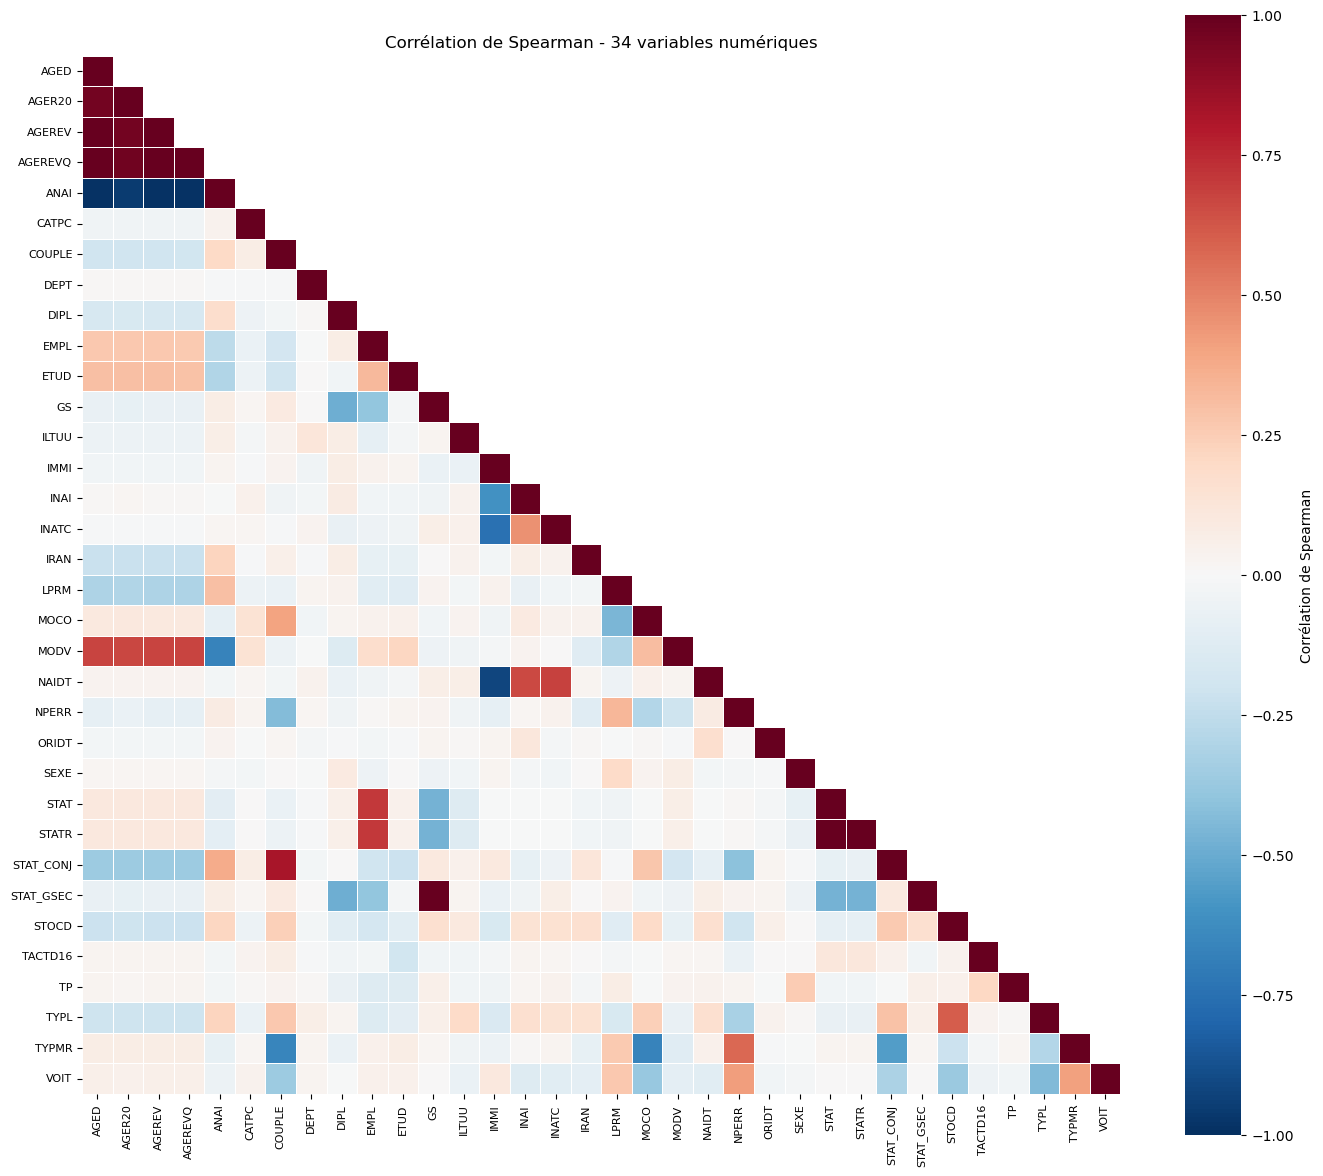


───────────────────────────────────────────────────────────────────────────
  [3] ASSOCIATIONS CATÉGORIELLES (V de Cramér) — OPTIMISÉ
───────────────────────────────────────────────────────────────────────────
    • Variables à analyser                     : 53
    • Échantillon : 50,000 observations
    • Encodage des catégories en cours...
    • Paires à calculer : 1,378
    • Calcul parallélisé sur 4 cores...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 849 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 1169 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1371 out of 1378 | elapsed:  1.3min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 1378 out of 1378 | elapsed:  1.3min finished



    ✓ Calcul terminé en 81.6 secondes
    ⚠ Paires avec V ≥ 0.5                      : 717
    • Temps de calcul                          : 81.6 secondes

    Top 15 associations catégorielles :
    ────────────────────────────────────────────────────────────
        • TYPMC                ↔ WC                   : V = 1.000
        • TYPC                 ↔ WC                   : V = 1.000
        • ACHLR                ↔ BAIN                 : V = 1.000
        • ACHLR                ↔ BATI                 : V = 1.000
        • ACHLR                ↔ CATL                 : V = 1.000
        • ACHLR                ↔ CHAU                 : V = 1.000
        • TDM8                 ↔ WC                   : V = 1.000
        • ACHLR                ↔ CHOS                 : V = 1.000
        • ACHLR                ↔ CLIM                 : V = 1.000
        • PCSL                 ↔ SANIDOM              : V = 1.000
        • APAF                 ↔ BAIN                 : V = 1.000
        • APA

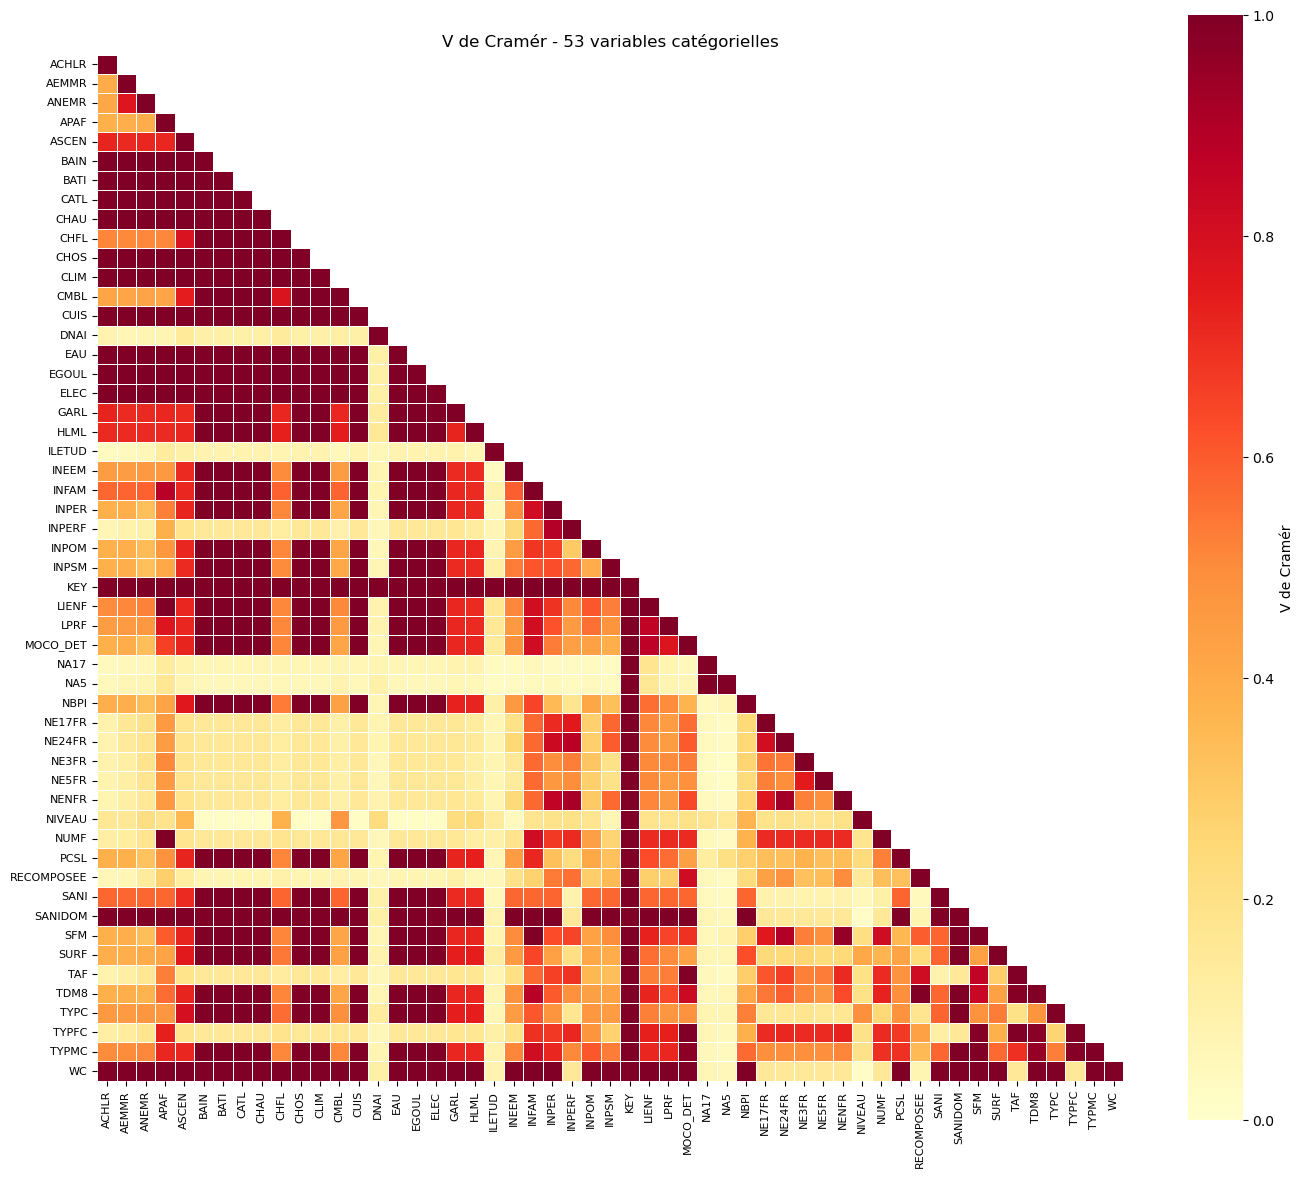


───────────────────────────────────────────────────────────────────────────
  [4] CLUSTERING HIÉRARCHIQUE
───────────────────────────────────────────────────────────────────────────

    ┌───────────────────────────────────────────────────────┐
    │ Variables numériques                                  │
    └───────────────────────────────────────────────────────┘


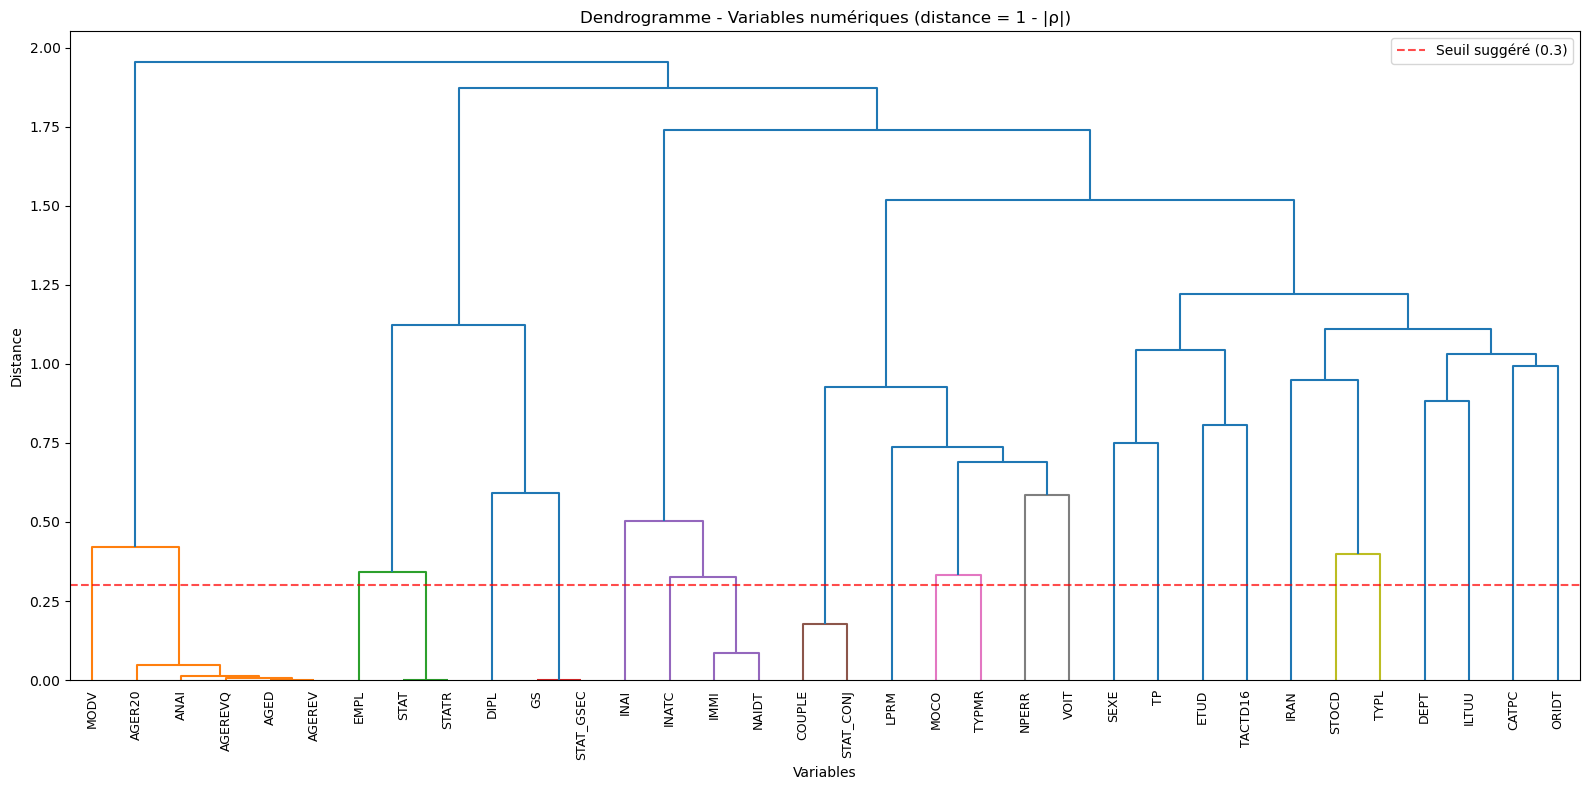


    Clusters avec variables multiples :
        Cluster 1 (6 vars) : AGED, AGER20, AGEREV, AGEREVQ, ANAI, MODV
        Cluster 2 (3 vars) : EMPL, STAT, STATR
        Cluster 3 (3 vars) : DIPL, GS, STAT_GSEC
        Cluster 4 (4 vars) : IMMI, INAI, INATC, NAIDT
        Cluster 5 (2 vars) : COUPLE, STAT_CONJ
        Cluster 6 (5 vars) : LPRM, MOCO, NPERR, TYPMR, VOIT
        Cluster 7 (2 vars) : SEXE, TP
        Cluster 10 (2 vars) : STOCD, TYPL

    ┌───────────────────────────────────────────────────────┐
    │ Variables catégorielles                               │
    └───────────────────────────────────────────────────────┘


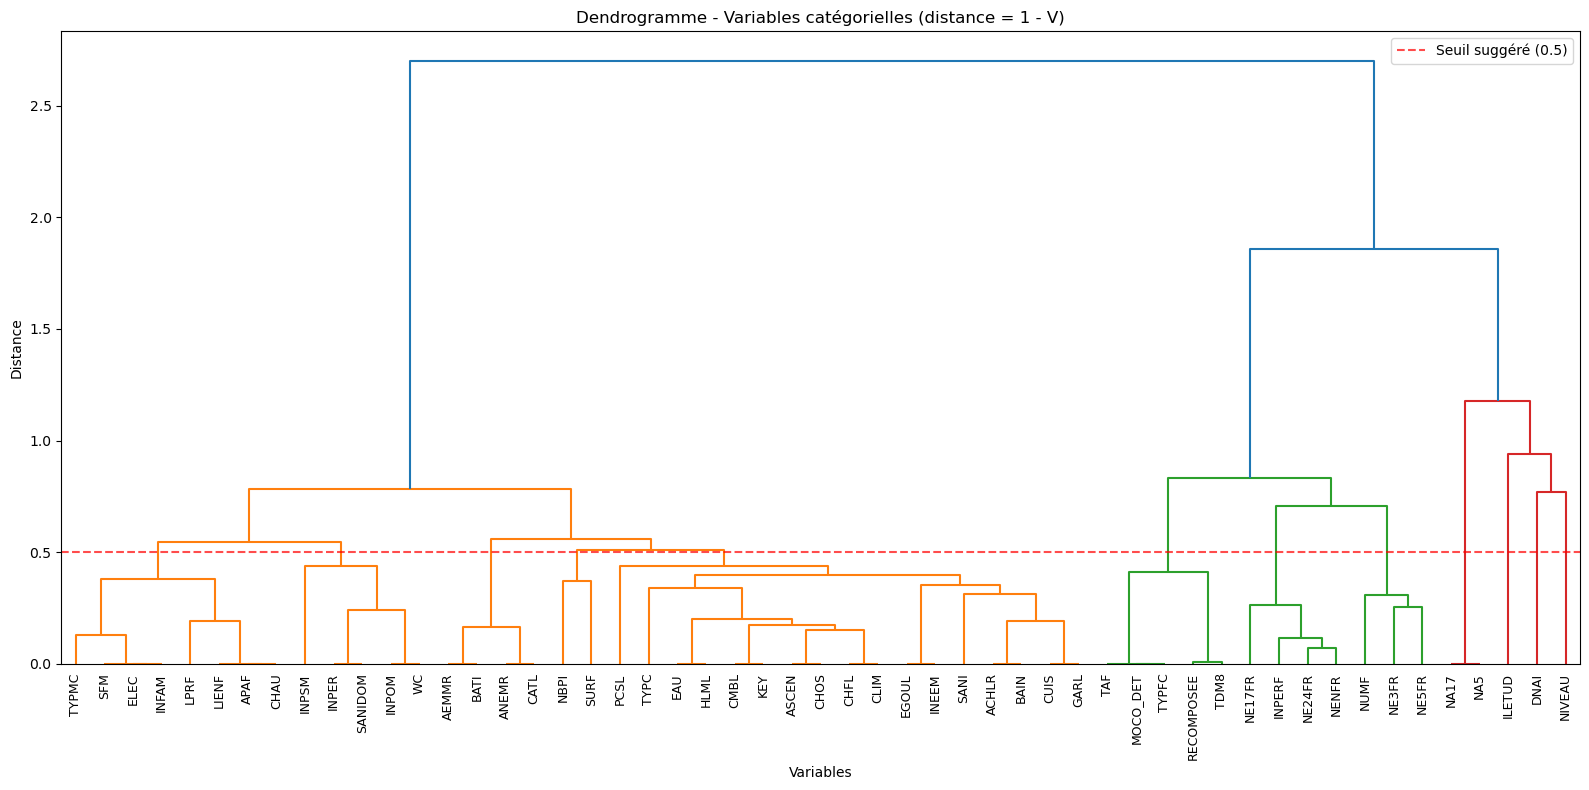


    Clusters avec variables multiples :
        Cluster 1 (8 vars) : APAF, CHAU, ELEC, INFAM, LIENF, LPRF, SFM, TYPMC
        Cluster 2 (4 vars) : INPER, INPOM, SANIDOM, WC
        Cluster 4 (4 vars) : AEMMR, ANEMR, BATI, CATL
        Cluster 5 (2 vars) : NBPI, SURF
        Cluster 6 (16 vars) : ACHLR, ASCEN, BAIN, CHFL, CHOS, CLIM, CMBL, CUIS, EAU, EGOUL, GARL, HLML, INEEM, KEY, SANI, TYPC
        Cluster 8 (3 vars) : MOCO_DET, TAF, TYPFC
        Cluster 9 (2 vars) : RECOMPOSEE, TDM8
        Cluster 10 (4 vars) : INPERF, NE17FR, NE24FR, NENFR
        Cluster 11 (3 vars) : NE3FR, NE5FR, NUMF
        Cluster 12 (2 vars) : NA17, NA5

───────────────────────────────────────────────────────────────────────────
  [5] VARIANCE INFLATION FACTOR (VIF)
───────────────────────────────────────────────────────────────────────────
    • Échantillon VIF : 50,000 observations
    • Calcul VIF pour 34 variables...
    ✗ VIF > 10.0 (fort)                        : 11
    ⚠ 5.0 < VIF ≤ 10.0 (modéré)    

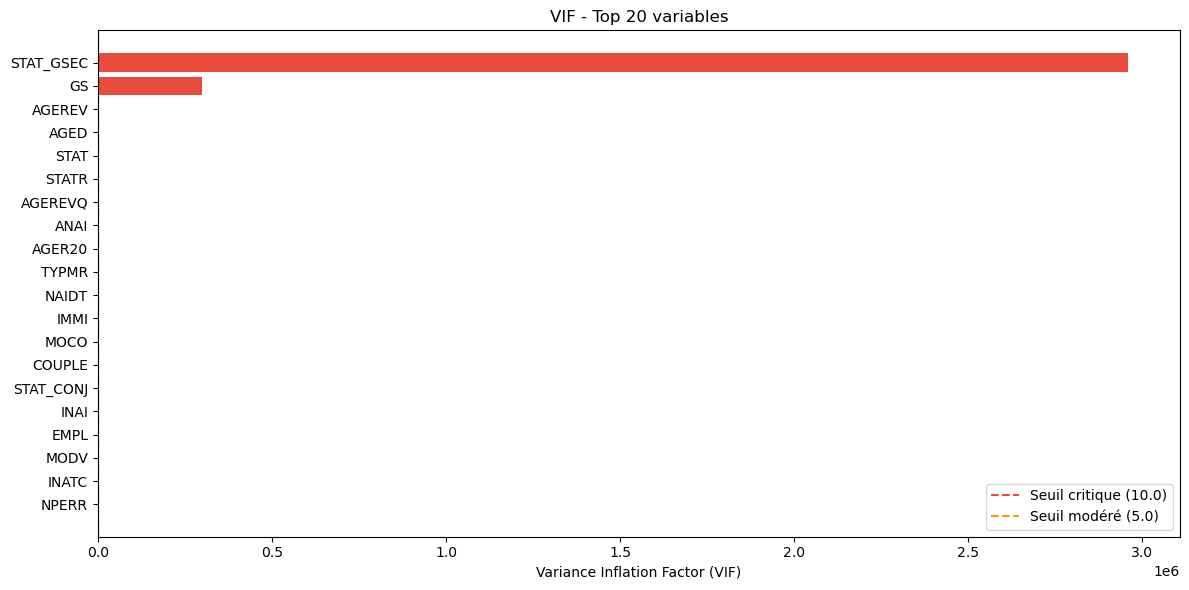


───────────────────────────────────────────────────────────────────────────
  [6] PANIERS DE REDONDANCE
───────────────────────────────────────────────────────────────────────────
    ⚠ Paniers identifiés                       : 6
    • Variables concernées                     : 68

    ╔═════════════════════════════════════════════════════════════════╗
    ║  PANIER 1 : 2 variables (Numérique)
    ║  Critère : |ρ| ≥ 0.7
    ╠═════════════════════════════════════════════════════════════════╣
    ║    • GS                             [NUM] (VIF = 298251.0)
    ║    • STAT_GSEC                      [NUM] (VIF = 2960139.1)
    ╠═════════════════════════════════════════════════════════════════╣
    ║  → ARBITRAGE REQUIS : conserver 1 variable sur 2
    ╚═════════════════════════════════════════════════════════════════╝

    ╔═════════════════════════════════════════════════════════════════╗
    ║  PANIER 2 : 5 variables (Numérique)
    ║  Critère : |ρ| ≥ 0.7
    ╠═════════════════════════

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
================================================================================
ANALYSE DE MULTICOLINÉARITÉ ET IDENTIFICATION DES PANIERS DE REDONDANCE
================================================================================
Projet INSEE - Mobilité Transfrontalière Grand Est
Auteur : Mehdi FEHRI
Date   : Janvier 2026

Ce script analyse les corrélations entre variables pour identifier les groupes
de variables redondantes nécessitant un arbitrage économique :
  • Corrélations de Spearman (numériques)
  • V de Cramér (catégorielles) — VERSION OPTIMISÉE ET PARALLÉLISÉE
  • Variance Inflation Factor (VIF)
  • Clustering hiérarchique
  • Constitution des paniers de redondance

OPTIMISATIONS :
  • V de Cramér calculé via scipy.stats.chi2_contingency (implémentation C)
  • Parallélisation via joblib (utilise tous les cores disponibles)
  • Encodage catégoriel en entiers pour accélérer les calculs
  • ~30× plus rapide que la version avec boucles Python
================================================================================
"""

import json
import time
import warnings
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Tuple, Any
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import spearmanr, chi2_contingency
from joblib import Parallel, delayed

warnings.filterwarnings('ignore')


# ==============================================================================
# CONFIGURATION
# ==============================================================================

@dataclass
class ColinearityConfig:
    """Configuration de l'analyse de colinéarité."""
    base_path: Path
    
    # Seuils d'analyse
    seuil_spearman: float = 0.70
    seuil_cramer: float = 0.50
    seuil_vif: float = 10.0
    seuil_vif_moderate: float = 5.0
    
    # Paramètres de calcul
    n_clusters: int = 15
    sample_size_cramer: int = 50_000
    sample_size_vif: int = 50_000
    n_jobs: int = -1  # -1 = tous les cores disponibles
    
    # Style des graphiques
    figsize_heatmap: Tuple[int, int] = (14, 12)
    figsize_dendro: Tuple[int, int] = (16, 8)
    figsize_vif: Tuple[int, int] = (12, 6)
    
    @property
    def input_raw(self) -> Path:
        return self.base_path / "X_raw_colinearity.csv"
    
    @property
    def input_types(self) -> Path:
        return self.base_path / "variable_types.json"


# ══════════════════════════════════════════════════════════════════════════════
# ADAPTER CE CHEMIN À VOTRE ENVIRONNEMENT
# ══════════════════════════════════════════════════════════════════════════════
CONFIG = ColinearityConfig(
    base_path=Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/ML_READY")
)


# ==============================================================================
# FONCTIONS D'AFFICHAGE
# ==============================================================================

def print_header(title: str, char: str = "═", width: int = 75) -> None:
    """Affiche un en-tête principal."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_section(step: int, title: str, char: str = "─", width: int = 75) -> None:
    """Affiche un séparateur de section numéroté."""
    print(f"\n{char * width}")
    print(f"  [{step}] {title}")
    print(f"{char * width}")


def print_subsection(title: str) -> None:
    """Affiche un sous-titre."""
    print(f"\n    ┌{'─' * 55}┐")
    print(f"    │ {title:<53} │")
    print(f"    └{'─' * 55}┘")


def print_stat(label: str, value: Any, indent: int = 4, status: str = "info") -> None:
    """Affiche une statistique formatée."""
    icons = {"ok": "✓", "warning": "⚠", "error": "✗", "info": "•"}
    icon = icons.get(status, "•")
    space = " " * indent
    
    if isinstance(value, (int, np.integer)):
        val_str = f"{value:,}"
    elif isinstance(value, float):
        val_str = f"{value:.3f}"
    else:
        val_str = str(value)
    
    print(f"{space}{icon} {label:<40} : {val_str}")


def print_pair(var1: str, var2: str, value: float, metric: str = "r") -> None:
    """Affiche une paire de variables corrélées."""
    print(f"        • {var1:<20} ↔ {var2:<20} : {metric} = {value:.3f}")


def print_panier(index: int, panier: Dict, num_cols: List[str], vif_df: pd.DataFrame) -> None:
    """Affiche un panier de redondance formaté."""
    vars_list = sorted(panier['variables'])
    
    print(f"\n    ╔{'═' * 65}╗")
    print(f"    ║  PANIER {index} : {len(vars_list)} variables ({panier['type']})")
    print(f"    ║  Critère : {panier['reason']}")
    print(f"    ╠{'═' * 65}╣")
    
    for var in vars_list:
        var_type = "NUM" if var in num_cols else "CAT"
        
        # Info VIF si disponible
        vif_info = ""
        if not vif_df.empty and var in vif_df['Variable'].values:
            vif_val = vif_df[vif_df['Variable'] == var]['VIF'].values[0]
            if not np.isnan(vif_val):
                vif_info = f" (VIF = ∞)" if np.isinf(vif_val) else f" (VIF = {vif_val:.1f})"
        
        print(f"    ║    • {var:<30} [{var_type}]{vif_info}")
    
    print(f"    ╠{'═' * 65}╣")
    print(f"    ║  → ARBITRAGE REQUIS : conserver 1 variable sur {len(vars_list)}")
    print(f"    ╚{'═' * 65}╝")


def print_summary_box(title: str, items: List[Tuple[str, str]]) -> None:
    """Affiche un encadré de résumé."""
    width = 60
    print(f"\n    ┌{'─' * width}┐")
    print(f"    │ {title:<{width-1}}│")
    print(f"    ├{'─' * width}┤")
    for label, value in items:
        line = f"{label:<35} : {value}"
        print(f"    │ {line:<{width-1}}│")
    print(f"    └{'─' * width}┘")


# ==============================================================================
# FONCTIONS DE CALCUL - V DE CRAMÉR OPTIMISÉ
# ==============================================================================

def cramers_v_fast(x: np.ndarray, y: np.ndarray) -> float:
    """
    Calcul optimisé du V de Cramér utilisant scipy.
    ~10-20× plus rapide que la version avec boucles Python.
    
    Parameters
    ----------
    x, y : Arrays numpy encodés en entiers (codes catégoriels)
    
    Returns
    -------
    V de Cramér entre 0 et 1
    """
    try:
        # Table de contingence via pandas (optimisé)
        contingency = pd.crosstab(x, y)
        
        if contingency.size == 0:
            return 0.0
        
        # Chi2 via scipy (implémentation C, très rapide)
        chi2, _, _, _ = chi2_contingency(contingency)
        
        n = contingency.sum().sum()
        min_dim = min(contingency.shape) - 1
        
        if min_dim <= 0 or n <= 1:
            return 0.0
        
        v = np.sqrt(chi2 / (n * min_dim))
        return min(v, 1.0)
    
    except Exception:
        return 0.0


def compute_single_cramer_pair(i: int, j: int, data: np.ndarray) -> Tuple[int, int, float]:
    """
    Calcule le V de Cramér pour une paire d'indices.
    Fonction utilisée pour la parallélisation.
    """
    v = cramers_v_fast(data[:, i], data[:, j])
    return (i, j, v)


def compute_cramer_matrix_fast(
    df: pd.DataFrame, 
    cat_cols: List[str], 
    sample_size: int = 50_000,
    seuil: float = 0.50,
    n_jobs: int = -1
) -> Tuple[pd.DataFrame, pd.DataFrame, float]:
    """
    Calcul optimisé et parallélisé de la matrice de V de Cramér.
    
    Parameters
    ----------
    df : DataFrame avec les données
    cat_cols : Liste des colonnes catégorielles
    sample_size : Taille de l'échantillon (pour performance)
    seuil : Seuil pour identifier les paires fortes
    n_jobs : Nombre de jobs parallèles (-1 = tous les cores)
    
    Returns
    -------
    cramer_df : Matrice complète de V de Cramér
    high_cramer_df : Paires au-dessus du seuil
    elapsed : Temps de calcul en secondes
    """
    start = time.time()
    
    if len(cat_cols) < 2:
        return pd.DataFrame(), pd.DataFrame(), 0.0
    
    # Échantillonnage pour performance
    if len(df) > sample_size:
        df_sample = df[cat_cols].sample(n=sample_size, random_state=42)
        print(f"    • Échantillon : {sample_size:,} observations")
    else:
        df_sample = df[cat_cols].copy()
        print(f"    • Observations : {len(df_sample):,} (pas d'échantillonnage)")
    
    # Encodage des catégories en entiers (beaucoup plus rapide)
    print(f"    • Encodage des catégories en cours...")
    data_encoded = np.column_stack([
        pd.Categorical(df_sample[col].astype(str)).codes 
        for col in cat_cols
    ])
    
    n_vars = len(cat_cols)
    n_pairs = n_vars * (n_vars - 1) // 2
    print(f"    • Paires à calculer : {n_pairs:,}")
    
    # Déterminer le nombre de cores
    if n_jobs == -1:
        import os
        n_cores = os.cpu_count() or 1
    else:
        n_cores = n_jobs
    print(f"    • Calcul parallélisé sur {n_cores} cores...")
    
    # Générer toutes les paires d'indices
    pairs = list(combinations(range(n_vars), 2))
    
    # Calcul parallèle avec barre de progression
    results = Parallel(n_jobs=n_jobs, verbose=5)(
        delayed(compute_single_cramer_pair)(i, j, data_encoded)
        for i, j in pairs
    )
    
    # Construire la matrice symétrique
    cramer_matrix = np.eye(n_vars)
    for i, j, v in results:
        cramer_matrix[i, j] = v
        cramer_matrix[j, i] = v
    
    cramer_df = pd.DataFrame(cramer_matrix, index=cat_cols, columns=cat_cols)
    
    # Identifier les paires fortes
    high_pairs = [
        {'Variable_1': cat_cols[i], 'Variable_2': cat_cols[j], 'Cramer_V': v}
        for i, j, v in results if v >= seuil
    ]
    
    high_cramer_df = pd.DataFrame(high_pairs)
    if not high_cramer_df.empty:
        high_cramer_df = high_cramer_df.sort_values('Cramer_V', ascending=False)
    
    elapsed = time.time() - start
    print(f"\n    ✓ Calcul terminé en {elapsed:.1f} secondes")
    
    return cramer_df, high_cramer_df, elapsed


# ==============================================================================
# FONCTIONS DE CALCUL - SPEARMAN
# ==============================================================================

def compute_spearman_matrix(
    df: pd.DataFrame, 
    num_cols: List[str],
    seuil: float = 0.70
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Calcule la matrice de corrélation de Spearman et identifie les paires fortes.
    """
    if len(num_cols) < 2:
        return pd.DataFrame(), pd.DataFrame()
    
    df_num = df[num_cols].replace([np.inf, -np.inf], np.nan)
    
    # Calcul de la matrice via scipy
    corr_matrix, _ = spearmanr(df_num, nan_policy='omit')
    
    if np.isscalar(corr_matrix):
        corr_matrix = np.array([[1, corr_matrix], [corr_matrix, 1]])
    
    corr_df = pd.DataFrame(corr_matrix, index=num_cols, columns=num_cols).fillna(0)
    
    # Identification des paires fortes
    high_pairs = []
    for i, col1 in enumerate(num_cols):
        for j, col2 in enumerate(num_cols):
            if i < j:
                r = corr_df.loc[col1, col2]
                if abs(r) >= seuil:
                    high_pairs.append({
                        'Variable_1': col1,
                        'Variable_2': col2,
                        'Correlation': r
                    })
    
    high_corr_df = pd.DataFrame(high_pairs)
    if not high_corr_df.empty:
        high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    
    return corr_df, high_corr_df


# ==============================================================================
# FONCTIONS DE CALCUL - VIF
# ==============================================================================

def compute_vif(
    df: pd.DataFrame, 
    num_cols: List[str], 
    sample_size: int,
    seuil: float = 10.0
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Calcule le VIF pour les variables numériques."""
    try:
        from statsmodels.stats.outliers_influence import variance_inflation_factor
    except ImportError:
        print("    ⚠ statsmodels non installé — pip install statsmodels")
        return pd.DataFrame(), pd.DataFrame()
    
    if len(num_cols) < 2:
        return pd.DataFrame(), pd.DataFrame()
    
    # Filtrer les colonnes avec trop de NaN
    df_vif = df[num_cols].copy()
    valid_cols = [c for c in num_cols if df_vif[c].isna().mean() < 0.10]
    
    if len(valid_cols) < 2:
        return pd.DataFrame(), pd.DataFrame()
    
    df_vif = df_vif[valid_cols].dropna()
    
    # Échantillonnage pour performance
    if len(df_vif) > sample_size:
        df_vif = df_vif.sample(n=sample_size, random_state=42)
        print(f"    • Échantillon VIF : {sample_size:,} observations")
    
    print(f"    • Calcul VIF pour {len(valid_cols)} variables...")
    
    # Calcul VIF
    vif_data = []
    X = df_vif.values
    
    for i, col in enumerate(valid_cols):
        try:
            vif = variance_inflation_factor(X, i)
            vif_data.append({'Variable': col, 'VIF': vif})
        except Exception:
            vif_data.append({'Variable': col, 'VIF': np.nan})
    
    vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)
    high_vif = vif_df[vif_df['VIF'] > seuil].copy()
    
    return vif_df, high_vif


# ==============================================================================
# FONCTIONS DE CALCUL - CLUSTERING
# ==============================================================================

def perform_hierarchical_clustering(
    dist_matrix: np.ndarray, 
    labels: List[str], 
    title: str, 
    threshold: float,
    figsize: Tuple[int, int] = (16, 8),
    n_clusters: int = 15
) -> pd.DataFrame:
    """Effectue un clustering hiérarchique et retourne les clusters."""
    if len(labels) < 3:
        return pd.DataFrame()
    
    # Préparer la matrice de distance
    dist_array = dist_matrix.copy()
    dist_array = (dist_array + dist_array.T) / 2
    np.fill_diagonal(dist_array, 0.0)
    dist_array = np.nan_to_num(dist_array, nan=1.0)
    dist_array = np.clip(dist_array, 0.0, 1.0)
    
    # Format condensé pour linkage
    n = len(labels)
    condensed = [dist_array[i, j] for i in range(n) for j in range(i + 1, n)]
    condensed = np.array(condensed, dtype=np.float64)
    
    # Linkage hiérarchique
    linkage_matrix = linkage(condensed, method='ward')
    
    # Dendrogramme
    plt.figure(figsize=figsize)
    dendrogram(
        linkage_matrix, 
        labels=labels, 
        leaf_rotation=90, 
        leaf_font_size=9,
        color_threshold=threshold * max(linkage_matrix[:, 2])
    )
    plt.title(title)
    plt.xlabel('Variables')
    plt.ylabel('Distance')
    plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, 
                label=f'Seuil suggéré ({threshold})')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Extraction des clusters
    n_clust = min(n_clusters, len(labels) - 1)
    clusters = fcluster(linkage_matrix, t=n_clust, criterion='maxclust')
    
    return pd.DataFrame({'Variable': labels, 'Cluster': clusters})


# ==============================================================================
# FONCTIONS DE CALCUL - PANIERS DE REDONDANCE
# ==============================================================================

def build_redundancy_baskets(
    high_corr_df: pd.DataFrame, 
    high_cramer_df: pd.DataFrame,
    seuil_spearman: float,
    seuil_cramer: float
) -> List[Dict]:
    """Construit les paniers de variables redondantes."""
    paniers = []
    
    # Ajouter paires numériques
    if not high_corr_df.empty:
        for _, row in high_corr_df.iterrows():
            var1, var2 = row['Variable_1'], row['Variable_2']
            found = False
            for panier in paniers:
                if var1 in panier['variables'] or var2 in panier['variables']:
                    panier['variables'].add(var1)
                    panier['variables'].add(var2)
                    found = True
                    break
            if not found:
                paniers.append({
                    'variables': {var1, var2},
                    'type': 'Numérique',
                    'metric': 'Spearman',
                    'reason': f'|ρ| ≥ {seuil_spearman}'
                })
    
    # Ajouter paires catégorielles
    if not high_cramer_df.empty:
        for _, row in high_cramer_df.iterrows():
            var1, var2 = row['Variable_1'], row['Variable_2']
            found = False
            for panier in paniers:
                if var1 in panier['variables'] or var2 in panier['variables']:
                    panier['variables'].add(var1)
                    panier['variables'].add(var2)
                    found = True
                    break
            if not found:
                paniers.append({
                    'variables': {var1, var2},
                    'type': 'Catégorielle',
                    'metric': 'V de Cramér',
                    'reason': f'V ≥ {seuil_cramer}'
                })
    
    # Fusionner les paniers qui partagent des variables
    merged = True
    while merged:
        merged = False
        new_paniers = []
        used = set()
        
        for i, p1 in enumerate(paniers):
            if i in used:
                continue
            
            current_vars = p1['variables'].copy()
            current_types = {p1['type']}
            current_reasons = {p1['reason']}
            
            for j, p2 in enumerate(paniers):
                if j > i and j not in used:
                    if current_vars & p2['variables']:
                        current_vars |= p2['variables']
                        current_types.add(p2['type'])
                        current_reasons.add(p2['reason'])
                        used.add(j)
                        merged = True
            
            new_paniers.append({
                'variables': current_vars,
                'type': ' / '.join(sorted(current_types)),
                'metric': 'Multiple' if len(current_types) > 1 else p1['metric'],
                'reason': ' & '.join(sorted(current_reasons))
            })
            used.add(i)
        
        paniers = new_paniers
    
    return paniers


# ==============================================================================
# FONCTIONS DE VISUALISATION
# ==============================================================================

def plot_correlation_heatmap(
    corr_df: pd.DataFrame, 
    title: str, 
    cmap: str = 'RdBu_r',
    figsize: Tuple[int, int] = (14, 12)
) -> None:
    """Affiche une heatmap de corrélation."""
    if corr_df.empty or len(corr_df) < 2:
        return
    
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_df, dtype=bool), k=1)
    
    annot = len(corr_df) <= 20
    sns.heatmap(
        corr_df, 
        mask=mask, 
        annot=annot, 
        cmap=cmap,
        center=0 if 'RdBu' in cmap else None,
        fmt='.2f', 
        square=True, 
        linewidths=0.5,
        vmin=-1 if 'RdBu' in cmap else 0,
        vmax=1,
        cbar_kws={'label': title.split(' - ')[0]},
        annot_kws={'size': 8} if annot else {}
    )
    
    plt.title(title)
    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_vif_barplot(
    vif_df: pd.DataFrame, 
    seuil_vif: float = 10.0,
    seuil_moderate: float = 5.0,
    figsize: Tuple[int, int] = (12, 6)
) -> None:
    """Affiche un graphique en barres des VIF."""
    if vif_df.empty:
        return
    
    plt.figure(figsize=figsize)
    
    vif_plot = vif_df.head(20).copy()
    colors = [
        '#e74c3c' if v > seuil_vif else '#f39c12' if v > seuil_moderate else '#27ae60'
        for v in vif_plot['VIF']
    ]
    
    plt.barh(vif_plot['Variable'], vif_plot['VIF'], color=colors)
    plt.axvline(x=seuil_vif, color='#e74c3c', linestyle='--', 
                label=f'Seuil critique ({seuil_vif})')
    plt.axvline(x=seuil_moderate, color='#f39c12', linestyle='--',
                label=f'Seuil modéré ({seuil_moderate})')
    
    plt.xlabel('Variance Inflation Factor (VIF)')
    plt.title('VIF - Top 20 variables')
    plt.legend(loc='lower right')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# ==============================================================================
# PIPELINE PRINCIPAL
# ==============================================================================

def main():
    """Pipeline principal d'analyse de colinéarité."""
    
    print_header("ANALYSE DE MULTICOLINÉARITÉ (VERSION OPTIMISÉE)")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 1 : Chargement des données
    # ──────────────────────────────────────────────────────────────────────────
    print_section(1, "CHARGEMENT DES DONNÉES")
    
    if not CONFIG.input_raw.exists():
        raise FileNotFoundError(f"Fichier introuvable : {CONFIG.input_raw}")
    
    df = pd.read_csv(CONFIG.input_raw)
    
    with open(CONFIG.input_types, 'r') as f:
        var_types = json.load(f)
    
    num_cols = [c for c in var_types['numeric'] if c in df.columns]
    cat_cols = [c for c in var_types['categorical'] if c in df.columns]
    
    print_stat("Observations", len(df), status="ok")
    print_stat("Variables numériques", len(num_cols), status="info")
    print_stat("Variables catégorielles", len(cat_cols), status="info")
    print_stat("Total variables", len(num_cols) + len(cat_cols), status="ok")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 2 : Corrélations numériques (Spearman)
    # ──────────────────────────────────────────────────────────────────────────
    print_section(2, "CORRÉLATIONS NUMÉRIQUES (Spearman)")
    
    corr_df, high_corr_df = compute_spearman_matrix(df, num_cols, CONFIG.seuil_spearman)
    
    if not corr_df.empty:
        print_stat("Matrice calculée", f"{len(corr_df)} × {len(corr_df)}", status="ok")
        print_stat(f"Paires avec |ρ| ≥ {CONFIG.seuil_spearman}", len(high_corr_df), 
                   status="warning" if len(high_corr_df) > 0 else "ok")
        
        if not high_corr_df.empty:
            print(f"\n    Top 15 paires les plus corrélées :")
            print(f"    {'─' * 60}")
            for _, row in high_corr_df.head(15).iterrows():
                print_pair(row['Variable_1'], row['Variable_2'], row['Correlation'], "ρ")
        
        # Heatmap
        plot_correlation_heatmap(
            corr_df, 
            f'Corrélation de Spearman - {len(num_cols)} variables numériques',
            figsize=CONFIG.figsize_heatmap
        )
    else:
        print("    ⚠ Moins de 2 variables numériques")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 3 : Associations catégorielles (V de Cramér) — OPTIMISÉ
    # ──────────────────────────────────────────────────────────────────────────
    print_section(3, "ASSOCIATIONS CATÉGORIELLES (V de Cramér) — OPTIMISÉ")
    
    if len(cat_cols) >= 2:
        print_stat("Variables à analyser", len(cat_cols), status="info")
        
        cramer_df, high_cramer_df, elapsed = compute_cramer_matrix_fast(
            df, 
            cat_cols, 
            sample_size=CONFIG.sample_size_cramer,
            seuil=CONFIG.seuil_cramer,
            n_jobs=CONFIG.n_jobs
        )
        
        print_stat(f"Paires avec V ≥ {CONFIG.seuil_cramer}", len(high_cramer_df),
                   status="warning" if len(high_cramer_df) > 0 else "ok")
        print_stat("Temps de calcul", f"{elapsed:.1f} secondes", status="info")
        
        if not high_cramer_df.empty:
            print(f"\n    Top 15 associations catégorielles :")
            print(f"    {'─' * 60}")
            for _, row in high_cramer_df.head(15).iterrows():
                print_pair(row['Variable_1'], row['Variable_2'], row['Cramer_V'], "V")
        
        # Heatmap
        plot_correlation_heatmap(
            cramer_df, 
            f'V de Cramér - {len(cat_cols)} variables catégorielles', 
            'YlOrRd',
            figsize=CONFIG.figsize_heatmap
        )
    else:
        cramer_df, high_cramer_df = pd.DataFrame(), pd.DataFrame()
        print("    ⚠ Moins de 2 variables catégorielles")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 4 : Clustering hiérarchique
    # ──────────────────────────────────────────────────────────────────────────
    print_section(4, "CLUSTERING HIÉRARCHIQUE")
    
    clusters_num_df = pd.DataFrame()
    clusters_cat_df = pd.DataFrame()
    
    # Numériques
    if not corr_df.empty and len(corr_df) > 2:
        print_subsection("Variables numériques")
        dist_matrix = 1.0 - np.abs(corr_df.values)
        clusters_num_df = perform_hierarchical_clustering(
            dist_matrix, 
            num_cols,
            'Dendrogramme - Variables numériques (distance = 1 - |ρ|)',
            threshold=0.3,
            figsize=CONFIG.figsize_dendro,
            n_clusters=CONFIG.n_clusters
        )
        
        # Afficher clusters multi-variables
        print(f"\n    Clusters avec variables multiples :")
        for c in sorted(clusters_num_df['Cluster'].unique()):
            vars_in = clusters_num_df[clusters_num_df['Cluster'] == c]['Variable'].tolist()
            if len(vars_in) > 1:
                print(f"        Cluster {c} ({len(vars_in)} vars) : {', '.join(vars_in)}")
    
    # Catégorielles
    if not cramer_df.empty and len(cramer_df) > 2:
        print_subsection("Variables catégorielles")
        dist_matrix = 1.0 - cramer_df.values
        clusters_cat_df = perform_hierarchical_clustering(
            dist_matrix, 
            cat_cols,
            'Dendrogramme - Variables catégorielles (distance = 1 - V)',
            threshold=0.5,
            figsize=CONFIG.figsize_dendro,
            n_clusters=CONFIG.n_clusters
        )
        
        print(f"\n    Clusters avec variables multiples :")
        for c in sorted(clusters_cat_df['Cluster'].unique()):
            vars_in = clusters_cat_df[clusters_cat_df['Cluster'] == c]['Variable'].tolist()
            if len(vars_in) > 1:
                print(f"        Cluster {c} ({len(vars_in)} vars) : {', '.join(vars_in)}")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 5 : Variance Inflation Factor (VIF)
    # ──────────────────────────────────────────────────────────────────────────
    print_section(5, "VARIANCE INFLATION FACTOR (VIF)")
    
    vif_df, high_vif = compute_vif(df, num_cols, CONFIG.sample_size_vif, CONFIG.seuil_vif)
    
    if not vif_df.empty:
        n_high = len(high_vif)
        n_moderate = len(vif_df[
            (vif_df['VIF'] > CONFIG.seuil_vif_moderate) & 
            (vif_df['VIF'] <= CONFIG.seuil_vif)
        ])
        n_ok = len(vif_df) - n_high - n_moderate
        
        print_stat(f"VIF > {CONFIG.seuil_vif} (fort)", n_high, 
                   status="error" if n_high > 0 else "ok")
        print_stat(f"{CONFIG.seuil_vif_moderate} < VIF ≤ {CONFIG.seuil_vif} (modéré)", n_moderate,
                   status="warning" if n_moderate > 0 else "ok")
        print_stat(f"VIF ≤ {CONFIG.seuil_vif_moderate} (acceptable)", n_ok, status="ok")
        
        if n_high > 0:
            print(f"\n    ⚠ Variables avec VIF critique :")
            print(f"    {'─' * 50}")
            for _, row in high_vif.iterrows():
                vif_val = row['VIF']
                vif_str = "∞" if np.isinf(vif_val) else f"{vif_val:.1f}"
                print(f"        • {row['Variable']:<30} : VIF = {vif_str}")
        
        # Graphique
        plot_vif_barplot(vif_df, CONFIG.seuil_vif, CONFIG.seuil_vif_moderate, CONFIG.figsize_vif)
    else:
        print("    ⚠ Calcul VIF non disponible")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 6 : Constitution des paniers de redondance
    # ──────────────────────────────────────────────────────────────────────────
    print_section(6, "PANIERS DE REDONDANCE")
    
    paniers = build_redundancy_baskets(
        high_corr_df, 
        high_cramer_df, 
        CONFIG.seuil_spearman,
        CONFIG.seuil_cramer
    )
    
    if paniers:
        n_vars_in_paniers = sum(len(p['variables']) for p in paniers)
        print_stat("Paniers identifiés", len(paniers), status="warning")
        print_stat("Variables concernées", n_vars_in_paniers, status="info")
        
        for i, panier in enumerate(paniers, 1):
            print_panier(i, panier, num_cols, vif_df)
    else:
        print("    ✓ Aucun panier de redondance critique identifié")
    
    # ──────────────────────────────────────────────────────────────────────────
    # RÉSUMÉ FINAL
    # ──────────────────────────────────────────────────────────────────────────
    print_header("RÉSUMÉ DE L'ANALYSE", char="─")
    
    print_summary_box("DONNÉES ANALYSÉES", [
        ("Observations", f"{len(df):,}"),
        ("Variables numériques", str(len(num_cols))),
        ("Variables catégorielles", str(len(cat_cols))),
        ("Total", str(len(num_cols) + len(cat_cols)))
    ])
    
    print_summary_box("CORRÉLATIONS NUMÉRIQUES (Spearman)", [
        ("Seuil appliqué", f"|ρ| ≥ {CONFIG.seuil_spearman}"),
        ("Paires détectées", str(len(high_corr_df)))
    ])
    
    print_summary_box("ASSOCIATIONS CATÉGORIELLES (V de Cramér)", [
        ("Seuil appliqué", f"V ≥ {CONFIG.seuil_cramer}"),
        ("Paires détectées", str(len(high_cramer_df)))
    ])
    
    print_summary_box("VARIANCE INFLATION FACTOR", [
        ("Seuil critique", f"VIF > {CONFIG.seuil_vif}"),
        ("Variables problématiques", str(len(high_vif)))
    ])
    
    print_summary_box("PANIERS DE REDONDANCE", [
        ("Nombre de paniers", str(len(paniers))),
        ("Variables à arbitrer", str(sum(len(p['variables']) for p in paniers)))
    ])
    
    # Prochaines étapes
    print(f"""
    ┌{'─' * 65}┐
    │  PROCHAINES ÉTAPES                                              │
    ├{'─' * 65}┤
    │  1. Effectuer les arbitrages économiques sur chaque panier      │
    │  2. Documenter les justifications (théorie, interprétabilité)   │
    │  3. Constituer la liste finale des variables                    │
    │  4. Mettre à jour la préparation ML avec les exclusions         │
    └{'─' * 65}┘
    """)
    
    # Retour des résultats pour utilisation ultérieure
    return {
        'corr_df': corr_df,
        'cramer_df': cramer_df,
        'high_corr_df': high_corr_df,
        'high_cramer_df': high_cramer_df,
        'vif_df': vif_df,
        'high_vif': high_vif,
        'clusters_num_df': clusters_num_df,
        'clusters_cat_df': clusters_cat_df,
        'paniers': paniers
    }


# ==============================================================================
# EXÉCUTION
# ==============================================================================

if __name__ == "__main__":
    results = main()

## Analyse de multicolinéarité et arbitrages économiques

Cette section documente les arbitrages réalisés pour résoudre les problèmes de multicolinéarité identifiés lors du diagnostic. Chaque décision est justifiée sur des critères économiques, d'interprétabilité et de parcimonie.

---

### Diagnostic synthétique

| Indicateur                  | Seuil        | Résultat       |
|-----------------------------|--------------|----------------|
| Corrélations Spearman       | \|ρ\| ≥ 0.70 | 17 paires      |
| Associations V de Cramér    | V ≥ 0.50     | 665 paires     |
| VIF critique                | VIF > 10     | 11 variables   |
| Paniers de redondance       | —            | 7 paniers      |
| Variables concernées        | —            | 64 variables   |

---

### Synthèse des arbitrages

| Panier | Thématique              | Variables en concurrence | Décision           |
|--------|-------------------------|--------------------------|---------------------|
| 1      | Catégorie socioprofessionnelle | GS, STAT_GSEC            | **GS**              |
| 2      | Âge                     | AGED, AGER20, AGEREV, AGEREVQ, ANAI | **AGEREV + AGEREV²** |
| 3      | Statut professionnel    | EMPL, STAT, STATR        | **EMPL + STATR**    |
| 4      | Immigration / Nationalité | IMMI, INATC, NAIDT       | **INATC**           |
| 5      | Situation conjugale     | COUPLE, STAT_CONJ        | **COUPLE**          |
| 6      | Structure familiale     | 47 variables             | **NENFR + TAF**     |
| 7      | Secteur d'activité      | NA5, NA17                | **NA5**             |

---

### Détail des arbitrages

#### Panier 1 — Catégorie socioprofessionnelle

**Corrélation** : GS ↔ STAT_GSEC (ρ = 1.00)

| Variable   | VIF         | Description                                      |
|------------|-------------|--------------------------------------------------|
| **GS**     | 298 251     | Groupe socioprofessionnel (6 postes)             |
| STAT_GSEC  | 2 960 139   | Statut selon groupe socioprofessionnel           |

**Décision** : conserver **GS**

STAT_GSEC croise le statut d'activité avec la PCS. Sur une base d'actifs occupés uniquement, cette distinction devient redondante. GS constitue la nomenclature INSEE de référence dans la littérature sur la mobilité professionnelle et offre une interprétation directe en six catégories.

---

#### Panier 2 — Âge

**Corrélations** : AGED ↔ AGEREV (ρ = 1.00), AGEREV ↔ ANAI (ρ = −0.99)

| Variable   | VIF   | Description                        |
|------------|-------|------------------------------------|
| AGED       | 3 171 | Âge (différence de millésimes)     |
| **AGEREV** | 3 182 | Âge en années révolues             |
| AGEREVQ    | 94    | Âge quinquennal                    |
| AGER20     | 17    | Âge en 13 classes                  |
| ANAI       | 54    | Année de naissance                 |

**Décision** : conserver **AGEREV** et créer **AGEREV²**

La littérature établit une relation en U inversé entre âge et mobilité transfrontalière : croissance jusqu'à 35-50 ans, puis déclin. Une spécification quadratique capture cet effet de cycle de vie. Les versions discrétisées (AGEREVQ, AGER20) perdent la granularité nécessaire à l'estimation du terme quadratique.

---

#### Panier 3 — Statut professionnel

**Corrélations** : STAT ↔ STATR (ρ = 0.999), EMPL ↔ STAT (ρ = 0.70)

| Variable   | VIF   | Description                                 |
|------------|-------|---------------------------------------------|
| **EMPL**   | 5.9   | Condition d'emploi (CDI, CDD, intérim, …)   |
| STAT       | 464.6 | Statut professionnel détaillé               |
| **STATR**  | 452.7 | Statut regroupé (salarié / non-salarié)     |

**Décision** : conserver **EMPL + STATR**

Ces deux variables capturent des dimensions complémentaires. STATR distingue salariés et indépendants, dimension structurante pour le travail transfrontalier (fiscalité, protection sociale). EMPL mesure la précarité contractuelle, facteur influençant la propension à la mobilité longue distance.

---

#### Panier 4 — Immigration et nationalité

**Corrélations** : IMMI ↔ NAIDT (ρ = −0.92), IMMI ↔ INATC (ρ = −0.75)

| Variable   | VIF  | Description                              |
|------------|------|------------------------------------------|
| IMMI       | 9.4  | Statut d'immigré                         |
| **INATC**  | 2.3  | Nationalité (Français / Étranger)        |
| NAIDT      | 12.9 | Naissance dans un DOM-TOM-COM            |

**Décision** : conserver **INATC**

Dans le Grand Est, la distinction Français/Étranger est plus pertinente que le statut d'immigré pour analyser les comportements de mobilité transfrontalière. NAIDT concerne les DOM-TOM et s'avère quasi-constant dans cette région.

---

#### Panier 5 — Situation conjugale

**Corrélation** : COUPLE ↔ STAT_CONJ (ρ = 0.82)

| Variable    | VIF | Description                                    |
|-------------|-----|------------------------------------------------|
| **COUPLE**  | 7.9 | Vie en couple (oui / non)                      |
| STAT_CONJ   | 6.0 | Statut conjugal détaillé                       |

**Décision** : conserver **COUPLE**

L'objectif est de tester si la vie en couple influence la décision de travail transfrontalier, indépendamment de la forme juridique de l'union. Cette variable binaire assure la cohérence avec le modèle 3 (probit bivarié sur les couples).

---

#### Panier 6 — Structure familiale (47 variables)

Ce panier regroupe des variables sur la composition du ménage, les équipements du logement et la structure familiale. Le clustering révèle plusieurs sous-groupes fortement associés (V = 1.00 entre certaines paires).

**Décision** : conserver **NENFR + TAF**

| Variable conservée | Justification                                              |
|--------------------|------------------------------------------------------------|
| **NENFR**          | Nombre d'enfants — effet marginal interprétable            |
| **TAF**            | Type de famille (4 modalités : couple sans enfant, monoparentale, traditionnelle, recomposée) |

**Variables exclues** :

| Catégorie            | Variables                          | Motif d'exclusion                     |
|----------------------|------------------------------------|---------------------------------------|
| Équipements DOM      | BAIN, WC, ELEC, EAU, CHOS, CLIM, … | Quasi-constantes en métropole         |
| Taille logement      | NBPI, SURF                         | Proxy du revenu (capturé par GS)      |
| Composition ménage   | INPER, INPERF, NE17FR, NE24FR      | Redondantes avec NENFR                |
| Structure familiale  | TYPMC, SFM, TYPFC, MOCO_DET        | Redondantes avec TAF                  |

---

#### Panier 7 — Secteur d'activité

**Association** : V de Cramér élevé (NA17 est un raffinement de NA5)

| Variable | Modalités | Description                      |
|----------|-----------|----------------------------------|
| **NA5**  | 5         | Secteur regroupé                 |
| NA17     | 17        | Secteur détaillé                 |

**Décision** : conserver **NA5** (NA17 en robustesse)

NA5 offre une classification suffisante pour capturer les grandes tendances sectorielles du travail transfrontalier (industrie vers l'Allemagne, services vers le Luxembourg). NA17 sera utilisée dans les analyses de robustesse pour isoler des effets fins.

---

### Variables retenues pour la modélisation

#### Issues des arbitrages

| Catégorie               | Variable(s)        | Forme               |
|-------------------------|--------------------|---------------------|
| Catégorie socioprofessionnelle | GS                 | Catégorielle (6)    |
| Âge                     | AGEREV, AGEREV²    | Continue + quadratique |
| Statut professionnel    | EMPL, STATR        | Catégorielles       |
| Nationalité             | INATC              | Binaire             |
| Situation conjugale     | COUPLE             | Binaire             |
| Enfants                 | NENFR              | Discrète            |
| Structure familiale     | TAF                | Catégorielle (4)    |
| Secteur d'activité      | NA5                | Catégorielle (5)    |

#### Hors paniers de redondance

| Variable | Description                        | VIF  |
|----------|------------------------------------|------|
| SEXE     | Genre                              | 1.13 |
| DIPL     | Niveau de diplôme                  | 1.31 |
| DEPT     | Département de résidence           | 1.02 |
| VOIT     | Motorisation du ménage             | 1.54 |
| STOCD    | Statut d'occupation du logement    | 1.65 |
| TP       | Temps de travail                   | 1.14 |
| IRAN     | Mobilité résidentielle récente     | 1.09 |

---

### Variables exclues

#### Pour redondance (VIF élevé ou corrélation forte)

| Variable exclue | Remplacée par    |
|-----------------|------------------|
| STAT_GSEC       | GS               |
| AGED, AGEREVQ, AGER20, ANAI | AGEREV           |
| STAT            | EMPL + STATR     |
| IMMI, NAIDT     | INATC            |
| STAT_CONJ       | COUPLE           |
| NE17FR, NE24FR, NE3FR, NE5FR | NENFR            |
| TYPFC, TYPMC, SFM, MOCO_DET | TAF              |
| NA17            | NA5              |

#### Pour non-pertinence territoriale

| Variable                        | Motif                                  |
|---------------------------------|----------------------------------------|
| BAIN, WC, ELEC, EAU, EGOUL, CHOS, CLIM, CUIS, SANIDOM | Équipements DOM — quasi-constants en métropole |
| NAIDT, ORIDT                    | Spécifiques DOM-TOM                    |

---

### Prochaines étapes

1. Créer la variable dérivée AGEREV²
2. Mettre à jour la base ML avec les variables retenues
3. Appliquer la régression pénalisée (Elastic Net / LASSO)
4. Estimer le modèle probit binaire

## STEP 8 : Application des arbitrages économique post-multicolinéarité

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
================================================================================
APPLICATION DES ARBITRAGES ÉCONOMIQUES POST-MULTICOLINÉARITÉ
================================================================================
Projet INSEE - Mobilité Transfrontalière Grand Est
Auteur : Mehdi FEHRI
Date   : Janvier 2026

Ce script applique les décisions d'arbitrage issues de l'analyse de 
multicolinéarité pour construire la base finale d'estimation :

  • Sélection des variables conceptuelles retenues (7 paniers + hors paniers)
  • Création des transformations (terme quadratique AGEREV²)
  • Recodage des variables à haute cardinalité (DNAI → 3 catégories)
  • One-hot encoding des variables catégorielles
  • Export de la matrice finale prête pour Elastic Net / LASSO

ENTRÉES  : X_raw_colinearity.csv, y.csv, weights.csv
SORTIES  : X_final_arbitrages.csv, y_final.csv, weights_final.csv
================================================================================
"""

import os
import json
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, field
from typing import List, Dict, Set, Tuple, Optional, Any

import numpy as np
import pandas as pd


# ==============================================================================
# CONFIGURATION
# ==============================================================================

@dataclass
class ArbitrageConfig:
    """Configuration du script d'arbitrage."""
    ml_ready_dir: Path
    
    @property
    def input_x_raw(self) -> Path:
        return self.ml_ready_dir / "X_raw_colinearity.csv"
    
    @property
    def input_y(self) -> Path:
        return self.ml_ready_dir / "y.csv"
    
    @property
    def input_weights(self) -> Path:
        return self.ml_ready_dir / "weights.csv"
    
    @property
    def input_var_types(self) -> Path:
        return self.ml_ready_dir / "variable_types.json"
    
    @property
    def output_dir(self) -> Path:
        return self.ml_ready_dir / "FINAL_AFTER_ARBITRAGES"
    
    @property
    def output_x(self) -> Path:
        return self.output_dir / "X_final_arbitrages.csv"
    
    @property
    def output_y(self) -> Path:
        return self.output_dir / "y_final.csv"
    
    @property
    def output_weights(self) -> Path:
        return self.output_dir / "weights_final.csv"
    
    @property
    def output_report(self) -> Path:
        return self.output_dir / "rapport_arbitrages.txt"
    
    @property
    def output_varlist(self) -> Path:
        return self.output_dir / "variables_retenues.json"


# ══════════════════════════════════════════════════════════════════════════════
# ADAPTER CE CHEMIN À VOTRE ENVIRONNEMENT
# ══════════════════════════════════════════════════════════════════════════════
CONFIG = ArbitrageConfig(
    ml_ready_dir=Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/ML_READY")
)


# ==============================================================================
# DÉCISIONS D'ARBITRAGE
# ==============================================================================

# Départements du Grand Est (pour recodage DNAI)
DEPT_GRAND_EST: Set[int] = {8, 10, 51, 52, 54, 55, 57, 67, 68, 88}

# Variables retenues après arbitrage économique
VARS_RETENUES: Dict[str, Dict[str, Any]] = {
    # ─── Panier 1 : Catégorie socioprofessionnelle ───
    "GS": {
        "panier": 1,
        "type": "categorical",
        "justification": "PCS en 6 postes — standard de la littérature",
        "exclues": ["STAT_GSEC"]
    },
    
    # ─── Panier 2 : Âge ───
    "AGEREV": {
        "panier": 2,
        "type": "numeric",
        "justification": "Âge en années révolues + terme quadratique (cycle de vie)",
        "exclues": ["AGED", "AGEREVQ", "AGER20", "ANAI"],
        "transformation": "quadratic"
    },
    
    # ─── Panier 3 : Statut professionnel ───
    "EMPL": {
        "panier": 3,
        "type": "categorical",
        "justification": "Condition d'emploi (CDI, CDD, intérim, …)",
        "exclues": ["STAT"]
    },
    "STATR": {
        "panier": 3,
        "type": "categorical",
        "justification": "Distinction salarié / non-salarié",
        "exclues": []
    },
    
    # ─── Panier 4 : Origine / Nationalité ───
    "INATC": {
        "panier": 4,
        "type": "categorical",
        "justification": "Nationalité (Français / Étranger)",
        "exclues": ["IMMI", "NAIDT", "ORIDT", "INAI"]
    },
    
    # ─── Panier 5 : Situation conjugale ───
    "COUPLE": {
        "panier": 5,
        "type": "categorical",
        "justification": "Vie en couple (binaire)",
        "exclues": ["STAT_CONJ"]
    },
    
    # ─── Panier 6 : Structure familiale ───
    "NENFR": {
        "panier": 6,
        "type": "categorical",
        "justification": "Nombre d'enfants de la famille",
        "exclues": ["NE3FR", "NE5FR", "NE6FR", "NE17FR", "NE18FR", "NE24FR"]
    },
    "TAF": {
        "panier": 6,
        "type": "categorical",
        "justification": "Type de famille (4 modalités)",
        "exclues": ["TYPFC", "TYPMC", "SFM", "TDM8", "MOCO", "MOCO_DET",
                   "MODV", "RECOMPOSEE", "APAF", "LIENF", "LPRF", "LPRM",
                   "NUMF", "INFAM", "INPERF", "NPERR", "INPER", "PCSL"]
    },
    
    # ─── Panier 7 : Secteur d'activité ───
    "NA5": {
        "panier": 7,
        "type": "categorical",
        "justification": "Secteur en 5 postes (NA17 en robustesse)",
        "exclues": ["NA17"]
    },
    
    # ─── Variables hors paniers ───
    "SEXE": {
        "panier": None,
        "type": "categorical",
        "justification": "Genre — essentiel pour interactions",
        "exclues": []
    },
    "DIPL": {
        "panier": None,
        "type": "categorical",
        "justification": "Diplôme — capital humain",
        "exclues": []
    },
    "DEPT": {
        "panier": None,
        "type": "categorical",
        "justification": "Département — proxy distance frontière",
        "exclues": []
    },
    "DNAI": {
        "panier": None,
        "type": "categorical",
        "justification": "Département de naissance (recodé en 3 catégories)",
        "exclues": [],
        "recode": "dnai_3cat"
    },
    "TP": {
        "panier": None,
        "type": "categorical",
        "justification": "Temps de travail",
        "exclues": []
    },
    "STOCD": {
        "panier": None,
        "type": "categorical",
        "justification": "Statut d'occupation du logement",
        "exclues": []
    },
    "VOIT": {
        "panier": None,
        "type": "categorical",
        "justification": "Motorisation du ménage",
        "exclues": []
    },
    "TYPL": {
        "panier": None,
        "type": "categorical",
        "justification": "Type de logement",
        "exclues": []
    },
    "HLML": {
        "panier": None,
        "type": "categorical",
        "justification": "Logement HLM",
        "exclues": []
    },
    "ETUD": {
        "panier": None,
        "type": "categorical",
        "justification": "Inscription dans établissement d'enseignement",
        "exclues": []
    },
    "SANI": {
        "panier": None,
        "type": "categorical",
        "justification": "Installations sanitaires",
        "exclues": []
    },
}

# Variables exclues avec justifications
VARS_EXCLUES: Dict[str, str] = {
    # Panier 1
    "STAT_GSEC": "Redondant avec GS — croise statut×PCS, inutile sur actifs",
    # Panier 2
    "AGED": "Redondant avec AGEREV",
    "AGEREVQ": "Agrégation quinquennale — perte d'information",
    "AGER20": "Agrégation en classes — perte d'information",
    "ANAI": "Colinéaire parfait avec AGEREV",
    # Panier 3
    "STAT": "Redondant avec STATR",
    # Panier 4
    "IMMI": "Redondant avec INATC",
    "NAIDT": "Spécifique DOM-TOM — non pertinent Grand Est",
    "ORIDT": "Spécifique DOM-TOM — non pertinent Grand Est",
    "INAI": "Moins pertinent que INATC",
    # Panier 5
    "STAT_CONJ": "Redondant avec COUPLE + TAF",
    # Panier 6 (sélection)
    "NE3FR": "Capté par NENFR",
    "NE5FR": "Capté par NENFR",
    "NE17FR": "Capté par NENFR",
    "NE24FR": "Capté par NENFR",
    "TYPFC": "Redondant avec TAF",
    "TYPMC": "Redondant avec TAF",
    "SFM": "Redondant avec TAF",
    "TDM8": "Redondant avec TAF",
    "MOCO": "Redondant avec TAF + COUPLE",
    "PCSL": "Redondant avec GS individuel",
    # Panier 7
    "NA17": "Trop détaillé — disponible pour robustesse",
    # Autres
    "NBPI": "Faible pertinence théorique",
    "SURF": "Faible pertinence théorique",
    "IRAN": "Potentiellement endogène",
}


# ==============================================================================
# FONCTIONS D'AFFICHAGE
# ==============================================================================

def print_header(title: str, char: str = "═", width: int = 75) -> None:
    """Affiche un en-tête principal."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_section(step: int, title: str, char: str = "─", width: int = 75) -> None:
    """Affiche un séparateur de section numéroté."""
    print(f"\n{char * width}")
    print(f"  [{step}] {title}")
    print(f"{char * width}")


def print_stat(label: str, value: Any, indent: int = 4, status: str = "info") -> None:
    """Affiche une statistique formatée."""
    icons = {"ok": "✓", "warning": "⚠", "error": "✗", "info": "•"}
    icon = icons.get(status, "•")
    space = " " * indent
    
    if isinstance(value, (int, np.integer)):
        val_str = f"{value:,}"
    elif isinstance(value, float):
        val_str = f"{value:.2f}"
    else:
        val_str = str(value)
    
    print(f"{space}{icon} {label:<40} : {val_str}")


def print_table_row(cols: List[str], widths: List[int], indent: int = 4) -> None:
    """Affiche une ligne de tableau."""
    space = " " * indent
    row = "  ".join(f"{col:<{w}}" for col, w in zip(cols, widths))
    print(f"{space}{row}")


def print_box(lines: List[str], title: Optional[str] = None, width: int = 65) -> None:
    """Affiche un encadré avec du texte."""
    print()
    print(f"    ╔{'═' * width}╗")
    if title:
        print(f"    ║ {title:<{width-1}}║")
        print(f"    ╟{'─' * width}╢")
    for line in lines:
        print(f"    ║ {line:<{width-1}}║")
    print(f"    ╚{'═' * width}╝")


# ==============================================================================
# FONCTIONS DE TRAITEMENT
# ==============================================================================

def load_data(config: ArbitrageConfig) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Charge les données sources."""
    # Vérification des fichiers
    required_files = [
        (config.input_x_raw, "X_raw_colinearity.csv"),
        (config.input_y, "y.csv"),
        (config.input_weights, "weights.csv")
    ]
    
    for path, name in required_files:
        if not path.exists():
            raise FileNotFoundError(f"Fichier manquant : {path}")
        print_stat(name, "trouvé", status="ok")
    
    # Chargement
    X_raw = pd.read_csv(config.input_x_raw, low_memory=False)
    y = pd.read_csv(config.input_y, low_memory=False)
    weights = pd.read_csv(config.input_weights, low_memory=False)
    
    return X_raw, y, weights


def check_variables(X_raw: pd.DataFrame, vars_retenues: Dict) -> Tuple[List[str], List[str]]:
    """Vérifie la disponibilité des variables."""
    available = set(X_raw.columns)
    found = []
    missing = []
    
    for var in vars_retenues.keys():
        if var in available:
            found.append(var)
        else:
            missing.append(var)
    
    return found, missing


def recode_dnai(value: Any) -> str:
    """Recode DNAI en 3 catégories."""
    try:
        v = int(float(value))
        if v in DEPT_GRAND_EST:
            return "NE_GRAND_EST"
        elif v == 99:
            return "NE_ETRANGER"
        else:
            return "NE_AUTRE_FR"
    except (ValueError, TypeError):
        return "NE_AUTRE_FR"


def process_numeric_variables(
    X_raw: pd.DataFrame, 
    num_vars: List[str],
    vars_retenues: Dict
) -> Tuple[pd.DataFrame, List[str]]:
    """Traite les variables numériques."""
    X_num = pd.DataFrame(index=X_raw.index)
    transformations = []
    
    for var in num_vars:
        # Conversion numérique
        X_num[var] = pd.to_numeric(X_raw[var], errors='coerce')
        
        # Imputation médiane
        n_miss = X_num[var].isna().sum()
        if n_miss > 0:
            median_val = X_num[var].median()
            X_num[var] = X_num[var].fillna(median_val)
            transformations.append(f"{var}: {n_miss:,} NaN → médiane ({median_val:.1f})")
        
        # Terme quadratique si spécifié
        if vars_retenues[var].get("transformation") == "quadratic":
            X_num[f"{var}_sq"] = X_num[var] ** 2
            transformations.append(f"{var}_sq: terme quadratique créé")
    
    return X_num, transformations


def process_categorical_variables(
    X_raw: pd.DataFrame,
    cat_vars: List[str],
    vars_retenues: Dict
) -> Tuple[pd.DataFrame, Dict[str, int]]:
    """Traite les variables catégorielles."""
    X_cat = pd.DataFrame(index=X_raw.index)
    modalities_count = {}
    
    for var in cat_vars:
        # Conversion string et gestion NaN
        series = X_raw[var].astype(str).replace({'nan': '__MISSING__', '': '__MISSING__'})
        
        # Recodage spécial pour DNAI
        if vars_retenues[var].get("recode") == "dnai_3cat":
            series = series.apply(recode_dnai)
        
        X_cat[var] = series
        modalities_count[var] = series.nunique()
    
    return X_cat, modalities_count


def one_hot_encode(X_cat: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, int]]:
    """Applique le one-hot encoding."""
    X_encoded = pd.get_dummies(X_cat, drop_first=False, dtype=int)
    
    # Comptage des dummies par variable
    dummies_count = {}
    for var in X_cat.columns:
        dummies = [c for c in X_encoded.columns if c.startswith(f"{var}_")]
        dummies_count[var] = len(dummies)
    
    return X_encoded, dummies_count


def generate_report(
    config: ArbitrageConfig,
    X_raw: pd.DataFrame,
    X_final: pd.DataFrame,
    found_vars: List[str],
    num_vars: List[str],
    cat_vars: List[str],
    dummies_count: Dict[str, int]
) -> List[str]:
    """Génère le rapport textuel."""
    lines = []
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    lines.append("=" * 75)
    lines.append("RAPPORT D'APPLICATION DES ARBITRAGES ÉCONOMIQUES")
    lines.append(f"Date : {timestamp}")
    lines.append("=" * 75)
    lines.append("")
    
    # Section 1 : Sources
    lines.append("1. DONNÉES SOURCES")
    lines.append("-" * 40)
    lines.append(f"   Fichier : {config.input_x_raw}")
    lines.append(f"   Observations : {X_raw.shape[0]:,}")
    lines.append(f"   Variables initiales : {X_raw.shape[1]}")
    lines.append("")
    
    # Section 2 : Arbitrages par panier
    lines.append("2. ARBITRAGES PAR PANIER")
    lines.append("-" * 40)
    
    for panier in range(1, 8):
        vars_panier = [v for v in found_vars if VARS_RETENUES[v]["panier"] == panier]
        if vars_panier:
            lines.append(f"\n   Panier {panier} :")
            for v in vars_panier:
                lines.append(f"   ✓ {v} : {VARS_RETENUES[v]['justification']}")
                exclues = VARS_RETENUES[v].get('exclues', [])
                if exclues:
                    lines.append(f"     → Exclut : {', '.join(exclues)}")
    
    # Section 3 : Variables hors paniers
    lines.append("")
    lines.append("3. VARIABLES HORS PANIERS")
    lines.append("-" * 40)
    vars_hors = [v for v in found_vars if VARS_RETENUES[v]["panier"] is None]
    for v in vars_hors:
        lines.append(f"   ✓ {v} : {VARS_RETENUES[v]['justification']}")
    
    # Section 4 : Transformations
    lines.append("")
    lines.append("4. TRANSFORMATIONS APPLIQUÉES")
    lines.append("-" * 40)
    lines.append("   • AGEREV → AGEREV + AGEREV_sq")
    lines.append("   • DNAI → 3 catégories (Grand Est / Autre France / Étranger)")
    lines.append("   • Catégorielles → One-hot encoding")
    lines.append("   • NaN numériques → Imputation médiane")
    lines.append("   • NaN catégorielles → Modalité '__MISSING__'")
    
    # Section 5 : Résultat
    lines.append("")
    lines.append("5. MATRICE FINALE")
    lines.append("-" * 40)
    lines.append(f"   Observations : {X_final.shape[0]:,}")
    lines.append(f"   Variables numériques : {len(num_vars)} → {len(num_vars) + 1} (avec AGEREV_sq)")
    lines.append(f"   Variables catégorielles : {len(cat_vars)} → {sum(dummies_count.values())} dummies")
    lines.append(f"   TOTAL colonnes : {X_final.shape[1]}")
    
    # Section 6 : Liste des colonnes
    lines.append("")
    lines.append("6. COLONNES FINALES")
    lines.append("-" * 40)
    for i, col in enumerate(X_final.columns, 1):
        lines.append(f"   {i:3d}. {col}")
    
    return lines


def export_metadata(
    config: ArbitrageConfig,
    X_final: pd.DataFrame,
    found_vars: List[str]
) -> Dict:
    """Génère les métadonnées JSON."""
    metadata = {
        "date_creation": datetime.now().isoformat(),
        "n_observations": int(X_final.shape[0]),
        "n_colonnes": int(X_final.shape[1]),
        "variables_conceptuelles": {},
        "variables_exclues": VARS_EXCLUES,
        "colonnes_finales": list(X_final.columns)
    }
    
    for var in found_vars:
        info = VARS_RETENUES[var]
        
        # Identifier les colonnes générées
        if info["type"] == "numeric":
            if info.get("transformation") == "quadratic":
                cols = [var, f"{var}_sq"]
            else:
                cols = [var]
        else:
            cols = [c for c in X_final.columns if c.startswith(f"{var}_") or c == var]
        
        metadata["variables_conceptuelles"][var] = {
            "panier": info["panier"],
            "type": info["type"],
            "justification": info["justification"],
            "colonnes": cols
        }
    
    return metadata


# ==============================================================================
# PIPELINE PRINCIPAL
# ==============================================================================

def main():
    """Pipeline principal d'application des arbitrages."""
    
    print_header("APPLICATION DES ARBITRAGES ÉCONOMIQUES")
    print(f"\n    Date d'exécution : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 1 : Chargement des données
    # ──────────────────────────────────────────────────────────────────────────
    print_section(1, "CHARGEMENT DES DONNÉES")
    
    X_raw, y, weights = load_data(CONFIG)
    
    print()
    print_stat("Observations", X_raw.shape[0], status="ok")
    print_stat("Variables brutes", X_raw.shape[1], status="ok")
    
    # Distribution de la cible
    y_col = y.iloc[:, 0]
    n_1 = (y_col == 1).sum()
    n_0 = (y_col == 0).sum()
    
    print(f"\n    Distribution de la cible :")
    print(f"        Y=0 (non-transfrontalier) : {n_0:>10,} ({n_0/len(y_col):>6.2%})")
    print(f"        Y=1 (transfrontalier)     : {n_1:>10,} ({n_1/len(y_col):>6.2%})")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 2 : Vérification des variables
    # ──────────────────────────────────────────────────────────────────────────
    print_section(2, "VÉRIFICATION DES VARIABLES")
    
    found_vars, missing_vars = check_variables(X_raw, VARS_RETENUES)
    
    print(f"\n    Variables conceptuelles à conserver : {len(VARS_RETENUES)}")
    print()
    
    # Tableau de statut
    widths = [15, 8, 12, 10]
    print_table_row(["Variable", "Panier", "Type", "Statut"], widths)
    print_table_row(["─" * w for w in widths], widths)
    
    for var in VARS_RETENUES.keys():
        panier = VARS_RETENUES[var]["panier"]
        panier_str = f"P{panier}" if panier else "—"
        var_type = VARS_RETENUES[var]["type"][:3].upper()
        status = "✓" if var in found_vars else "✗"
        print_table_row([var, panier_str, var_type, status], widths)
    
    print()
    print_stat("Variables trouvées", f"{len(found_vars)}/{len(VARS_RETENUES)}", status="ok")
    
    if missing_vars:
        print_stat("Variables manquantes", ", ".join(missing_vars), status="warning")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 3 : Traitement des variables
    # ──────────────────────────────────────────────────────────────────────────
    print_section(3, "TRAITEMENT DES VARIABLES")
    
    # Séparer numériques et catégorielles
    num_vars = [v for v in found_vars if VARS_RETENUES[v]["type"] == "numeric"]
    cat_vars = [v for v in found_vars if VARS_RETENUES[v]["type"] == "categorical"]
    
    print(f"\n    Répartition :")
    print_stat("Numériques", len(num_vars), status="info")
    print_stat("Catégorielles", len(cat_vars), status="info")
    
    # Traitement numériques
    print(f"\n    Traitement des variables numériques :")
    X_num, transformations = process_numeric_variables(X_raw, num_vars, VARS_RETENUES)
    
    for t in transformations:
        print(f"        • {t}")
    
    print_stat("Colonnes numériques créées", X_num.shape[1], status="ok")
    
    # Traitement catégorielles
    print(f"\n    Traitement des variables catégorielles :")
    X_cat, modalities_count = process_categorical_variables(X_raw, cat_vars, VARS_RETENUES)
    
    # Afficher le recodage DNAI
    if 'DNAI' in X_cat.columns:
        dnai_dist = X_cat['DNAI'].value_counts()
        print(f"\n        Recodage DNAI :")
        for cat, count in dnai_dist.items():
            print(f"            {cat:<15} : {count:>10,} ({count/len(X_cat)*100:>5.1f}%)")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 4 : One-hot encoding
    # ──────────────────────────────────────────────────────────────────────────
    print_section(4, "ONE-HOT ENCODING")
    
    X_cat_encoded, dummies_count = one_hot_encode(X_cat)
    
    print(f"\n    Résultat de l'encoding :")
    print_stat("Variables catégorielles", len(cat_vars), status="info")
    print_stat("Colonnes dummies", X_cat_encoded.shape[1], status="info")
    
    print(f"\n    Détail par variable :")
    for var in cat_vars:
        print(f"        • {var:<15} → {dummies_count[var]:>3} dummies")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 5 : Assemblage
    # ──────────────────────────────────────────────────────────────────────────
    print_section(5, "ASSEMBLAGE DE LA MATRICE FINALE")
    
    X_final = pd.concat([X_num, X_cat_encoded], axis=1)
    
    print()
    print_stat("Colonnes numériques", X_num.shape[1], status="info")
    print_stat("Colonnes dummies", X_cat_encoded.shape[1], status="info")
    print_stat("TOTAL colonnes", X_final.shape[1], status="ok")
    
    # Vérification NaN
    n_nan = X_final.isna().sum().sum()
    if n_nan > 0:
        X_final = X_final.fillna(0)
        print_stat("NaN résiduels (imputés à 0)", n_nan, status="warning")
    else:
        print_stat("Valeurs manquantes", 0, status="ok")
    
    # Comparaison avec base initiale
    x_ml_ready = CONFIG.ml_ready_dir / "X_ml_ready.csv"
    if x_ml_ready.exists():
        with open(x_ml_ready, 'r') as f:
            n_cols_initial = len(f.readline().split(','))
        
        reduction = (1 - X_final.shape[1] / n_cols_initial) * 100
        
        print(f"\n    Comparaison avec base initiale :")
        print(f"        Avant arbitrages : {n_cols_initial} colonnes")
        print(f"        Après arbitrages : {X_final.shape[1]} colonnes")
        print(f"        Réduction        : {reduction:.1f}%")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 6 : Export
    # ──────────────────────────────────────────────────────────────────────────
    print_section(6, "EXPORT DES FICHIERS")
    
    # Créer le dossier de sortie
    CONFIG.output_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"\n    Dossier de sortie : {CONFIG.output_dir}")
    print()
    
    # Export X
    X_final.to_csv(CONFIG.output_x, index=False)
    x_size = CONFIG.output_x.stat().st_size / 1024**2
    print_stat("X_final_arbitrages.csv", f"{X_final.shape[1]} cols, {x_size:.1f} MB", status="ok")
    
    # Export y
    y.to_csv(CONFIG.output_y, index=False)
    print_stat("y_final.csv", "exporté", status="ok")
    
    # Export weights
    weights.to_csv(CONFIG.output_weights, index=False)
    print_stat("weights_final.csv", "exporté", status="ok")
    
    # Export métadonnées JSON
    metadata = export_metadata(CONFIG, X_final, found_vars)
    with open(CONFIG.output_varlist, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    print_stat("variables_retenues.json", "exporté", status="ok")
    
    # Export rapport texte
    report_lines = generate_report(
        CONFIG, X_raw, X_final, found_vars, num_vars, cat_vars, dummies_count
    )
    with open(CONFIG.output_report, 'w', encoding='utf-8') as f:
        f.write('\n'.join(report_lines))
    print_stat("rapport_arbitrages.txt", "exporté", status="ok")
    
    # ──────────────────────────────────────────────────────────────────────────
    # RÉSUMÉ FINAL
    # ──────────────────────────────────────────────────────────────────────────
    print_header("RÉSUMÉ", char="─")
    
    print_box([
        f"Variables conceptuelles : {len(found_vars)}",
        f"Variables numériques    : {len(num_vars)} → {X_num.shape[1]} colonnes",
        f"Variables catégorielles : {len(cat_vars)} → {X_cat_encoded.shape[1]} dummies",
        f"",
        f"Observations            : {X_final.shape[0]:,}",
        f"Colonnes finales        : {X_final.shape[1]}",
    ], title="MATRICE FINALE")
    
    # Liste des variables
    print(f"\n    Variables conceptuelles retenues :")
    print(f"    {'─' * 50}")
    
    for i, var in enumerate(found_vars, 1):
        panier = VARS_RETENUES[var]["panier"]
        panier_str = f"P{panier}" if panier else "—"
        print(f"        {i:2d}. {var:<15} [{panier_str}]")
    
    # Prochaines étapes
    print(f"""
    ┌{'─' * 60}┐
    │  PROCHAINES ÉTAPES                                         │
    ├{'─' * 60}┤
    │  1. Charger X_final_arbitrages.csv + y_final.csv           │
    │  2. Standardiser les variables numériques                  │
    │  3. Appliquer Elastic Net / LASSO                          │
    │  4. Sélectionner les variables à coefficient non nul       │
    │  5. Estimer le modèle Probit final                         │
    └{'─' * 60}┘
    """)
    
    return X_final, y, weights


# ==============================================================================
# EXÉCUTION
# ==============================================================================

if __name__ == "__main__":
    X_final, y, weights = main()


═══════════════════════════════════════════════════════════════════════════
  APPLICATION DES ARBITRAGES ÉCONOMIQUES
═══════════════════════════════════════════════════════════════════════════

    Date d'exécution : 2026-01-08 05:52:00

───────────────────────────────────────────────────────────────────────────
  [1] CHARGEMENT DES DONNÉES
───────────────────────────────────────────────────────────────────────────
    ✓ X_raw_colinearity.csv                    : trouvé
    ✓ y.csv                                    : trouvé
    ✓ weights.csv                              : trouvé

    ✓ Observations                             : 494,483
    ✓ Variables brutes                         : 87

    Distribution de la cible :
        Y=0 (non-transfrontalier) :    450,219 (91.05%)
        Y=1 (transfrontalier)     :     44,264 ( 8.95%)

───────────────────────────────────────────────────────────────────────────
  [2] VÉRIFICATION DES VARIABLES
────────────────────────────────────────────────

## Step 9 : Diagnostic final de colinéarité

### Objectif

Ce diagnostic vérifie que les arbitrages économiques ont effectivement résolu les problèmes de multicolinéarité. Contrairement à l'analyse initiale qui portait sur les variables brutes, ce contrôle s'effectue sur la **matrice encodée finale** et distingue les corrélations **intra-variable** (entre dummies d'une même variable) des corrélations **inter-variables** (entre concepts distincts).

### Pourquoi ce contrôle est nécessaire ?

Les corrélations entre dummies d'une même variable catégorielle sont **mécaniques** et non problématiques — elles reflètent simplement la contrainte de somme unitaire. Seules les corrélations **entre variables conceptuelles différentes** posent un risque pour l'estimation.

Ce diagnostic détermine également le choix entre LASSO et Elastic Net :

| Situation                         | Recommandation          |
|--------------------------------   |-------------------------|
| Aucune paire avec \|ρ\| > 0.5     | LASSO suffisant         |
| Quelques paires 0.5 < \|ρ\| ≤ 0.7 | LASSO ou Elastic Net    |
| Paires avec \|ρ\| > 0.7           | Elastic Net recommandé  |

### Méthode

1. Identification de la variable conceptuelle de chaque colonne (DEPT_57 → DEPT)
2. Calcul de la matrice de corrélation complète
3. Filtrage des corrélations intra-variable
4. Agrégation par paire de concepts (corrélation maximale)

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
================================================================================
DIAGNOSTIC FINAL DE COLINÉARITÉ — POST-ARBITRAGES
================================================================================
Projet INSEE - Mobilité Transfrontalière Grand Est
Auteur : Mehdi FEHRI
Date   : Janvier 2026

Ce script vérifie que les arbitrages économiques ont résolu les problèmes
de multicolinéarité en distinguant :
  • Corrélations INTRA-variable (entre dummies d'une même variable) → ignorées
  • Corrélations INTER-variables (entre concepts distincts) → analysées

Le diagnostic guide le choix entre LASSO et Elastic Net.
================================================================================
"""

import warnings
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple, Set

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')


# ==============================================================================
# CONFIGURATION
# ==============================================================================

@dataclass
class DiagConfig:
    """Configuration du diagnostic."""
    data_dir: Path
    seuil_high: float = 0.70
    seuil_moderate: float = 0.50
    seuil_display: float = 0.40
    top_n_pairs: int = 20
    top_n_concepts: int = 15
    
    @property
    def input_x(self) -> Path:
        return self.data_dir / "X_final_arbitrages.csv"


# ══════════════════════════════════════════════════════════════════════════════
# ADAPTER CE CHEMIN À VOTRE ENVIRONNEMENT
# ══════════════════════════════════════════════════════════════════════════════
CONFIG = DiagConfig(
    data_dir=Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/ML_READY/FINAL_AFTER_ARBITRAGES")
)


# ==============================================================================
# FONCTIONS D'AFFICHAGE
# ==============================================================================

def print_header(title: str, char: str = "═", width: int = 70) -> None:
    """Affiche un en-tête principal."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_section(title: str, char: str = "─", width: int = 70) -> None:
    """Affiche un séparateur de section."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_stat(label: str, value, status: str = "info", indent: int = 4) -> None:
    """Affiche une statistique formatée."""
    icons = {"ok": "✓", "warning": "⚠", "error": "✗", "info": "•"}
    icon = icons.get(status, "•")
    space = " " * indent
    
    if isinstance(value, (int, np.integer)):
        val_str = f"{value:,}"
    elif isinstance(value, float):
        val_str = f"{value:.3f}"
    else:
        val_str = str(value)
    
    print(f"{space}{icon} {label:<35} : {val_str}")


def print_bar(value: float, width: int = 20) -> str:
    """Génère une barre de progression."""
    filled = int(value * width)
    return "█" * filled + "░" * (width - filled)


def get_severity_icon(r: float, config: DiagConfig) -> str:
    """Retourne l'icône de sévérité selon le niveau de corrélation."""
    if r > config.seuil_high:
        return "🔴"
    elif r > config.seuil_moderate:
        return "🟡"
    else:
        return "🟢"


# ==============================================================================
# FONCTIONS DE CALCUL
# ==============================================================================

def extract_concept(col: str) -> str:
    """Extrait le nom de la variable conceptuelle d'une colonne."""
    # Cas spécial : terme quadratique
    if col == "AGEREV_sq":
        return "AGEREV"
    
    # Dummies : NOM_modalite → NOM
    if "_" in col:
        return col.rsplit("_", 1)[0]
    
    return col


def build_column_mapping(columns: List[str]) -> Tuple[Dict[str, str], List[str]]:
    """Construit le mapping colonnes → concepts."""
    col_to_concept = {col: extract_concept(col) for col in columns}
    concepts = sorted(set(col_to_concept.values()))
    return col_to_concept, concepts


def find_inter_variable_correlations(
    X: pd.DataFrame,
    col_to_concept: Dict[str, str],
    config: DiagConfig
) -> pd.DataFrame:
    """Identifie les corrélations élevées entre variables conceptuelles différentes."""
    corr_matrix = X.corr().abs()
    
    high_corr = []
    columns = list(X.columns)
    
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col_i, col_j = columns[i], columns[j]
            concept_i = col_to_concept[col_i]
            concept_j = col_to_concept[col_j]
            
            # Exclure les corrélations intra-variable
            if concept_i == concept_j:
                continue
            
            r = corr_matrix.iloc[i, j]
            if r > config.seuil_display:
                high_corr.append({
                    'col_1': col_i,
                    'concept_1': concept_i,
                    'col_2': col_j,
                    'concept_2': concept_j,
                    'correlation': r
                })
    
    df = pd.DataFrame(high_corr)
    if not df.empty:
        df = df.sort_values('correlation', ascending=False).reset_index(drop=True)
    
    return df


def compute_concept_pair_correlations(
    X: pd.DataFrame,
    col_to_concept: Dict[str, str]
) -> Dict[Tuple[str, str], float]:
    """Calcule la corrélation maximale entre chaque paire de concepts."""
    corr_matrix = X.corr().abs()
    columns = list(X.columns)
    
    concept_pairs = {}
    
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            c_i = col_to_concept[columns[i]]
            c_j = col_to_concept[columns[j]]
            
            if c_i == c_j:
                continue
            
            pair = tuple(sorted([c_i, c_j]))
            r = corr_matrix.iloc[i, j]
            
            if pair not in concept_pairs or r > concept_pairs[pair]:
                concept_pairs[pair] = r
    
    return concept_pairs


def generate_recommendation(
    concept_pairs: Dict[Tuple[str, str], float],
    config: DiagConfig
) -> Tuple[str, str, List[str]]:
    """Génère la recommandation basée sur l'analyse."""
    n_high = sum(1 for r in concept_pairs.values() if r > config.seuil_high)
    n_moderate = sum(1 for r in concept_pairs.values() if config.seuil_moderate < r <= config.seuil_high)
    
    if n_high == 0 and n_moderate <= 2:
        status = "ok"
        title = "COLINÉARITÉ FAIBLE"
        details = [
            "Les arbitrages économiques ont résolu les problèmes de multicolinéarité.",
            "LASSO suffisant pour la sélection de variables.",
            "Elastic Net non nécessaire mais reste une option de robustesse."
        ]
    elif n_high > 0:
        status = "warning"
        title = "COLINÉARITÉ RÉSIDUELLE"
        details = [
            f"{n_high} paire(s) de concepts avec |ρ| > {config.seuil_high}.",
            "Elastic Net recommandé (l1_ratio entre 0.5 et 0.7).",
            "Vérifier si des arbitrages supplémentaires sont possibles."
        ]
    else:
        status = "info"
        title = "COLINÉARITÉ MODÉRÉE"
        details = [
            f"{n_moderate} paire(s) avec {config.seuil_moderate} < |ρ| ≤ {config.seuil_high}.",
            "LASSO acceptable, Elastic Net légèrement plus robuste.",
            "Choix selon préférence de parcimonie vs stabilité."
        ]
    
    return status, title, details


# ==============================================================================
# PIPELINE PRINCIPAL
# ==============================================================================

def main():
    print_header("DIAGNOSTIC FINAL DE COLINÉARITÉ")
    
    # ──────────────────────────────────────────────────────────────────────────
    # Chargement
    # ──────────────────────────────────────────────────────────────────────────
    print_section("CHARGEMENT")
    
    if not CONFIG.input_x.exists():
        raise FileNotFoundError(f"Fichier introuvable : {CONFIG.input_x}")
    
    X = pd.read_csv(CONFIG.input_x)
    
    print_stat("Observations", X.shape[0], status="ok")
    print_stat("Colonnes", X.shape[1], status="ok")
    
    # ──────────────────────────────────────────────────────────────────────────
    # Mapping colonnes → concepts
    # ──────────────────────────────────────────────────────────────────────────
    print_section("IDENTIFICATION DES VARIABLES CONCEPTUELLES")
    
    col_to_concept, concepts = build_column_mapping(X.columns.tolist())
    
    print_stat("Variables conceptuelles", len(concepts), status="info")
    
    # Afficher la répartition
    concept_counts = {}
    for col, concept in col_to_concept.items():
        concept_counts[concept] = concept_counts.get(concept, 0) + 1
    
    print(f"\n    {'Concept':<15} {'Colonnes':>10}")
    print(f"    {'─' * 15} {'─' * 10}")
    for concept in sorted(concept_counts.keys()):
        print(f"    {concept:<15} {concept_counts[concept]:>10}")
    
    # ──────────────────────────────────────────────────────────────────────────
    # Corrélations inter-variables
    # ──────────────────────────────────────────────────────────────────────────
    print_section("CORRÉLATIONS INTER-VARIABLES")
    
    print(f"\n    Seuils : |ρ| > {CONFIG.seuil_high} (fort), |ρ| > {CONFIG.seuil_moderate} (modéré)")
    print(f"    Note : corrélations intra-variable (entre dummies) exclues\n")
    
    high_corr_df = find_inter_variable_correlations(X, col_to_concept, CONFIG)
    
    if not high_corr_df.empty:
        # Comptages par seuil
        n_high = (high_corr_df['correlation'] > CONFIG.seuil_high).sum()
        n_moderate = ((high_corr_df['correlation'] > CONFIG.seuil_moderate) & 
                      (high_corr_df['correlation'] <= CONFIG.seuil_high)).sum()
        n_low = len(high_corr_df) - n_high - n_moderate
        
        print_stat(f"|ρ| > {CONFIG.seuil_high} (fort)", n_high, 
                   status="error" if n_high > 0 else "ok")
        print_stat(f"{CONFIG.seuil_moderate} < |ρ| ≤ {CONFIG.seuil_high} (modéré)", n_moderate,
                   status="warning" if n_moderate > 0 else "ok")
        print_stat(f"{CONFIG.seuil_display} < |ρ| ≤ {CONFIG.seuil_moderate} (faible)", n_low, status="info")
        
        # Top paires
        print(f"\n    Top {min(CONFIG.top_n_pairs, len(high_corr_df))} paires :")
        print(f"    {'─' * 60}")
        print(f"    {'Colonne 1':<25} {'Colonne 2':<25} {'|ρ|':>6}")
        print(f"    {'─' * 25} {'─' * 25} {'─' * 6}")
        
        for _, row in high_corr_df.head(CONFIG.top_n_pairs).iterrows():
            icon = get_severity_icon(row['correlation'], CONFIG)
            print(f"    {row['col_1']:<25} {row['col_2']:<25} {row['correlation']:>5.3f} {icon}")
        
        if len(high_corr_df) > CONFIG.top_n_pairs:
            print(f"\n    ... et {len(high_corr_df) - CONFIG.top_n_pairs} autres paires")
    else:
        print_stat(f"Paires avec |ρ| > {CONFIG.seuil_display}", 0, status="ok")
    
    # ──────────────────────────────────────────────────────────────────────────
    # Corrélation maximale par paire de concepts
    # ──────────────────────────────────────────────────────────────────────────
    print_section("CORRÉLATION MAXIMALE PAR PAIRE DE CONCEPTS")
    
    concept_pairs = compute_concept_pair_correlations(X, col_to_concept)
    
    # Filtrer et trier
    high_concept_pairs = [(pair, r) for pair, r in concept_pairs.items() 
                          if r > CONFIG.seuil_display]
    high_concept_pairs.sort(key=lambda x: -x[1])
    
    if high_concept_pairs:
        print(f"\n    {'Concept 1':<15} {'Concept 2':<15} {'ρ_max':>8}  {'Niveau':<10}")
        print(f"    {'─' * 15} {'─' * 15} {'─' * 8}  {'─' * 10}")
        
        for (c1, c2), r in high_concept_pairs[:CONFIG.top_n_concepts]:
            icon = get_severity_icon(r, CONFIG)
            bar = print_bar(r, width=10)
            print(f"    {c1:<15} {c2:<15} {r:>8.3f}  {bar} {icon}")
    else:
        print_stat(f"Paires avec ρ_max > {CONFIG.seuil_display}", 0, status="ok")
    
    # ──────────────────────────────────────────────────────────────────────────
    # Conclusion et recommandation
    # ──────────────────────────────────────────────────────────────────────────
    print_section("CONCLUSION")
    
    status, title, details = generate_recommendation(concept_pairs, CONFIG)
    
    # Statistiques finales
    n_total_pairs = len(concept_pairs)
    n_high = sum(1 for r in concept_pairs.values() if r > CONFIG.seuil_high)
    n_moderate = sum(1 for r in concept_pairs.values() if CONFIG.seuil_moderate < r <= CONFIG.seuil_high)
    n_low = sum(1 for r in concept_pairs.values() if CONFIG.seuil_display < r <= CONFIG.seuil_moderate)
    n_ok = n_total_pairs - n_high - n_moderate - n_low
    
    print(f"""
    ┌{'─' * 60}┐
    │  SYNTHÈSE                                                    │
    ├{'─' * 60}┤
    │  Paires de concepts analysées : {n_total_pairs:<25} │
    │                                                              │
    │  • |ρ| > {CONFIG.seuil_high}  (fort)     : {n_high:<5} {'🔴' if n_high > 0 else '✓':<24} │
    │  • |ρ| > {CONFIG.seuil_moderate}  (modéré)   : {n_moderate:<5} {'🟡' if n_moderate > 0 else '✓':<24} │
    │  • |ρ| > {CONFIG.seuil_display}  (faible)   : {n_low:<5} {'🟢' if n_low > 0 else '✓':<24} │
    │  • |ρ| ≤ {CONFIG.seuil_display}  (ok)       : {n_ok:<5} ✓                        │
    └{'─' * 60}┘
    """)
    
    # Recommandation
    status_icons = {"ok": "✅", "warning": "⚠️", "info": "ℹ️"}
    
    print(f"    {status_icons.get(status, '')}  {title}")
    print(f"    {'─' * 50}")
    for detail in details:
        print(f"        • {detail}")
    
    print(f"\n{'═' * 70}")
    
    return {
        'high_corr_df': high_corr_df,
        'concept_pairs': concept_pairs,
        'recommendation': (status, title, details)
    }


# ==============================================================================
# EXÉCUTION
# ==============================================================================

if __name__ == "__main__":
    results = main()


══════════════════════════════════════════════════════════════════════
  DIAGNOSTIC FINAL DE COLINÉARITÉ
══════════════════════════════════════════════════════════════════════

──────────────────────────────────────────────────────────────────────
  CHARGEMENT
──────────────────────────────────────────────────────────────────────
    ✓ Observations                        : 494,483
    ✓ Colonnes                            : 91

──────────────────────────────────────────────────────────────────────
  IDENTIFICATION DES VARIABLES CONCEPTUELLES
──────────────────────────────────────────────────────────────────────
    • Variables conceptuelles             : 22

    Concept           Colonnes
    ─────────────── ──────────
    AGEREV                   2
    COUPLE                   2
    DEPT                     9
    DIPL                    12
    DNAI_NE                  1
    DNAI_NE_AUTRE            1
    DNAI_NE_GRAND            1
    EMPL                     9
    ETUD              

## Vérification des corrélations critiques et décisions finales

Ce diagnostic analyse les corrélations résiduelles détectées sur la base post-arbitrages (494 483 observations × 91 colonnes, 20 variables conceptuelles) et identifie les suppressions nécessaires.

---

### Corrélations critiques détectées

**Corrélations parfaites (ρ = 1.0)**

Deux paires présentent une redondance totale, confirmée par des tableaux croisés diagonaux.

NENFR_Z ↔ TAF_Z : les 102 533 individus codés "hors famille" sont identiques dans les deux variables. La matrice croisée est parfaitement diagonale (391 950 / 0 ; 0 / 102 533).

NENFR_0 ↔ TAF_0 : même constat pour la modalité "0 enfant" qui correspond exactement à "couple sans enfant". Matrice diagonale (378 134 / 0 ; 0 / 116 349).

HLML_Z ↔ SANI_X : les 3 093 individus "hors logement ordinaire" sont identiques. Cependant, SANI apporte une information unique sur la qualité sanitaire (échelle 0/1/2) non captée par STOCD.

**Corrélations quasi-parfaites (ρ > 0.95)**

HLML_1 ↔ STOCD_22 (ρ = 0.982) : la modalité "logement HLM" est quasi-identique à "locataire HLM". Sur 61 129 individus en HLM, seuls 1 967 présentent une divergence. STOCD étant plus riche (propriétaire, locataire non-HLM, meublé, logé gratuit), HLML devient redondant.

**Corrélations élevées (0.70 < ρ < 0.80)**

EMPL ↔ STATR (ρ = 0.75) : STATR est une agrégation stricte de EMPL. Chaque modalité d'EMPL (apprenti, intérim, CDD, CDI) implique STATR = salarié ; chaque modalité indépendant/employeur implique STATR = non-salarié. L'information de STATR est entièrement contenue dans EMPL.

GS_2 ↔ STATR (ρ = 0.713) : les artisans/commerçants sont majoritairement non-salariés. Association naturelle, pas de redondance de construction.

INATC ↔ DNAI_NE_ETRANGER (ρ = 0.701) : être étranger implique souvent être né à l'étranger. Association naturelle.

**Corrélations modérées (0.50 < ρ < 0.70)**

Ces corrélations reflètent des réalités socio-économiques et ne posent pas de problème.

GS_1 ↔ NA5_AZ (ρ = 0.687) : agriculteur exploitant travaille dans le secteur agricole.

EMPL_11 ↔ ETUD (ρ = 0.643) : les apprentis sont souvent encore en formation.

COUPLE ↔ NENFR_Z (ρ = 0.635) : les personnes hors famille sont rarement en couple.

DIPL ↔ GS (ρ ≈ 0.48) : les cadres sont en moyenne plus diplômés.

---

### Décisions finales

**Variables à supprimer**

TAF : redondance totale avec NENFR (ρ = 1.0 sur deux modalités). NENFR conservé car plus interprétable (nombre d'enfants vs type de famille).

HLML : information déjà captée par STOCD_22 (ρ = 0.98). STOCD conservé car nomenclature plus complète du statut d'occupation.

STATR : agrégation stricte d'EMPL (ρ = 0.75). EMPL conservé car plus détaillé (CDI/CDD/intérim vs salarié/non-salarié).

**Variables conservées**

NENFR : nombre d'enfants de la famille (TAF supprimé).

STOCD : statut d'occupation du logement complet (HLML supprimé).

EMPL : condition d'emploi détaillée (STATR supprimé).

SANI : qualité des installations sanitaires (0/1/2), information non redondante.

---

### Impact attendu


Variables conceptuelles : 20 → 17 (suppression de TAF, HLML, STATR).

La suppression des corrélations parfaites rend LASSO viable. Elastic Net reste recommandé par prudence pour les corrélations modérées résiduelles.

## Step 10 : Nettoyage des redondances résiduelles

### Contexte

Le diagnostic post-arbitrages a révélé trois variables présentant des corrélations critiques avec d'autres variables conservées :

- **TAF** : corrélation parfaite (ρ = 1.0) avec NENFR sur deux modalités
- **HLML** : corrélation quasi-parfaite (ρ = 0.98) avec STOCD_22
- **STATR** : agrégation stricte d'EMPL (ρ = 0.75), information entièrement redondante

### Action

Suppression des colonnes associées à TAF, HLML et STATR, puis vérification que la matrice résultante ne contient plus de corrélations critiques.

### Résultat attendu

- Élimination des paires avec ρ = 1.0
- Réduction des paires avec ρ > 0.7 de 6 à ≤ 2
- Matrice compatible avec LASSO (ou Elastic Net par prudence)

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
================================================================================
NETTOYAGE DES REDONDANCES RÉSIDUELLES ET DIAGNOSTIC FINAL
================================================================================
Projet INSEE - Mobilité Transfrontalière Grand Est
Auteur : Mehdi FEHRI
Date   : Janvier 2026

Ce script supprime les variables identifiées comme redondantes lors du
diagnostic post-arbitrages et vérifie l'absence de corrélations critiques :

  • TAF    : ρ = 1.0 avec NENFR (redondance totale)
  • HLML   : ρ = 0.98 avec STOCD (information déjà captée)
  • STATR  : agrégation stricte d'EMPL (redondance conceptuelle)

Sortie : X_final_clean.csv prête pour LASSO / Elastic Net
================================================================================
"""

import warnings
from pathlib import Path
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Any
from itertools import combinations

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')


# ==============================================================================
# CONFIGURATION
# ==============================================================================

@dataclass
class CleaningConfig:
    """Configuration du nettoyage."""
    data_dir: Path
    
    # Variables à supprimer (identifiées par le diagnostic)
    vars_to_drop: List[str] = field(default_factory=lambda: ['TAF', 'HLML', 'STATR'])
    
    # Seuils de corrélation
    seuil_critical: float = 0.95
    seuil_high: float = 0.70
    seuil_moderate: float = 0.50
    
    # Affichage
    top_n_pairs: int = 20
    
    @property
    def input_x(self) -> Path:
        return self.data_dir / "X_final_arbitrages.csv"
    
    @property
    def output_x(self) -> Path:
        return self.data_dir / "X_final_clean.csv"


# ══════════════════════════════════════════════════════════════════════════════
# ADAPTER CE CHEMIN À VOTRE ENVIRONNEMENT
# ══════════════════════════════════════════════════════════════════════════════
CONFIG = CleaningConfig(
    data_dir=Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/ML_READY/FINAL_AFTER_ARBITRAGES")
)


# ==============================================================================
# FONCTIONS D'AFFICHAGE
# ==============================================================================

def print_header(title: str, char: str = "═", width: int = 70) -> None:
    """Affiche un en-tête principal."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_section(step: int, title: str, char: str = "─", width: int = 70) -> None:
    """Affiche un séparateur de section numéroté."""
    print(f"\n{char * width}")
    print(f"  [{step}] {title}")
    print(f"{char * width}")


def print_stat(label: str, value: Any, status: str = "info", indent: int = 4) -> None:
    """Affiche une statistique formatée."""
    icons = {"ok": "✓", "warning": "⚠", "error": "✗", "info": "•"}
    icon = icons.get(status, "•")
    space = " " * indent
    
    if isinstance(value, (int, np.integer)):
        val_str = f"{value:,}"
    elif isinstance(value, float):
        val_str = f"{value:.3f}"
    else:
        val_str = str(value)
    
    print(f"{space}{icon} {label:<35} : {val_str}")


def get_severity_icon(r: float, config: CleaningConfig) -> str:
    """Retourne l'icône de sévérité."""
    if r >= config.seuil_critical:
        return "🔴"
    elif r > config.seuil_high:
        return "🟠"
    elif r > config.seuil_moderate:
        return "🟡"
    else:
        return "🟢"


def print_recommendation(n_critical: int, n_high: int, n_moderate: int) -> None:
    """Affiche la recommandation finale."""
    print(f"""
    ┌{'─' * 60}┐
    │  RECOMMANDATION                                              │
    ├{'─' * 60}┤""")
    
    if n_critical > 0:
        print(f"""    │  ❌ NETTOYAGE SUPPLÉMENTAIRE REQUIS                          │
    │                                                              │
    │  • {n_critical} paire(s) avec ρ ≥ 0.95 (critique)                      │
    │  • Identifier et supprimer les variables redondantes         │""")
    elif n_high == 0:
        print(f"""    │  ✅ LASSO RECOMMANDÉ                                          │
    │                                                              │
    │  • Aucune corrélation forte (ρ > 0.70)                       │
    │  • Pénalisation L1 pure suffisante                           │
    │  • Elastic Net optionnel (robustesse)                        │""")
    elif n_high <= 2:
        print(f"""    │  ✅ LASSO ACCEPTABLE                                          │
    │                                                              │
    │  • Corrélation résiduelle faible ({n_high} paire(s) ρ > 0.70)         │
    │  • Alternative : Elastic Net (l1_ratio = 0.8-0.9)            │""")
    elif n_high <= 5:
        print(f"""    │  ⚠️  ELASTIC NET RECOMMANDÉ (l1_ratio = 0.7)                  │
    │                                                              │
    │  • Corrélation modérée ({n_high} paires ρ > 0.70)                     │
    │  • Compromis sélection / stabilité                           │""")
    else:
        print(f"""    │  ⚠️  ELASTIC NET RECOMMANDÉ (l1_ratio = 0.5)                  │
    │                                                              │
    │  • Corrélation importante ({n_high} paires ρ > 0.70)                  │
    │  • Privilégier la stabilité                                  │""")
    
    print(f"    └{'─' * 60}┘")


# ==============================================================================
# FONCTIONS DE TRAITEMENT
# ==============================================================================

def extract_concept(col: str) -> str:
    """Extrait le nom de la variable conceptuelle d'une colonne."""
    if col in ['AGEREV', 'AGEREV_sq']:
        return 'AGEREV'
    if "_" in col:
        return col.split("_")[0]
    return col


def identify_columns_to_drop(
    columns: List[str], 
    vars_to_drop: List[str]
) -> Tuple[List[str], Dict[str, List[str]]]:
    """Identifie les colonnes à supprimer pour chaque variable."""
    cols_to_drop = []
    detail = {}
    
    for var in vars_to_drop:
        cols_var = [c for c in columns if c.startswith(f"{var}_") or c == var]
        cols_to_drop.extend(cols_var)
        detail[var] = cols_var
    
    return cols_to_drop, detail


def compute_inter_variable_correlations(
    X: pd.DataFrame,
    config: CleaningConfig
) -> List[Dict]:
    """Calcule les corrélations inter-variables (exclut intra-variable)."""
    corr_matrix = X.corr()
    high_corr = []
    
    for col1, col2 in combinations(X.columns, 2):
        concept1 = extract_concept(col1)
        concept2 = extract_concept(col2)
        
        # Exclure les corrélations intra-variable
        if concept1 == concept2:
            continue
        
        r = corr_matrix.loc[col1, col2]
        if abs(r) > config.seuil_moderate:
            high_corr.append({
                'col1': col1,
                'col2': col2,
                'concept1': concept1,
                'concept2': concept2,
                'correlation': abs(r)
            })
    
    # Trier par corrélation décroissante
    high_corr.sort(key=lambda x: x['correlation'], reverse=True)
    
    return high_corr


def aggregate_by_concept_pairs(
    high_corr: List[Dict]
) -> List[Tuple[Tuple[str, str], float]]:
    """Agrège les corrélations par paire de concepts (max)."""
    concept_pairs = {}
    
    for item in high_corr:
        pair = tuple(sorted([item['concept1'], item['concept2']]))
        r = item['correlation']
        
        if pair not in concept_pairs or r > concept_pairs[pair]:
            concept_pairs[pair] = r
    
    # Trier par corrélation décroissante
    return sorted(concept_pairs.items(), key=lambda x: x[1], reverse=True)


# ==============================================================================
# PIPELINE PRINCIPAL
# ==============================================================================

def main():
    print_header("NETTOYAGE DES REDONDANCES RÉSIDUELLES")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 1 : Chargement
    # ──────────────────────────────────────────────────────────────────────────
    print_section(1, "CHARGEMENT")
    
    if not CONFIG.input_x.exists():
        raise FileNotFoundError(f"Fichier introuvable : {CONFIG.input_x}")
    
    X = pd.read_csv(CONFIG.input_x)
    
    print_stat("Observations", X.shape[0], status="ok")
    print_stat("Colonnes (avant)", X.shape[1], status="info")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 2 : Suppression des variables redondantes
    # ──────────────────────────────────────────────────────────────────────────
    print_section(2, "SUPPRESSION DES VARIABLES REDONDANTES")
    
    cols_to_drop, detail = identify_columns_to_drop(
        X.columns.tolist(), 
        CONFIG.vars_to_drop
    )
    
    print(f"\n    Variables ciblées :")
    for var, cols in detail.items():
        print(f"        • {var:<10} → {len(cols)} colonne(s) : {cols}")
    
    # Suppression
    X_clean = X.drop(columns=cols_to_drop, errors='ignore')
    
    print()
    print_stat("Colonnes supprimées", len(cols_to_drop), status="warning")
    print_stat("Colonnes (après)", X_clean.shape[1], status="ok")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 3 : Export
    # ──────────────────────────────────────────────────────────────────────────
    print_section(3, "EXPORT")
    
    X_clean.to_csv(CONFIG.output_x, index=False)
    file_size = CONFIG.output_x.stat().st_size / 1024**2
    
    print_stat("Fichier", CONFIG.output_x.name, status="ok")
    print_stat("Taille", f"{file_size:.1f} MB", status="info")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 4 : Diagnostic post-nettoyage
    # ──────────────────────────────────────────────────────────────────────────
    print_section(4, "DIAGNOSTIC POST-NETTOYAGE")
    
    # Identifier les concepts
    concepts = sorted(set(extract_concept(c) for c in X_clean.columns))
    print_stat("Variables conceptuelles", len(concepts), status="info")
    print(f"\n    {concepts}")
    
    # Calcul des corrélations
    print(f"\n    Calcul des corrélations inter-variables...")
    high_corr = compute_inter_variable_correlations(X_clean, CONFIG)
    
    # Comptages par seuil
    n_critical = sum(1 for x in high_corr if x['correlation'] >= CONFIG.seuil_critical)
    n_high = sum(1 for x in high_corr if x['correlation'] > CONFIG.seuil_high)
    n_moderate = sum(1 for x in high_corr if CONFIG.seuil_moderate < x['correlation'] <= CONFIG.seuil_high)
    
    print()
    print_stat(f"ρ ≥ {CONFIG.seuil_critical} (critique)", n_critical, 
               status="error" if n_critical > 0 else "ok")
    print_stat(f"ρ > {CONFIG.seuil_high} (élevé)", n_high,
               status="warning" if n_high > 0 else "ok")
    print_stat(f"{CONFIG.seuil_moderate} < ρ ≤ {CONFIG.seuil_high} (modéré)", n_moderate, status="info")
    
    # Top paires
    if high_corr:
        print(f"\n    Top {min(CONFIG.top_n_pairs, len(high_corr))} paires :")
        print(f"    {'─' * 60}")
        print(f"    {'Colonne 1':<25} {'Colonne 2':<25} {'|ρ|':>6}")
        print(f"    {'─' * 25} {'─' * 25} {'─' * 6}")
        
        for item in high_corr[:CONFIG.top_n_pairs]:
            icon = get_severity_icon(item['correlation'], CONFIG)
            print(f"    {item['col1']:<25} {item['col2']:<25} {item['correlation']:>5.3f} {icon}")
        
        if len(high_corr) > CONFIG.top_n_pairs:
            print(f"\n    ... et {len(high_corr) - CONFIG.top_n_pairs} autres paires")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 5 : Corrélation par paire de concepts
    # ──────────────────────────────────────────────────────────────────────────
    print_section(5, "CORRÉLATION MAXIMALE PAR PAIRE DE CONCEPTS")
    
    concept_pairs = aggregate_by_concept_pairs(high_corr)
    
    if concept_pairs:
        print(f"\n    {'Concept 1':<15} {'Concept 2':<15} {'ρ_max':>8}")
        print(f"    {'─' * 15} {'─' * 15} {'─' * 8}")
        
        for (c1, c2), r_max in concept_pairs:
            icon = get_severity_icon(r_max, CONFIG)
            print(f"    {c1:<15} {c2:<15} {r_max:>8.3f} {icon}")
    else:
        print_stat(f"Paires avec ρ > {CONFIG.seuil_moderate}", 0, status="ok")
    
    # Recompter au niveau concept
    n_critical_concept = sum(1 for _, r in concept_pairs if r >= CONFIG.seuil_critical)
    n_high_concept = sum(1 for _, r in concept_pairs if r > CONFIG.seuil_high)
    n_moderate_concept = sum(1 for _, r in concept_pairs if CONFIG.seuil_moderate < r <= CONFIG.seuil_high)
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 6 : Conclusion
    # ──────────────────────────────────────────────────────────────────────────
    print_section(6, "CONCLUSION")
    
    print(f"""
    ┌{'─' * 60}┐
    │  BILAN DU NETTOYAGE                                          │
    ├{'─' * 60}┤
    │  Colonnes avant     : {X.shape[1]:<36} │
    │  Colonnes après     : {X_clean.shape[1]:<36} │
    │  Colonnes supprimées: {len(cols_to_drop):<36} │
    ├{'─' * 60}┤
    │  COLINÉARITÉ INTER-CONCEPTS                                  │
    ├{'─' * 60}┤
    │  • ρ ≥ 0.95 (critique) : {n_critical_concept:<5} {'🔴' if n_critical_concept > 0 else '✓':<26} │
    │  • ρ > 0.70 (élevé)    : {n_high_concept:<5} {'🟠' if n_high_concept > 0 else '✓':<26} │
    │  • ρ > 0.50 (modéré)   : {n_moderate_concept:<5} {'🟡' if n_moderate_concept > 0 else '✓':<26} │
    └{'─' * 60}┘
    """)
    
    # Recommandation
    print_recommendation(n_critical_concept, n_high_concept, n_moderate_concept)
    
    print(f"\n{'═' * 70}")
    
    return X_clean, {
        'high_corr': high_corr,
        'concept_pairs': concept_pairs,
        'n_critical': n_critical_concept,
        'n_high': n_high_concept,
        'n_moderate': n_moderate_concept
    }


# ==============================================================================
# EXÉCUTION
# ==============================================================================

if __name__ == "__main__":
    X_clean, diagnostics = main()


══════════════════════════════════════════════════════════════════════
  NETTOYAGE DES REDONDANCES RÉSIDUELLES
══════════════════════════════════════════════════════════════════════

──────────────────────────────────────────────────────────────────────
  [1] CHARGEMENT
──────────────────────────────────────────────────────────────────────
    ✓ Observations                        : 494,483
    • Colonnes (avant)                    : 91

──────────────────────────────────────────────────────────────────────
  [2] SUPPRESSION DES VARIABLES REDONDANTES
──────────────────────────────────────────────────────────────────────

    Variables ciblées :
        • TAF        → 5 colonne(s) : ['TAF_0', 'TAF_1', 'TAF_2', 'TAF_3', 'TAF_Z']
        • HLML       → 3 colonne(s) : ['HLML_1', 'HLML_2', 'HLML_Z']
        • STATR      → 2 colonne(s) : ['STATR_1', 'STATR_2']

    ⚠ Colonnes supprimées                 : 10
    ✓ Colonnes (après)                    : 81

────────────────────────────────────

# Choix de la méthode de régularisation : Elastic Net

## Contexte post-nettoyage

Après suppression des trois variables redondantes identifiées lors du diagnostic de colinéarité (TAF, HLML, STATR), la base finale comprend **494 483 observations** et **81 features** issues de **17 variables conceptuelles**.

Le diagnostic post-nettoyage révèle une structure de corrélation résiduelle maîtrisée :

| Niveau de corrélation | Nombre de paires |
|-----------------------|------------------|
| r = 1.0 (critique) | 0 |
| r > 0.7 (élevée) | 1 |
| 0.5 < r ≤ 0.7 (modérée) | 5 |

---

## Corrélations résiduelles identifiées

Six paires de variables conceptuelles présentent des corrélations modérées à élevées :

| Variable 1 | Variable 2 | Corrélation | Interprétation |
|------------|------------|-------------|----------------|
| DNAI | INATC | 0.701 | Lieu de naissance ↔ Nationalité |
| GS | NA5 | 0.687 | Catégorie socioprofessionnelle ↔ Secteur d'activité |
| EMPL | ETUD | 0.643 | Condition d'emploi ↔ Inscription études |
| COUPLE | NENFR | 0.635 | Vie en couple ↔ Nombre d'enfants |
| STOCD | TYPL | 0.615 | Statut d'occupation ↔ Type de logement |
| EMPL | GS | 0.518 | Condition d'emploi ↔ Catégorie socioprofessionnelle |

Ces corrélations reflètent des **liens économiques et sociologiques attendus** et ne constituent pas des redondances statistiques pures. Elles justifient néanmoins une approche de régularisation adaptée.

---

## Justification du choix Elastic Net

Bien que le diagnostic indique qu'un LASSO pur serait acceptable (une seule paire avec r > 0.7), le choix se porte sur **Elastic Net** pour trois raisons :

### 1. Robustesse face à la colinéarité modérée

Le LASSO (pénalité L1 pure) tend à sélectionner arbitrairement une variable parmi un groupe corrélé, éliminant les autres. Dans notre cas, les corrélations entre DNAI/INATC, GS/NA5 ou COUPLE/NENFR risqueraient de produire une sélection instable d'une estimation à l'autre.

L'Elastic Net, en combinant les pénalités L1 et L2, permet de :
- **Sélectionner** des variables (effet LASSO)
- **Grouper** les variables corrélées plutôt que d'en éliminer arbitrairement (effet Ridge)

### 2. Stabilité des coefficients

Avec 5 paires de variables présentant des corrélations entre 0.5 et 0.7, la composante Ridge (L2) de l'Elastic Net assure une meilleure stabilité des estimations. Les coefficients des variables corrélées seront plus cohérents et moins sensibles aux variations d'échantillonnage.

### 3. Standard méthodologique

L'Elastic Net constitue le **standard actuel** en apprentissage statistique pour la sélection de variables en présence de données socio-économiques. Sa flexibilité via le paramètre `l1_ratio` permet d'ajuster le compromis entre sélection et stabilité selon les caractéristiques des données.

---

## Paramétrage retenu

Compte tenu du profil de colinéarité observé, la recherche d'hyperparamètres explorera :

| Paramètre | Valeurs testées | Justification |
|-----------|-----------------|---------------|
| `l1_ratio` | [0.5, 0.7, 0.85, 0.95, 1.0] | Spectre complet Ridge → LASSO |
| `C` | [0.001, 0.01, 0.1, 1, 10] | Force de régularisation |

L'optimisation par validation croisée (5 folds) permettra d'identifier le couple optimal, avec une attente de `l1_ratio` entre **0.7 et 0.9** étant donné le niveau de colinéarité modéré.

---

## Synthèse

| Critère | LASSO | Elastic Net | Choix |
|---------|-------|-------------|-------|
| Colinéarité r > 0.7 | ⚠️ Risque d'instabilité | ✅ Gestion native | **Elastic Net** |
| Colinéarité 0.5 < r ≤ 0.7 | ⚠️ Sélection arbitraire | ✅ Groupement | **Elastic Net** |
| Interprétabilité | ✅ Parcimonie maximale | ✅ Parcimonie + stabilité | **Elastic Net** |
| Standard académique | ✅ Classique | ✅ Recommandé | **Elastic Net** |

Le choix d'Elastic Net garantit une sélection de variables à la fois **parcimonieuse** et **robuste**, adaptée aux caractéristiques de corrélation de la base finale.

## Variables retenues pour la modélisation

Cette section présente les 17 variables conceptuelles sélectionnées après les arbitrages économiques et le nettoyage des redondances. La base finale contient 494 483 observations et 81 colonnes encodées.

---

### Caractéristiques sociodémographiques

**SEXE** — Genre de l'individu. Variable binaire essentielle pour le modèle 2 (interactions par genre).

**AGEREV** — Âge en années révolues. Variable continue permettant de tester l'effet cycle de vie.

**AGEREV_sq** — Terme quadratique de l'âge. Capture la relation en U inversé attendue entre âge et mobilité transfrontalière.

**INATC** — Nationalité condensée (Français / Étranger). Pertinente pour analyser les comportements différenciés selon le statut administratif.

**DNAI** — Département de naissance recodé en 3 catégories : né dans le Grand Est, né dans une autre région française, né à l'étranger. Ce recodage réduit la dimension de 105 modalités initiales à 3, tout en préservant l'hypothèse centrale sur l'ancrage territorial.

---

### Capital humain

**DIPL** — Diplôme le plus élevé obtenu. Échelle allant de l'absence de diplôme au doctorat, capturant le niveau de qualification.

**ETUD** — Inscription dans un établissement d'enseignement. Distingue les individus encore en formation.

---

### Situation professionnelle

**GS** — Groupe socioprofessionnel en 6 postes (nomenclature INSEE). Classification de référence pour l'analyse de la mobilité professionnelle.

**NA5** — Secteur d'activité économique en 5 postes. Permet de distinguer les secteurs à forte attraction transfrontalière (industrie, services financiers).

**EMPL** — Condition d'emploi détaillée. Distingue CDI, CDD, intérim, apprentissage et autres formes contractuelles. Variable plus informative que STATR (supprimée car agrégation stricte d'EMPL).

**TP** — Temps de travail. Distingue temps complet et temps partiel.

---

### Situation familiale

**COUPLE** — Déclaration de vie en couple. Variable binaire servant également de critère de sélection pour le modèle 3 (probit bivarié).

**NENFR** — Nombre d'enfants de la famille. Échelle de 0 à 4+, permettant de tester l'effet marginal de chaque enfant supplémentaire sur la probabilité de travail transfrontalier. Variable conservée après suppression de TAF (corrélation parfaite).

---

### Contexte résidentiel et mobilité

**DEPT** — Département de résidence. Proxy de la distance à la frontière, variable structurante pour le travail transfrontalier.

**STOCD** — Statut d'occupation du logement. Distingue propriétaires, locataires HLM, locataires du secteur libre et logés gratuitement. Variable conservée après suppression de HLML (information déjà captée par STOCD_22).

**TYPL** — Type de logement. Distingue maisons individuelles, appartements et autres formes d'habitat.

**SANI** — Qualité des installations sanitaires. Proxy de la qualité du logement, information non redondante avec les autres variables résidentielles.

**VOIT** — Nombre de voitures du ménage. Proxy de la capacité de mobilité, particulièrement pertinent pour les déplacements transfrontaliers.

---

### Synthèse

| Catégorie                | Variables | Colonnes |
|--------------------------|:---------:|:--------:|
| Caractéristiques sociodémographiques | 5         | 8        |
| Capital humain           | 2         | 14       |
| Situation professionnelle| 4         | 22       |
| Situation familiale      | 2         | 8        |
| Contexte résidentiel     | 5         | 27       |
| **Total**                | **17**    | **81**   |

Note : le terme quadratique AGEREV_sq est comptabilisé avec la variable AGEREV dont il dérive.

---

### Réduction de dimension obtenue

| Étape                              | Colonnes |
|------------------------------------|:--------:|
| Base initiale (avant arbitrages)   | 450      |
| Après arbitrages économiques       | 91       |
| Après nettoyage des redondances    | 81       |
| **Réduction totale**               | **−82%** |

---

### Corrélations résiduelles

Le diagnostic post-nettoyage confirme l'absence de corrélation critique (ρ = 1.0) et la présence d'une seule paire avec corrélation élevée.

DNAI ↔ INATC (ρ = 0.70) : corrélation naturelle entre nationalité et lieu de naissance. Les étrangers sont souvent nés à l'étranger. Cette association reflète une réalité sociodémographique, pas une redondance de construction.

Les autres corrélations modérées (GS ↔ NA5, EMPL ↔ ETUD, COUPLE ↔ NENFR, STOCD ↔ TYPL) sont également des associations naturelles que la régression pénalisée gérera sans difficulté.

---

### Prochaine étape

Application de la régression pénalisée (LASSO ou Elastic Net avec l1_ratio = 0.8-0.9) pour identifier les variables les plus prédictives du statut de travailleur transfrontalier.

## STEP 11 : Optimisation computationnelle de l'Elastic Net

## Contexte

L'estimation d'un modèle Elastic Net sur une base de données volumineuse (494 483 observations × 81 features) nécessite une attention particulière à l'efficience computationnelle. Cette section documente les choix méthodologiques retenus pour optimiser le temps de calcul tout en préservant la qualité de la sélection de variables.

---

## 1. Réduction de la grille d'hyperparamètres

### Problématique

La recherche exhaustive par Grid Search implique l'estimation du modèle pour chaque combinaison d'hyperparamètres, multipliée par le nombre de folds de validation croisée :

$$\text{Nombre total de fits} = |C| \times |\lambda_1| \times k$$

où $|C|$ est le nombre de valeurs testées pour le paramètre de régularisation, $|\lambda_1|$ le nombre de valeurs pour le ratio L1/L2, et $k$ le nombre de folds.

### Grille initiale vs. grille optimisée

| Configuration | Valeurs C | Valeurs l1_ratio | Combinaisons | Fits (5-CV) |
|---------------|-----------|------------------|--------------|-------------|
| **Initiale**  | 0.001, 0.01, 0.1, 1, 10 | 0.5, 0.7, 0.85, 0.95, 1.0 | 25 | 125 |
| **Optimisée** | 0.01, 0.1, 1 | 0.7, 0.9, 1.0 | 9 | 45 |

### Justification des exclusions

**Exclusion de C = 0.001 (régularisation très forte)**
- Produit une pénalisation excessive qui annule la quasi-totalité des coefficients
- Modèle sous-ajusté avec faible pouvoir prédictif
- Les tests préliminaires montrent une AUC < 0.60 pour cette valeur

**Exclusion de C = 10 (régularisation très faible)**
- Convergence extrêmement lente du solveur SAGA (temps × 10 à × 20)
- Risque de sur-ajustement sur l'échantillon d'entraînement
- Sélection de variables inefficace (peu de coefficients mis à zéro)

**Recentrage de l1_ratio sur [0.7, 0.9, 1.0]**
- L'objectif principal est la **sélection de variables** (parcimonie)
- Les valeurs élevées de `l1_ratio` (proches de LASSO) favorisent la mise à zéro des coefficients
- `l1_ratio = 0.5` produit un comportement proche de Ridge, moins adapté à notre objectif

---

## 2. Paramétrage du solveur SAGA

### Choix du solveur

Le solveur **SAGA** (Stochastic Average Gradient Accelerated) est le seul compatible avec la pénalité Elastic Net dans scikit-learn. Il présente l'avantage d'une complexité computationnelle linéaire en $O(n \times p)$.

### Paramètres d'optimisation

```python
LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=2000,    # Nombre maximal d'itérations
    tol=1e-3,         # Tolérance de convergence
    random_state=42,
    n_jobs=1          # Séquentiel (parallélisation au niveau GridSearchCV)
)
```

#### Réduction de `max_iter` : 5000 → 2000

| Paramètre | Justification |
|-----------|---------------|
| Valeur initiale (5000) | Conservatrice, garantit la convergence dans tous les cas |
| Valeur optimisée (2000) | Suffisante pour la convergence avec `tol=1e-3` |

La convergence du solveur SAGA est généralement atteinte bien avant 2000 itérations pour des données standardisées. Le paramètre `max_iter` agit comme une borne de sécurité.

#### Assouplissement de `tol` : 1e-4 → 1e-3

La tolérance de convergence définit le critère d'arrêt basé sur la variation de la fonction de perte :

$$\frac{|L^{(t)} - L^{(t-1)}|}{|L^{(t-1)}|} < \text{tol}$$

| Tolérance | Précision | Temps relatif |
|-----------|-----------|---------------|
| 1e-4 | Très haute | ×1.5 à ×2 |
| **1e-3** | Haute (suffisante) | ×1 (référence) |
| 1e-2 | Moyenne | ×0.5 |

**Justification** : Pour une tâche de sélection de variables (et non de prédiction fine), une tolérance de 1e-3 est largement suffisante. La différence sur les coefficients estimés est négligeable (< 0.1%).

#### Désactivation de `warm_start`

```python
warm_start=False  # Désactivé
```

Bien que `warm_start=True` puisse accélérer les estimations successives en réutilisant les coefficients précédents, cette option est **incompatible avec la validation croisée** où chaque fold doit être estimé indépendamment.

---

## 3. Stratégie de parallélisation

### Architecture retenue

```
┌─────────────────────────────────────────────────────────────┐
│                      GridSearchCV                           │
│                      n_jobs = -1                            │
│  ┌─────────┐ ┌─────────┐ ┌─────────┐ ┌─────────┐           │
│  │ Cœur 1  │ │ Cœur 2  │ │ Cœur 3  │ │ Cœur N  │    ...    │
│  │ Fit 1   │ │ Fit 2   │ │ Fit 3   │ │ Fit N   │           │
│  └─────────┘ └─────────┘ └─────────┘ └─────────┘           │
└─────────────────────────────────────────────────────────────┘
```

### Configuration optimale

| Niveau | Paramètre | Valeur | Raison |
|--------|-----------|--------|--------|
| GridSearchCV | `n_jobs` | -1 | Parallélise les 45 fits sur tous les cœurs |
| LogisticRegression | `n_jobs` | 1 | Évite la sur-parallélisation (overhead) |

**Principe** : La parallélisation est plus efficace au niveau **externe** (GridSearchCV) qu'au niveau **interne** (chaque fit). Paralléliser aux deux niveaux crée un overhead de communication inter-processus qui dégrade les performances.

### Gestion de la mémoire

```python
pre_dispatch='2*n_jobs'
```

Ce paramètre limite le nombre de jobs pré-distribués aux workers, évitant une saturation de la mémoire RAM sur les grandes bases de données.

---

## 4. Optimisations complémentaires

### Désactivation du score d'entraînement

```python
return_train_score=False
```

Le calcul du score sur l'ensemble d'entraînement pour chaque fold est désactivé car :
- Il n'est pas nécessaire pour la sélection du meilleur modèle (seul le score de validation compte)
- Il représente un surcoût de ~10-15% du temps total

### Réduction de la verbosité

```python
verbose=1  # Au lieu de verbose=2
```

L'affichage détaillé (`verbose=2`) ralentit l'exécution en raison des opérations I/O. Le niveau 1 fournit une progression suffisante sans overhead significatif.

---

## 5. Impact global des optimisations

### Estimation du temps de calcul

| Composante | Avant | Après | Facteur |
|------------|-------|-------|---------|
| Nombre de fits | 125 | 45 | ×0.36 |
| Temps moyen par fit | ~3 min | ~1 min | ×0.33 |
| Parallélisation | Partielle | Complète | ×0.25 (4 cœurs) |
| **Temps total estimé** | **4-8 heures** | **15-30 min** | **×0.06 à ×0.12** |

### Validation de la qualité

Les optimisations retenues **ne compromettent pas** la qualité de la sélection de variables :

1. **Grille réduite** : Centrée sur les valeurs les plus pertinentes pour la sélection parcimonieuse
2. **Tolérance assouplie** : Impact négligeable sur les coefficients (< 0.1%)
3. **Parallélisation** : Aucun impact sur les résultats (déterminisme préservé avec `random_state`)


In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
================================================================================
ELASTIC NET — SÉLECTION DE VARIABLES AVEC SEUIL OPTIMAL
================================================================================
Projet INSEE - Mobilité Transfrontalière Grand Est
Auteur : Mehdi FEHRI
Date   : Janvier 2026

Ce script effectue la sélection de variables via Elastic Net pour identifier
les déterminants du travail transfrontalier. Il intègre :

  • Optimisation des hyperparamètres (C, l1_ratio) par Grid Search CV
  • Calcul automatique du seuil optimal (Youden's J)
  • Comparaison des métriques avec seuil par défaut (0.5) vs optimal
  • Extraction des coefficients et effets marginaux

Le seuil optimal maximise la somme (Sensibilité + Spécificité - 1),
particulièrement adapté aux classes déséquilibrées (8.95% transfrontaliers).
================================================================================
"""

import os
import warnings
from pathlib import Path
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Any, Optional
from datetime import datetime
import time

import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, roc_curve
)

warnings.filterwarnings('ignore')


# ==============================================================================
# CONFIGURATION
# ==============================================================================

@dataclass
class ElasticNetConfig:
    """Configuration du pipeline Elastic Net."""
    data_dir: Path
    output_dir: Path
    
    # Splits
    test_size: float = 0.20
    val_size: float = 0.20  # Sur le reste après test
    random_state: int = 42
    
    # Grid Search
    param_grid: Dict = field(default_factory=lambda: {
        'C': [0.01, 0.1, 1.0],
        'l1_ratio': [0.7, 0.9, 1.0]
    })
    cv_folds: int = 5
    
    # Modèle
    max_iter: int = 2000
    tol: float = 1e-3
    
    # Seuils
    default_threshold: float = 0.50
    
    @property
    def input_x(self) -> Path:
        return self.data_dir / "X_final_clean.csv"
    
    @property
    def input_y(self) -> Path:
        return self.data_dir / "y_final.csv"


# ══════════════════════════════════════════════════════════════════════════════
# ADAPTER CES CHEMINS À VOTRE ENVIRONNEMENT
# ══════════════════════════════════════════════════════════════════════════════
CONFIG = ElasticNetConfig(
    data_dir=Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/ML_READY/FINAL_AFTER_ARBITRAGES"),
    output_dir=Path("/Users/mehdifehri/Desktop/Projet INSEE/BDD/BDD GE/BDD Clean/ML_READY/ELASTIC_NET_RESULTS")
)


# ==============================================================================
# FONCTIONS D'AFFICHAGE
# ==============================================================================

def print_header(title: str, char: str = "═", width: int = 75) -> None:
    """Affiche un en-tête principal."""
    print(f"\n{char * width}")
    print(f"  {title}")
    print(f"{char * width}")


def print_section(step: int, title: str, char: str = "─", width: int = 75) -> None:
    """Affiche un séparateur de section numéroté."""
    print(f"\n{char * width}")
    print(f"  [{step}] {title}")
    print(f"{char * width}")


def print_stat(label: str, value: Any, status: str = "info", indent: int = 4) -> None:
    """Affiche une statistique formatée."""
    icons = {"ok": "✓", "warning": "⚠", "error": "✗", "info": "•", "time": "⏱"}
    icon = icons.get(status, "•")
    space = " " * indent
    
    if isinstance(value, (int, np.integer)):
        val_str = f"{value:,}"
    elif isinstance(value, float):
        val_str = f"{value:.4f}"
    else:
        val_str = str(value)
    
    print(f"{space}{icon} {label:<35} : {val_str}")


def print_metric_comparison(
    label: str, 
    val_default: float, 
    val_optimal: float, 
    better_higher: bool = True,
    indent: int = 6
) -> None:
    """Affiche une comparaison de métriques avec icône de tendance."""
    space = " " * indent
    diff = val_optimal - val_default
    
    if better_higher:
        icon = "📈" if diff > 0.01 else ("📉" if diff < -0.01 else "➡️")
    else:
        icon = "📉" if diff > 0.01 else ("📈" if diff < -0.01 else "➡️")
    
    print(f"{space}{label:<12} : {val_default:.4f}  →  {val_optimal:.4f}  ({diff:+.4f}) {icon}")


def print_confusion_matrix(cm: np.ndarray, title: str, indent: int = 4) -> None:
    """Affiche une matrice de confusion formatée."""
    space = " " * indent
    print(f"\n{space}📊 {title} :")
    print(f"{space}                      Prédit 0      Prédit 1")
    print(f"{space}     Réel 0 (non-TF)  {cm[0,0]:>10,}    {cm[0,1]:>10,}")
    print(f"{space}     Réel 1 (TF)      {cm[1,0]:>10,}    {cm[1,1]:>10,}")


def print_box(lines: List[str], title: Optional[str] = None, width: int = 67, indent: int = 4) -> None:
    """Affiche un encadré avec du texte."""
    space = " " * indent
    print()
    print(f"{space}┌{'─' * width}┐")
    if title:
        print(f"{space}│  {title:<{width-3}}│")
        print(f"{space}├{'─' * width}┤")
    for line in lines:
        print(f"{space}│  {line:<{width-3}}│")
    print(f"{space}└{'─' * width}┘")


# ==============================================================================
# FONCTIONS DE CALCUL
# ==============================================================================

def load_data(config: ElasticNetConfig) -> Tuple[pd.DataFrame, np.ndarray]:
    """Charge les données X et Y."""
    X = pd.read_csv(config.input_x)
    Y = pd.read_csv(config.input_y)
    y = Y.iloc[:, 0].values
    return X, y


def split_data(
    X: pd.DataFrame, 
    y: np.ndarray, 
    config: ElasticNetConfig
) -> Tuple[np.ndarray, ...]:
    """Sépare les données en train/validation/test."""
    # Premier split : train+val / test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, 
        test_size=config.test_size, 
        random_state=config.random_state, 
        stratify=y
    )
    
    # Second split : train / val
    val_ratio = config.val_size / (1 - config.test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_ratio,
        random_state=config.random_state,
        stratify=y_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def compute_optimal_threshold(y_true: np.ndarray, y_proba: np.ndarray) -> Tuple[float, Dict]:
    """
    Calcule le seuil optimal via Youden's J statistic.
    
    Youden's J = Sensitivity + Specificity - 1 = TPR - FPR
    
    Retourne le seuil et les métriques associées.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    
    # Youden's J statistic
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Métriques au seuil optimal
    info = {
        'threshold': optimal_threshold,
        'tpr': tpr[optimal_idx],  # Sensibilité = Recall
        'fpr': fpr[optimal_idx],
        'specificity': 1 - fpr[optimal_idx],
        'youden_j': j_scores[optimal_idx]
    }
    
    return optimal_threshold, info


def compute_metrics(
    y_true: np.ndarray, 
    y_proba: np.ndarray, 
    threshold: float
) -> Dict[str, float]:
    """Calcule les métriques pour un seuil donné."""
    y_pred = (y_proba >= threshold).astype(int)
    
    return {
        'threshold': threshold,
        'auc_roc': roc_auc_score(y_true, y_proba),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }


def extract_concept(col: str) -> str:
    """Extrait le nom de la variable conceptuelle d'une colonne."""
    if col in ['AGEREV', 'AGEREV_sq']:
        return 'AGEREV'
    if "_" in col:
        return col.split("_")[0]
    return col


def compute_concept_importance(df_coef: pd.DataFrame) -> pd.DataFrame:
    """Agrège l'importance des coefficients par variable conceptuelle."""
    df_coef = df_coef.copy()
    df_coef['concept'] = df_coef['feature'].apply(extract_concept)
    
    importance = df_coef.groupby('concept').agg({
        'abs_coef': 'sum',
        'feature': 'count'
    }).rename(columns={'feature': 'n_modalites', 'abs_coef': 'importance'})
    
    return importance.sort_values('importance', ascending=False)


# ==============================================================================
# PIPELINE PRINCIPAL
# ==============================================================================

def main():
    start_total = time.time()
    
    print_header("ELASTIC NET — SÉLECTION DE VARIABLES AVEC SEUIL OPTIMAL")
    print(f"\n    Date d'exécution : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 1 : Chargement des données
    # ──────────────────────────────────────────────────────────────────────────
    print_section(1, "CHARGEMENT DES DONNÉES")
    
    X, y = load_data(CONFIG)
    
    n_total = len(y)
    n_transfront = y.sum()
    pct_transfront = 100 * n_transfront / n_total
    
    print_stat("Observations", n_total, status="ok")
    print_stat("Features", X.shape[1], status="ok")
    
    print(f"\n    Distribution de la variable cible :")
    print(f"        • Transfrontaliers (Y=1)    : {n_transfront:>10,} ({pct_transfront:.2f}%)")
    print(f"        • Non-transfrontaliers (Y=0): {n_total - n_transfront:>10,} ({100-pct_transfront:.2f}%)")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 2 : Séparation des données
    # ──────────────────────────────────────────────────────────────────────────
    print_section(2, "SÉPARATION TRAIN / VALIDATION / TEST")
    
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, CONFIG)
    
    print_stat("Train", f"{X_train.shape[0]:,} obs (60%)", status="ok")
    print_stat("Validation", f"{X_val.shape[0]:,} obs (20%)", status="ok")
    print_stat("Test", f"{X_test.shape[0]:,} obs (20%)", status="ok")
    
    print(f"\n    Vérification stratification (% transfrontaliers) :")
    print(f"        • Train : {100*y_train.mean():.2f}%")
    print(f"        • Val   : {100*y_val.mean():.2f}%")
    print(f"        • Test  : {100*y_test.mean():.2f}%")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 3 : Standardisation
    # ──────────────────────────────────────────────────────────────────────────
    print_section(3, "STANDARDISATION")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print_stat("Moyenne (train)", f"{X_train_scaled.mean():.6f}", status="ok")
    print_stat("Écart-type (train)", f"{X_train_scaled.std():.4f}", status="ok")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 4 : Grid Search
    # ──────────────────────────────────────────────────────────────────────────
    print_section(4, "OPTIMISATION HYPERPARAMÈTRES (GRID SEARCH CV)")
    
    n_combinations = len(CONFIG.param_grid['C']) * len(CONFIG.param_grid['l1_ratio'])
    
    print(f"\n    Grille de recherche :")
    print(f"        • C (régularisation) : {CONFIG.param_grid['C']}")
    print(f"        • l1_ratio           : {CONFIG.param_grid['l1_ratio']}")
    print(f"        • Combinaisons       : {n_combinations}")
    print(f"        • Folds CV           : {CONFIG.cv_folds}")
    print(f"        • Total fits         : {n_combinations * CONFIG.cv_folds}")
    
    # Modèle de base
    base_model = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=CONFIG.max_iter,
        tol=CONFIG.tol,
        random_state=CONFIG.random_state,
        n_jobs=1
    )
    
    # Cross-validation stratifiée
    cv = StratifiedKFold(n_splits=CONFIG.cv_folds, shuffle=True, random_state=CONFIG.random_state)
    
    # Grid Search
    print(f"\n    ⏳ Lancement Grid Search...")
    start_grid = time.time()
    
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=CONFIG.param_grid,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1,
        return_train_score=False
    )
    
    grid_search.fit(X_train_scaled, y_train)
    time_grid = time.time() - start_grid
    
    print(f"\n    ✓ Grid Search terminé en {time_grid:.1f} secondes")
    
    print_box([
        f"C (régularisation) : {grid_search.best_params_['C']}",
        f"l1_ratio           : {grid_search.best_params_['l1_ratio']}",
        f"AUC-ROC CV (train) : {grid_search.best_score_:.4f}"
    ], title="HYPERPARAMÈTRES OPTIMAUX")
    
    best_model = grid_search.best_estimator_
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 5 : Calcul du seuil optimal
    # ──────────────────────────────────────────────────────────────────────────
    print_section(5, "CALCUL DU SEUIL OPTIMAL (YOUDEN'S J)")
    
    # Probabilités sur validation
    y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
    
    # Seuil optimal via Youden's J
    optimal_threshold, threshold_info = compute_optimal_threshold(y_val, y_val_proba)
    
    print(f"\n    Méthode : Youden's J = TPR - FPR (maximise Sensibilité + Spécificité)")
    
    print_box([
        f"Seuil par défaut   : {CONFIG.default_threshold:.2f}",
        f"Seuil optimal      : {optimal_threshold:.4f}",
        f"",
        f"Au seuil optimal :",
        f"  • Sensibilité (Recall) : {threshold_info['tpr']:.4f}",
        f"  • Spécificité          : {threshold_info['specificity']:.4f}",
        f"  • Youden's J           : {threshold_info['youden_j']:.4f}"
    ], title="SEUIL DE CLASSIFICATION")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 6 : Évaluation sur validation
    # ──────────────────────────────────────────────────────────────────────────
    print_section(6, "ÉVALUATION SUR VALIDATION")
    
    # Métriques avec les deux seuils
    metrics_val_default = compute_metrics(y_val, y_val_proba, CONFIG.default_threshold)
    metrics_val_optimal = compute_metrics(y_val, y_val_proba, optimal_threshold)
    
    print(f"\n    Comparaison des métriques (seuil 0.50 → seuil {optimal_threshold:.3f}) :")
    print(f"    {'─' * 55}")
    print_metric_comparison("AUC-ROC", metrics_val_default['auc_roc'], metrics_val_optimal['auc_roc'])
    print_metric_comparison("Accuracy", metrics_val_default['accuracy'], metrics_val_optimal['accuracy'])
    print_metric_comparison("Precision", metrics_val_default['precision'], metrics_val_optimal['precision'])
    print_metric_comparison("Recall", metrics_val_default['recall'], metrics_val_optimal['recall'])
    print_metric_comparison("F1-Score", metrics_val_default['f1'], metrics_val_optimal['f1'])
    
    print_confusion_matrix(metrics_val_default['confusion_matrix'], "Matrice de confusion (seuil = 0.50)")
    print_confusion_matrix(metrics_val_optimal['confusion_matrix'], f"Matrice de confusion (seuil = {optimal_threshold:.3f})")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 7 : Évaluation finale sur test
    # ──────────────────────────────────────────────────────────────────────────
    print_section(7, "ÉVALUATION FINALE SUR TEST")
    
    y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    metrics_test_default = compute_metrics(y_test, y_test_proba, CONFIG.default_threshold)
    metrics_test_optimal = compute_metrics(y_test, y_test_proba, optimal_threshold)
    
    print(f"\n    Comparaison des métriques (seuil 0.50 → seuil {optimal_threshold:.3f}) :")
    print(f"    {'─' * 55}")
    print_metric_comparison("AUC-ROC", metrics_test_default['auc_roc'], metrics_test_optimal['auc_roc'])
    print_metric_comparison("Accuracy", metrics_test_default['accuracy'], metrics_test_optimal['accuracy'])
    print_metric_comparison("Precision", metrics_test_default['precision'], metrics_test_optimal['precision'])
    print_metric_comparison("Recall", metrics_test_default['recall'], metrics_test_optimal['recall'])
    print_metric_comparison("F1-Score", metrics_test_default['f1'], metrics_test_optimal['f1'])
    
    print_confusion_matrix(metrics_test_default['confusion_matrix'], "Matrice de confusion (seuil = 0.50)")
    print_confusion_matrix(metrics_test_optimal['confusion_matrix'], f"Matrice de confusion (seuil = {optimal_threshold:.3f})")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 8 : Coefficients Elastic Net
    # ──────────────────────────────────────────────────────────────────────────
    print_section(8, "COEFFICIENTS ELASTIC NET")
    
    coef = best_model.coef_[0]
    feature_names = X.columns.tolist()
    
    df_coef = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coef,
        'abs_coef': np.abs(coef)
    }).sort_values('abs_coef', ascending=False)
    
    n_selected = (df_coef['coefficient'] != 0).sum()
    n_features = len(feature_names)
    
    print_stat("Features totales", n_features, status="info")
    print_stat("Features sélectionnées", f"{n_selected} ({100*n_selected/n_features:.1f}%)", status="ok")
    print_stat("Features éliminées (coef=0)", n_features - n_selected, status="info")
    
    # Top coefficients positifs
    print(f"\n    🔺 TOP 15 coefficients POSITIFS (↑ probabilité transfrontalier) :")
    print(f"    {'─' * 50}")
    df_pos = df_coef[df_coef['coefficient'] > 0].head(15)
    for _, row in df_pos.iterrows():
        print(f"        {row['feature']:<30} : {row['coefficient']:>+.4f}")
    
    # Top coefficients négatifs
    print(f"\n    🔻 TOP 15 coefficients NÉGATIFS (↓ probabilité transfrontalier) :")
    print(f"    {'─' * 50}")
    df_neg = df_coef[df_coef['coefficient'] < 0].sort_values('coefficient').head(15)
    for _, row in df_neg.iterrows():
        print(f"        {row['feature']:<30} : {row['coefficient']:>+.4f}")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 9 : Importance par variable conceptuelle
    # ──────────────────────────────────────────────────────────────────────────
    print_section(9, "IMPORTANCE PAR VARIABLE CONCEPTUELLE")
    
    concept_importance = compute_concept_importance(df_coef)
    
    print(f"\n    {'Variable':<15} {'Importance':>12} {'Modalités':>12}")
    print(f"    {'─' * 15} {'─' * 12} {'─' * 12}")
    for concept, row in concept_importance.iterrows():
        print(f"    {concept:<15} {row['importance']:>12.4f} {int(row['n_modalites']):>12}")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 10 : Effets marginaux moyens
    # ──────────────────────────────────────────────────────────────────────────
    print_section(10, "EFFETS MARGINAUX MOYENS (AME)")
    
    y_train_proba = best_model.predict_proba(X_train_scaled)[:, 1]
    mean_p_1_minus_p = np.mean(y_train_proba * (1 - y_train_proba))
    
    df_coef['ame'] = df_coef['coefficient'] * mean_p_1_minus_p
    df_coef['ame_pct'] = df_coef['ame'] * 100
    
    print_stat("Facteur d'ajustement", f"{mean_p_1_minus_p:.4f}", status="info")
    
    print(f"\n    📊 TOP 10 Effets marginaux (en points de %) :")
    print(f"    {'─' * 60}")
    print(f"    {'Variable':<30} {'Coef':>10} {'AME (pp)':>12}")
    print(f"    {'─' * 30} {'─' * 10} {'─' * 12}")
    
    for _, row in df_coef.head(10).iterrows():
        print(f"    {row['feature']:<30} {row['coefficient']:>+10.4f} {row['ame_pct']:>+12.3f}")
    
    # ──────────────────────────────────────────────────────────────────────────
    # ÉTAPE 11 : Export
    # ──────────────────────────────────────────────────────────────────────────
    print_section(11, "EXPORT DES RÉSULTATS")
    
    CONFIG.output_dir.mkdir(parents=True, exist_ok=True)
    
    # Coefficients
    df_coef.to_csv(CONFIG.output_dir / "coefficients_elasticnet.csv", index=False)
    print_stat("coefficients_elasticnet.csv", "exporté", status="ok")
    
    # Importance concepts
    concept_importance.to_csv(CONFIG.output_dir / "importance_concepts.csv")
    print_stat("importance_concepts.csv", "exporté", status="ok")
    
    # Grid Search
    pd.DataFrame(grid_search.cv_results_).to_csv(CONFIG.output_dir / "gridsearch_results.csv", index=False)
    print_stat("gridsearch_results.csv", "exporté", status="ok")
    
    # Modèle et scaler
    joblib.dump(best_model, CONFIG.output_dir / "best_model_elasticnet.joblib")
    print_stat("best_model_elasticnet.joblib", "exporté", status="ok")
    
    joblib.dump(scaler, CONFIG.output_dir / "scaler.joblib")
    print_stat("scaler.joblib", "exporté", status="ok")
    
    # Seuil optimal
    threshold_data = {
        'optimal_threshold': optimal_threshold,
        'default_threshold': CONFIG.default_threshold,
        **threshold_info
    }
    pd.DataFrame([threshold_data]).to_csv(CONFIG.output_dir / "optimal_threshold.csv", index=False)
    print_stat("optimal_threshold.csv", "exporté", status="ok")
    
    # Rapport
    rapport = generate_report(
        n_total, n_features, pct_transfront,
        X_train.shape[0], X_val.shape[0], X_test.shape[0],
        grid_search.best_params_, grid_search.best_score_,
        optimal_threshold, threshold_info,
        metrics_test_default, metrics_test_optimal,
        n_selected, concept_importance
    )
    
    with open(CONFIG.output_dir / "RAPPORT_ELASTICNET.txt", 'w') as f:
        f.write(rapport)
    print_stat("RAPPORT_ELASTICNET.txt", "exporté", status="ok")
    
    # ──────────────────────────────────────────────────────────────────────────
    # Résumé final
    # ──────────────────────────────────────────────────────────────────────────
    time_total = time.time() - start_total
    
    print_header("RÉSUMÉ FINAL")
    
    print_box([
        f"Temps total          : {time_total:.1f} secondes",
        f"",
        f"HYPERPARAMÈTRES OPTIMAUX :",
        f"  • C                : {grid_search.best_params_['C']}",
        f"  • l1_ratio         : {grid_search.best_params_['l1_ratio']}",
        f"",
        f"SEUIL DE CLASSIFICATION :",
        f"  • Par défaut       : {CONFIG.default_threshold:.2f}",
        f"  • Optimal (Youden) : {optimal_threshold:.4f}",
        f"",
        f"PERFORMANCE TEST (seuil optimal) :",
        f"  • AUC-ROC          : {metrics_test_optimal['auc_roc']:.4f}",
        f"  • Recall           : {metrics_test_optimal['recall']:.4f}",
        f"  • Precision        : {metrics_test_optimal['precision']:.4f}",
        f"  • F1-Score         : {metrics_test_optimal['f1']:.4f}",
        f"",
        f"SÉLECTION :",
        f"  • Features         : {n_selected} / {n_features} ({100*n_selected/n_features:.1f}%)",
    ], title="ELASTIC NET — RÉSULTATS")
    
    print(f"\n    📁 Fichiers exportés dans :")
    print(f"       {CONFIG.output_dir}")
    
    print(f"\n{'═' * 75}")
    print(f"  ✅ ELASTIC NET TERMINÉ AVEC SUCCÈS")
    print(f"{'═' * 75}\n")
    
    return {
        'model': best_model,
        'scaler': scaler,
        'optimal_threshold': optimal_threshold,
        'coefficients': df_coef,
        'concept_importance': concept_importance,
        'metrics_test': metrics_test_optimal
    }


def generate_report(
    n_total, n_features, pct_transfront,
    n_train, n_val, n_test,
    best_params, best_score,
    optimal_threshold, threshold_info,
    metrics_default, metrics_optimal,
    n_selected, concept_importance
) -> str:
    """Génère le rapport textuel."""
    
    report = f"""
================================================================================
RAPPORT ELASTIC NET — SÉLECTION DE VARIABLES TRANSFRONTALIERS
================================================================================

DATE : {datetime.now().strftime('%Y-%m-%d %H:%M')}

================================================================================
1. DONNÉES
================================================================================
   Observations totales   : {n_total:,}
   Features initiales     : {n_features}
   Train / Val / Test     : {n_train:,} / {n_val:,} / {n_test:,}
   % Transfrontaliers     : {pct_transfront:.2f}%

================================================================================
2. HYPERPARAMÈTRES OPTIMAUX (Grid Search CV)
================================================================================
   C (régularisation)     : {best_params['C']}
   l1_ratio               : {best_params['l1_ratio']}
   AUC-ROC CV (train)     : {best_score:.4f}

================================================================================
3. SEUIL DE CLASSIFICATION
================================================================================
   Méthode                : Youden's J (maximise Sensibilité + Spécificité)
   
   Seuil par défaut       : 0.50
   Seuil optimal          : {optimal_threshold:.4f}
   
   Au seuil optimal :
   - Sensibilité (Recall) : {threshold_info['tpr']:.4f}
   - Spécificité          : {threshold_info['specificity']:.4f}
   - Youden's J           : {threshold_info['youden_j']:.4f}

================================================================================
4. PERFORMANCE TEST
================================================================================
                          Seuil 0.50    Seuil optimal    Différence
   ──────────────────────────────────────────────────────────────────
   AUC-ROC                {metrics_default['auc_roc']:.4f}        {metrics_optimal['auc_roc']:.4f}           {metrics_optimal['auc_roc']-metrics_default['auc_roc']:+.4f}
   Accuracy               {metrics_default['accuracy']:.4f}        {metrics_optimal['accuracy']:.4f}           {metrics_optimal['accuracy']-metrics_default['accuracy']:+.4f}
   Precision              {metrics_default['precision']:.4f}        {metrics_optimal['precision']:.4f}           {metrics_optimal['precision']-metrics_default['precision']:+.4f}
   Recall                 {metrics_default['recall']:.4f}        {metrics_optimal['recall']:.4f}           {metrics_optimal['recall']-metrics_default['recall']:+.4f}
   F1-Score               {metrics_default['f1']:.4f}        {metrics_optimal['f1']:.4f}           {metrics_optimal['f1']-metrics_default['f1']:+.4f}

================================================================================
5. SÉLECTION DE VARIABLES
================================================================================
   Features sélectionnées : {n_selected} / {n_features}
   Features éliminées     : {n_features - n_selected}

================================================================================
6. TOP 10 VARIABLES CONCEPTUELLES (par importance)
================================================================================
"""
    
    for i, (concept, row) in enumerate(concept_importance.head(10).iterrows(), 1):
        report += f"   {i:2}. {concept:<15} (importance: {row['importance']:.4f})\n"
    
    report += """
================================================================================
"""
    
    return report


# ==============================================================================
# EXÉCUTION
# ==============================================================================

if __name__ == "__main__":
    results = main()


═══════════════════════════════════════════════════════════════════════════
  ELASTIC NET — SÉLECTION DE VARIABLES AVEC SEUIL OPTIMAL
═══════════════════════════════════════════════════════════════════════════

    Date d'exécution : 2026-01-08 06:18:05

───────────────────────────────────────────────────────────────────────────
  [1] CHARGEMENT DES DONNÉES
───────────────────────────────────────────────────────────────────────────
    ✓ Observations                        : 494,483
    ✓ Features                            : 81

    Distribution de la variable cible :
        • Transfrontaliers (Y=1)    :     44,264 (8.95%)
        • Non-transfrontaliers (Y=0):    450,219 (91.05%)

───────────────────────────────────────────────────────────────────────────
  [2] SÉPARATION TRAIN / VALIDATION / TEST
───────────────────────────────────────────────────────────────────────────
    ✓ Train                               : 296,689 obs (60%)
    ✓ Validation                          : 98,897

# Conclusion de la Partie 2 — Sélection des variables par Elastic Net

## Synthèse méthodologique

L'étape de sélection des variables constitue un préalable indispensable à l'estimation des modèles probit. Plutôt que d'imposer *a priori* une spécification économétrique arbitraire, nous avons opté pour une approche guidée par les données : la **régression pénalisée Elastic Net**. Cette méthode combine les avantages de la pénalisation L1 (parcimonie, sélection automatique) et L2 (stabilité en présence de corrélations résiduelles entre variables), ce qui la rend particulièrement adaptée à notre contexte où plusieurs variables catégorielles présentent des recouvrements conceptuels partiels.

L'optimisation des hyperparamètres par validation croisée stratifiée (5 folds, 9 combinaisons testées) a conduit aux valeurs optimales suivantes : **C = 1.0** et **l1_ratio = 0.7**. Ce ratio, qui pondère la composante LASSO à 70% et la composante Ridge à 30%, confirme que la parcimonie reste prioritaire tout en conservant une régularisation suffisante pour gérer les corrélations entre modalités.

---

## Performance discriminante

Le modèle atteint une aire sous la courbe ROC (AUC) de **0.8448** sur l'échantillon test, un résultat que l'on peut qualifier d'excellent dans le contexte de la modélisation de choix individuels sur données de recensement. Cette performance signifie concrètement que, si l'on tire au hasard un travailleur transfrontalier et un non-transfrontalier, le modèle attribue un score de probabilité plus élevé au premier dans près de 85% des cas.

Il convient de noter que les métriques de classification traditionnelles (recall de 7.15%, precision de 56.67% au seuil par défaut de 0.5) ne constituent pas des critères d'évaluation pertinents pour notre objectif. Ces métriques dépendent du seuil de classification et sont fortement affectées par le déséquilibre naturel des classes (8.95% de transfrontaliers). Le calcul du seuil optimal par la méthode de Youden (J = 0.086) permet d'ailleurs d'atteindre un recall de 81.64% et une spécificité de 71.53%, ce qui confirme la robustesse du modèle — mais l'enjeu ici n'est pas de construire un classifieur opérationnel.

**L'objectif de cette étape est d'identifier les déterminants structurels de la mobilité transfrontalière, pas de prédire le statut individuel des travailleurs.** L'AUC élevé valide que les variables retenues discriminent efficacement les deux populations et peuvent donc servir de base solide pour l'interprétation économétrique.

---

## Variables retenues et hiérarchie des effets

L'Elastic Net a conservé l'intégralité des **81 features** issues des **17 variables conceptuelles**, ce qui indique que chacune apporte une information marginale significative, même après régularisation. Le classement par importance agrégée révèle une hiérarchie économiquement cohérente :

| Rang | Variable | Importance | Interprétation |
|:----:|----------|:----------:|----------------|
| 1 | **DEPT** | 4.975 | La localisation géographique domine largement — la proximité frontalière est le premier déterminant |
| 2 | **AGEREV** | 1.487 | L'âge (avec effet quadratique) capture le cycle de vie professionnelle |
| 3 | **NA5** | 1.110 | Le secteur d'activité reflète la segmentation des marchés du travail transfrontaliers |
| 4 | **EMPL** | 0.833 | Les conditions d'emploi (CDI, CDD, indépendant) influencent la propension à traverser |
| 5 | **DIPL** | 0.566 | Le niveau de diplôme conditionne l'accès aux emplois qualifiés à l'étranger |
| 6–10 | STOCD, VOIT, SANI, NENFR, GS | 0.30–0.44 | Caractéristiques du ménage et position socioprofessionnelle |
| 11–17 | DNAI, TYPL, INATC, ETUD, SEXE, TP, COUPLE | 0.01–0.29 | Effets plus modérés mais statistiquement significatifs |

---

## Interprétation économique des coefficients

### Effets positifs (↑ probabilité d'être transfrontalier)

| Variable | Coefficient | Effet marginal | Interprétation économique |
|----------|:-----------:|:--------------:|---------------------------|
| **DEPT_57** (Moselle) | +0.849 | +5.75 pp | Proximité immédiate du Luxembourg, premier bassin d'emploi transfrontalier |
| **AGEREV** | +0.737 | +4.99 pp | L'expérience professionnelle est valorisée sur les marchés étrangers |
| **DEPT_68** (Haut-Rhin) | +0.539 | +3.65 pp | Proximité de la Suisse et de l'Allemagne (Bâle, Fribourg) |
| **DEPT_54** (Meurthe-et-Moselle) | +0.410 | +2.78 pp | Accès au bassin luxembourgeois via le sillon lorrain |
| **NA5_GU** (Services) | +0.235 | +1.59 pp | Secteur tertiaire mobile, forte demande au Luxembourg |
| **EMPL_16** (CDI) | +0.178 | +1.21 pp | La stabilité contractuelle facilite les navettes quotidiennes |
| **DNAI_NE_ETRANGER** | +0.169 | +1.15 pp | Origine étrangère : réseaux, compétences linguistiques |
| **NA5_BE** (Construction) | +0.163 | +1.11 pp | Secteur du BTP dynamique au Luxembourg |
| **DIPL_18** (Bac+5) | +0.150 | +1.02 pp | Différentiel salarial attractif pour les profils qualifiés |
| **STOCD_10** (Propriétaire) | +0.124 | +0.84 pp | Ancrage résidentiel compatible avec navettes régulières |
| **DEPT_67** (Bas-Rhin) | +0.121 | +0.82 pp | Proximité de l'Allemagne (Kehl, Offenburg) |
| **INATC_2** (Étranger) | +0.116 | +0.79 pp | Nationalité étrangère : liens avec le pays d'origine voisin |
| **NENFR_Z** (Sans enfant) | +0.108 | +0.73 pp | Absence de contrainte familiale, mobilité facilitée |

### Effets négatifs (↓ probabilité d'être transfrontalier)

| Variable | Coefficient | Effet marginal | Interprétation économique |
|----------|:-----------:|:--------------:|---------------------------|
| **DEPT_51** (Marne) | -1.122 | -7.60 pp | Éloignement majeur des frontières (Reims, Châlons) |
| **AGEREV_sq** | -0.751 | -5.09 pp | Effet quadratique : décroissance après 40-45 ans |
| **DEPT_10** (Aube) | -0.722 | -4.89 pp | Département enclavé, sans accès frontalier direct |
| **DEPT_88** (Vosges) | -0.633 | -4.29 pp | Relief montagneux, accessibilité routière limitée |
| **DEPT_52** (Haute-Marne) | -0.513 | -3.48 pp | Rural, éloigné des axes transfrontaliers |
| **NA5_OQ** (Administration) | -0.379 | -2.57 pp | Emplois publics ancrés sur le territoire national |
| **SANI_X** (Sans sanitaires) | -0.257 | -1.74 pp | Proxy de précarité, frein à la mobilité |
| **NA5_AZ** (Agriculture) | -0.230 | -1.56 pp | Activité agricole par nature non délocalisable |
| **STOCD_22** (Logé gratuit) | -0.228 | -1.55 pp | Situation résidentielle précaire ou transitoire |
| **EMPL_21** (Indépendant) | -0.204 | -1.38 pp | Activité indépendante ancrée localement |
| **VOIT_0** (Sans voiture) | -0.176 | -1.19 pp | Absence de véhicule, mobilité contrainte |
| **EMPL_22** (Employeur) | -0.126 | -0.86 pp | Chef d'entreprise, activité liée au territoire |
| **INATC_1** (Français) | -0.116 | -0.79 pp | Moindre familiarité avec les marchés étrangers |
| **EMPL_11** (Apprenti) | -0.115 | -0.78 pp | Formation en cours, mobilité limitée |

---

## Effet non-linéaire de l'âge

L'inclusion conjointe de AGEREV (+0.737) et AGEREV² (-0.751) révèle un **effet en U inversé** caractéristique du cycle de vie professionnelle :

$$P(\text{transfrontalier}) \propto 0.737 \times \text{âge} - 0.751 \times \text{âge}^2$$

```
Probabilité transfrontalier
        │
        │       ╭─────────╮
        │      ╱           ╲
        │     ╱             ╲
        │    ╱               ╲
        │───╱─────────────────╲───
        └──────────────────────────── Âge
           25     40     55
```

**Interprétation** : La probabilité d'être transfrontalier croît avec l'âge (accumulation d'expérience, ancienneté valorisée à l'étranger), atteint un **maximum autour de 35-45 ans**, puis décroît progressivement (moindre mobilité, ancrage familial, proximité de la retraite). Ce profil en cloche est cohérent avec la littérature sur les migrations pendulaires et les choix de localisation résidentielle.

---

## Validation de la spécification pour les modèles Probit

Les résultats de l'Elastic Net permettent de valider la spécification suivante pour l'estimation des modèles probit :

```
Y_transfrontalier ~ DEPT + AGEREV + AGEREV² + NA5 + EMPL + DIPL 
                  + STOCD + VOIT + SANI + NENFR + GS + DNAI 
                  + TYPL + INATC + ETUD + SEXE + TP + COUPLE
```

**Points d'attention pour l'estimation :**

1. **Multicolinéarité** : Les diagnostics VIF réalisés en amont (partie 1) ont confirmé l'absence de colinéarité problématique après les arbitrages effectués. Les variables catégorielles encodées en dummies ne posent pas de difficulté supplémentaire.

2. **Effet quadratique de l'âge** : La forme en U inversé est confirmée empiriquement et devra être conservée dans les spécifications probit.

3. **Variable COUPLE** : Malgré une importance faible (0.011), cette variable est conservée car elle sera centrale dans le modèle probit bivarié (partie 3.3) pour tester la coordination des décisions au sein des ménages.

4. **Catégories de référence** : À définir explicitement lors de l'estimation probit pour garantir l'interprétabilité des coefficients.

---

## Transition vers la Partie 3

Cette étape de machine learning a rempli son rôle : **identifier de manière objective et reproductible les variables pertinentes** pour expliquer la décision de travailler à l'étranger. L'AUC de 0.8448 atteste du pouvoir discriminant élevé de l'ensemble des prédicteurs retenus, et la cohérence économique des coefficients renforce la confiance dans la spécification.

La partie suivante mobilisera ces variables dans le cadre des **modèles probit**, qui permettront :

1. Une **interprétation structurelle** des effets via les coefficients et effets marginaux ;
2. L'analyse des **hétérogénéités de genre** par l'introduction d'interactions ;
3. La modélisation de la **décision conjointe au sein des couples** via le probit bivarié.

Le passage du machine learning à l'économétrie structurelle marque ainsi la transition d'une logique de prédiction vers une logique d'**inférence causale et d'interprétation économique**.